# Import Libarary

In [2]:
import numpy as np
from scipy import stats
from scipy.stats import zscore
import pandas as pd
from collections import Counter
import random
import copy
import pickle
import os


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap


from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelBinarizer, 
    MultiLabelBinarizer,
    MaxAbsScaler,
    QuantileTransformer,
    PowerTransformer,
    Normalizer
)
from category_encoders import TargetEncoder


from imblearn.over_sampling import (
    SMOTE,
    RandomOverSampler,
    SVMSMOTE,
    BorderlineSMOTE,
    ADASYN,
    SMOTEN,
    SMOTENC
)
from imblearn.under_sampling import (
    TomekLinks, 
    RandomUnderSampler,
    EditedNearestNeighbours, 
    RepeatedEditedNearestNeighbours, 
    AllKNN, 
    CondensedNearestNeighbour, 
    ClusterCentroids, 
    NearMiss
)


from sklearn.feature_selection import RFE
from sklearn.model_selection import (
    LeaveOneOut,
    LeavePOut,
    RepeatedKFold,
    StratifiedKFold,
    TimeSeriesSplit,
    train_test_split,
    GridSearchCV,
    cross_val_score,
    learning_curve,
    KFold
)
from sklearn.feature_extraction import (
    DictVectorizer, 
    FeatureHasher
)


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier


from sklearn.metrics import (
    accuracy_score,
    classification_report,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    matthews_corrcoef,
    balanced_accuracy_score,
)


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import ( # type: ignore
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import ( # type: ignore
    SGD,
    Adagrad,
    RMSprop,
    Adam,
    Adadelta,
    Adamax,
    Nadam
)
from tensorflow.keras.losses import ( # type: ignore
    MeanSquaredError,
    MeanAbsoluteError,
    Huber,
    BinaryCrossentropy,
    Hinge,
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy
)
from tensorflow.keras.callbacks import ( # type: ignore
    EarlyStopping, 
    ModelCheckpoint, 
    ReduceLROnPlateau 
)


from typing import (
    Any,
    Literal,
    Union,
    List,
    Optional,
    Dict,
    Tuple
)


import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger('matplotlib').setLevel(logging.WARNING)


import warnings
warnings.filterwarnings('ignore')



# Read Data

In [62]:
def read_data(file_path: str, sheet_name: str = None, handle_duplicates: bool = True):
    """
    Read data from a file and return a DataFrame. Supports CSV, TXT, Excel, JSON, and HTML files.
    
    Parameters:
    - file_path: The path to the data file.
    - sheet_name: The name of the sheet to read from an Excel file (default is None).
    - handle_duplicates: Whether to drop duplicate rows (default is True).
    
    Returns:
    - A DataFrame or a list of DataFrames (in case of HTML).
    
    Raises:
    - ValueError: If the file format is not supported.
    """
    
    try:
        file_extension = file_path.split('.')[-1].lower()
        
        if file_extension in ['csv', 'txt']:
            data = pd.read_csv(file_path)
        elif file_extension == 'xlsx':
            if sheet_name is None:
                sheet_name = input('Enter the sheet name: ')
            data = pd.read_excel(file_path, sheet_name=sheet_name)
        elif file_extension == 'json':
            data = pd.read_json(file_path)
        elif file_extension == 'html':
            data = pd.read_html(file_path)
            if len(data) == 1:
                data = data[0]
        else:
            raise ValueError('Unsupported file format.')
        
        # Deep copy the data to avoid modifying the original data
        df = copy.deepcopy(data)
        
        # Handle duplicates if required
        if handle_duplicates:
            duplicated_num = df.duplicated().sum()
            if duplicated_num == 0:
                print('the DataFrame dont have any duplicates row')
            else:
                print(f'the DataFrame have {duplicated_num} duplicates rows')
                df = df.drop_duplicates()
                print('the DataFrame without duplicates rows')
        
        print(f'Data read successfully from {file_path}')
        return df
    
    except Exception as e:
        print(f'Error reading data from {file_path}: {str(e)}')
        raise



In [63]:
user_info_df = read_data(r'application_record.csv')
true_original_df = copy.deepcopy(user_info_df)
print(user_info_df.shape)
user_info_df.head()

the DataFrame dont have any duplicates row
Data read successfully from application_record.csv
(438557, 18)


ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

In [64]:
credit_record_df = read_data(r'credit_record.csv')
true_original_df = copy.deepcopy(credit_record_df)
print(credit_record_df.shape)
credit_record_df.head()

the DataFrame dont have any duplicates row
Data read successfully from credit_record.csv
(1048575, 3)


ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

# 1- Clean user_info_df

In [65]:
df_columns = user_info_df.columns.to_list()
print(df_columns)

['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']


In [66]:
def columns_info(df):
    cols=[]
    dtype=[]
    unique_v=[]
    n_unique_v=[]
    number_of_rows = df.shape[0]
    number_of_null = []
    max_value = []
    min_value = []
    for col in df.columns:
        cols.append(col)
        dtype.append(df[col].dtypes)
        unique_v.append(df[col].unique())
        n_unique_v.append(df[col].nunique())
        number_of_null.append(df[col].isnull().sum())
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':
            max_value.append(df[col].max())
            min_value.append(df[col].min())
        else:
            max_value.append(None)
            min_value.append(None)
    
    return pd.DataFrame({'names':cols, 'dtypes':dtype, 'unique':unique_v, 'n_unique':n_unique_v, 'max_value':max_value, 'min_value':min_value, 'number_of_rows':number_of_rows, 'number_of_null':number_of_null}) 


def label_encode(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Perform label encoding on a specific column, preserving NaN values.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    column (str): Column to encode
    
    Returns:
    pd.DataFrame: DataFrame with encoded column
    """
    le = LabelEncoder()
    non_nan_mask = df[column].notna()
    le.fit(df.loc[non_nan_mask, column])
    df.loc[non_nan_mask, column] = le.transform(df.loc[non_nan_mask, column])
    return df, le


def binary_dependent_impute(df: pd.DataFrame, column_to_impute: str, dependent_column: str, top_n: int = 3) -> pd.DataFrame:
    """
    Impute null values in a column based on the values in a dependent binary-like column.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    column_to_impute (str): Column with null values to be imputed
    dependent_column (str): Binary-like column to determine imputation strategy
    top_n (int): Number of top values to consider for random imputation
    
    Returns:
    pd.DataFrame: DataFrame with imputed values
    """
    # Create a copy of the DataFrame
    imputed_df = df.copy()
    
    # Calculate the proportion of 0s and 1s in the column
    value_counts = imputed_df[column_to_impute].value_counts(normalize=True)
    # print(f"Value proportions in {column_to_impute}:")
    # print(value_counts)
    
    # Find null values
    null_mask = imputed_df[column_to_impute].isnull()
    
    # Identify corresponding dependent column values for null rows
    dep_null_rows = imputed_df.loc[null_mask, dependent_column]
    
    # Imputation logic
    for dep_value in [0, 1]:
        # Find rows where dependent column matches current value
        dep_matching_mask = (dep_null_rows == dep_value)
        
        if dep_matching_mask.sum() > 0:
            # Get non-null values for the current dependent value
            non_null_values = imputed_df.loc[
                (imputed_df[dependent_column] == dep_value) & 
                (imputed_df[column_to_impute].notnull()), 
                column_to_impute
            ]
            
            if len(non_null_values) > 0:
                # Find top N most frequent values
                top_values = non_null_values.value_counts().nlargest(top_n).index.tolist()
                
                # Get indices of null rows to impute for this dependent value
                impute_indices = imputed_df.index[null_mask & (dep_null_rows == dep_value)]
                
                # Randomly impute from top values
                imputed_values = [random.choice(top_values) for _ in range(len(impute_indices))]
                
                # Fill the null values
                imputed_df.loc[impute_indices, column_to_impute] = imputed_values
    
    return imputed_df


def fill_missing_values_dataFrame(
    df: pd.DataFrame, 
    model: Literal['KNNImputer', 'SimpleImputer', 'dependent_column', 'IterativeImputer', 'constant', 'mean', 'median', 'mode', 'interpolation', 'Forward_fill', 'Backward_fill'] = 'KNNImputer', 
    n_neighbors: int = 5, 
    weights: str = 'uniform', 
    strategy: str = 'mean', 
    fill_value = None,
    estimator = None,
    max_iter: int = 10,
    tol: float = 0.001,
    constant: Union[int, float] = 0,
    column_to_impute: str = None,
    dependent_column: str = None,
    top_n: int = 3
) -> pd.DataFrame:
    """
    Impute missing values in the DataFrame using the specified imputation strategy.
    
    Parameters:
    df (pd.DataFrame): DataFrame with missing values.
    model (str): Imputation strategy to use. Default is 'KNNImputer'.
    column_to_impute (str): Column to impute for 'dependent_column' model.
    dependent_column (str): Dependent column for 'dependent_column' model.
    top_n (int): Number of top values to consider for 'dependent_column'.
    
    Returns:
    pd.DataFrame: DataFrame with imputed values.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_imputed = df.copy()
    
    # Identify columns with missing values
    missing_columns = df_imputed.columns[df_imputed.isnull().any()].tolist()
    print(f"Columns with missing values: {missing_columns}")
    
    # Validate model
    valid_models = [
        'KNNImputer', 'SimpleImputer', 'dependent_column', 
        'constant', 'mean', 'median', 'mode', 
        'interpolation', 'Forward_fill', 'Backward_fill'
    ]
    if model not in valid_models:
        raise ValueError(f"Invalid model specified. Choose from {valid_models}")
    
    # Perform imputation based on the selected model
    if model == 'dependent_column':
        # Validate required parameters
        if not column_to_impute or not dependent_column:
            raise ValueError("For 'dependent_column', both column_to_impute and dependent_column must be specified")
        
        df_imputed = binary_dependent_impute(
            df_imputed, 
            column_to_impute, 
            dependent_column, 
            top_n
        )
    
    elif model == 'KNNImputer':
        # Separate numeric and categorical columns
        numeric_columns = df_imputed.select_dtypes(include=['int64', 'float64']).columns
        categorical_columns = df_imputed.select_dtypes(include=['object']).columns
        
        # Handle categorical columns
        label_encoders = {}
        encoded_df = df_imputed.copy()
        
        for col in categorical_columns:
            # Use the custom label_encode function
            encoded_df, le = label_encode(encoded_df, col)
            label_encoders[col] = le
        
        # Prepare numeric and encoded data for KNN imputation
        imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)
        imputed_data = imputer.fit_transform(encoded_df)
        
        # Convert back to DataFrame
        imputed_df = pd.DataFrame(imputed_data, columns=encoded_df.columns, index=df_imputed.index)
        
        # Decode categorical columns
        for col, le in label_encoders.items():
            # Round the imputed values for categorical columns and convert to integer
            imputed_categorical = imputed_df[col].round().astype(int)
            
            # Reconstruct the original column preserving NaN
            original_mask = df_imputed[col].notna()
            categorical_result = df_imputed[col].copy()
            categorical_result[original_mask] = le.inverse_transform(imputed_categorical[original_mask])
            
            df_imputed[col] = categorical_result
        
        # Copy numeric columns directly
        df_imputed[numeric_columns] = imputed_df[numeric_columns]
    
    elif model == 'SimpleImputer':
        # Separate numeric and categorical columns
        numeric_columns = df_imputed.select_dtypes(include=['int64', 'float64']).columns
        categorical_columns = df_imputed.select_dtypes(include=['object']).columns
        
        # For SimpleImputer, handle numeric and categorical columns separately
        numeric_imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
        df_imputed[numeric_columns] = numeric_imputer.fit_transform(df_imputed[numeric_columns])
        
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        df_imputed[categorical_columns] = categorical_imputer.fit_transform(df_imputed[categorical_columns])
    
    elif model == 'constant':
        df_imputed = df_imputed.fillna(constant)
    
    elif model == 'mean':
        numeric_columns = df_imputed.select_dtypes(include=['int64', 'float64']).columns
        categorical_columns = df_imputed.select_dtypes(include=['object']).columns
        
        df_imputed[numeric_columns] = df_imputed[numeric_columns].fillna(df_imputed[numeric_columns].mean())
        df_imputed[categorical_columns] = df_imputed[categorical_columns].fillna(df_imputed[categorical_columns].mode().iloc[0])
    
    elif model == 'median':
        numeric_columns = df_imputed.select_dtypes(include=['int64', 'float64']).columns
        categorical_columns = df_imputed.select_dtypes(include=['object']).columns
        
        df_imputed[numeric_columns] = df_imputed[numeric_columns].fillna(df_imputed[numeric_columns].median())
        df_imputed[categorical_columns] = df_imputed[categorical_columns].fillna(df_imputed[categorical_columns].mode().iloc[0])
    
    elif model == 'mode':
        df_imputed = df_imputed.apply(lambda x: x.fillna(x.mode()[0]), axis=0)
    
    elif model == 'interpolation':
        numeric_columns = df_imputed.select_dtypes(include=['int64', 'float64']).columns
        categorical_columns = df_imputed.select_dtypes(include=['object']).columns
        
        df_imputed[numeric_columns] = df_imputed[numeric_columns].interpolate()
        df_imputed[categorical_columns] = df_imputed[categorical_columns].fillna(method='ffill').fillna(method='bfill')
    
    elif model == 'Forward_fill':
        df_imputed = df_imputed.fillna(method='ffill')
    
    elif model == 'Backward_fill':
        df_imputed = df_imputed.fillna(method='bfill')
    
    print(f'Imputation completed using {model} model')
    return df_imputed




In [67]:
columns_info(user_info_df)

names   dtypes  \
0                    ID    int64   
1           CODE_GENDER   object   
2          FLAG_OWN_CAR   object   
3       FLAG_OWN_REALTY   object   
4          CNT_CHILDREN    int64   
5      AMT_INCOME_TOTAL  float64   
6      NAME_INCOME_TYPE   object   
7   NAME_EDUCATION_TYPE   object   
8    NAME_FAMILY_STATUS   object   
9     NAME_HOUSING_TYPE   object   
10           DAYS_BIRTH    int64   
11        DAYS_EMPLOYED    int64   
12           FLAG_MOBIL    int64   
13      FLAG_WORK_PHONE    int64   
14           FLAG_PHONE    int64   
15           FLAG_EMAIL    int64   
16      OCCUPATION_TYPE   object   
17      CNT_FAM_MEMBERS  float64   

                                               unique  n_unique  max_value  \
0   [5008804, 5008805, 5008806, 5008808, 5008809, ...    438510  7999952.0   
1                                              [M, F]         2        NaN   
2                                              [Y, N]         2        NaN   
3                                              [Y, N]         2        NaN   
4             [0, 1, 3, 2, 4, 5, 14, 19, 7, 9, 12, 6]        12       19.0   
5   [427500.0, 112500.0, 270000.0, 283500.0, 13500...       866  6750000.0   
6   [Working, Commercial associate, Pensioner, Sta...         5        NaN   
7   [Higher education, Secondary / secondary speci...         5        NaN   
8   [Civil marriage, Married, Single / not married...         5        NaN   
9   [Rented apartment, House / apartment, Municipa...         6        NaN   
10  [-12005, -21474, -19110, -22464, -16872, -1777...     16379    -7489.0   
11  [-4542, -1134, -3051, 365243, -769, -1194, -11...      9406   365243.0   
12                                                [1]         1        1.0   
13                                             [1, 0]         2        1.0   
14                                             [0, 1]         2        1.0   
15                                             [0, 1]         2        1.0   
16  [nan, Security staff, Sales staff, Accountants...        18        NaN   
17  [2.0, 1.0, 5.0, 3.0, 4.0, 6.0, 15.0, 7.0, 20.0...        13       20.0   

    min_value  number_of_rows  number_of_null  
0   5008804.0          438557               0  
1         NaN          438557               0  
2         NaN          438557               0  
3         NaN          438557               0  
4         0.0          438557               0  
5     26100.0          438557               0  
6         NaN          438557               0  
7         NaN          438557               0  
8         NaN          438557               0  
9         NaN          438557               0  
10   -25201.0          438557               0  
11   -17531.0          438557               0  
12        1.0          438557               0  
13        0.0          438557               0  
14        0.0          438557               0  
15        0.0          438557               0  
16        NaN          438557          134203  
17        1.0          438557               0

In [68]:
user_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

## 1- ID column

In [69]:
ID_count = user_info_df['ID'].value_counts()

ID_duplicates = ID_count > 1

ID_duplicates = ID_duplicates[ID_duplicates == True]

user_info_df[user_info_df['ID'].isin(ID_duplicates.index)].sort_values(by='ID')


ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
426818  7022197           M            Y               Y             3   
425023  7022197           F            N               Y             0   
431545  7022327           F            N               Y             0   
431911  7022327           M            Y               Y             0   
425486  7023108           M            Y               Y             1   
...         ...         ...          ...             ...           ...   
426563  7836711           F            N               Y             2   
421464  7836971           M            Y               N             1   
428620  7836971           F            N               Y             0   
422068  7838075           M            N               Y             0   
423702  7838075           F            Y               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
426818          135000.0               Working  Secondary / secondary special   
425023          450000.0  Commercial associate               Higher education   
431545          135000.0  Commercial associate  Secondary / secondary special   
431911          256500.0  Commercial associate               Higher education   
425486           67500.0               Working  Secondary / secondary special   
...                  ...                   ...                            ...   
426563          292500.0               Working               Higher education   
421464          157500.0               Working  Secondary / secondary special   
428620          103500.0               Working  Secondary / secondary special   
422068          337500.0  Commercial associate  Secondary / secondary special   
423702          315000.0  Commercial associate               Higher education   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
426818               Married  House / apartment      -11945           -735   
425023             Separated  House / apartment      -19813          -1799   
431545  Single / not married  House / apartment      -14771          -5298   
431911               Married  House / apartment      -21503          -1674   
425486               Married  House / apartment      -15156          -1696   
...                      ...                ...         ...            ...   
426563               Married  House / apartment      -13747          -4386   
421464               Married  House / apartment      -13771          -5520   
428620        Civil marriage  House / apartment      -13383          -2798   
422068               Married  House / apartment      -18198          -1275   
423702  Single / not married  House / apartment      -10698          -1659   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
426818           1                0           0           1   
425023           1                0           0           1   
431545           1                0           0           0   
431911           1                0           0           1   
425486           1                1           0           0   
...            ...              ...         ...         ...   
426563           1                0           1           0   
421464           1                0           0           0   
428620           1                0           1           0   
422068           1                0           0           1   
423702           1                0           0           1   

              OCCUPATION_TYPE  CNT_FAM_MEMBERS  
426818               Laborers              5.0  
425023                    NaN              1.0  
431545  High skill tech staff              1.0  
431911             Core staff              2.0  
425486             Core staff              3.0  
...                       ...              ...  
426563            Accountants              4.0  
421464                    NaN              3.0  
428620          

In [70]:
# the duplicates on the ID column its two person have the same ID i dont know what is the write the made me drop the all of that id have information for two person

user_info_df = user_info_df[~user_info_df['ID'].isin(ID_duplicates.index)]

## 2- CNT_CHILDREN

In [71]:
user_info_df['CNT_CHILDREN'].value_counts()

CNT_CHILDREN
0     304007
1      88509
2      39873
3       5429
4        486
5        133
7          9
9          5
12         4
6          4
14         3
19         1
Name: count, dtype: int64

In [72]:
# thar is 6 values not in normal shape it is [6, 7, 9, 12, 14, 19] we can drop them or change them to the mode of the column

abnormal_values = [6 ,7, 9, 12, 14, 19]

# change them to the max of the column

user_info_df.loc[user_info_df['CNT_CHILDREN'].isin(abnormal_values), 'CNT_CHILDREN'] = 5 # user_info_df['CNT_CHILDREN'].mode()[0]

user_info_df['CNT_CHILDREN'].value_counts()


CNT_CHILDREN
0    304007
1     88509
2     39873
3      5429
4       486
5       159
Name: count, dtype: int64

## 3- AGE_YEARS

In [73]:
# change the DAYS_BIRTH column to years and drop the original column
user_info_df['AGE_YEARS'] = abs(user_info_df['DAYS_BIRTH']) // 365

# Drop the DAYS_BIRTH column
user_info_df = user_info_df.drop('DAYS_BIRTH', axis=1)

In [74]:
user_info_df['AGE_YEARS'].value_counts()

AGE_YEARS
39    13573
38    13271
37    13091
41    13035
42    12900
27    12822
40    12747
32    12558
31    12366
28    12331
35    12326
43    12298
36    12296
29    11959
34    11911
33    11867
30    11611
44    11432
54    11033
46    10487
45    10438
48    10292
47    10037
51     9996
56     9925
53     9839
59     9778
52     9748
57     9558
50     9499
49     9299
58     9047
60     8752
55     8450
62     7853
61     7780
64     7280
63     7121
26     5722
25     4875
24     4098
23     3645
65     3237
22     2449
66     1992
67     1475
68      277
21       84
69        2
20        1
Name: count, dtype: int64

In [75]:
# there is one person with age 20 and two people with age 69 i will change them to min and max age
user_info_df.loc[user_info_df['AGE_YEARS'] == 20, 'AGE_YEARS'] = 21
user_info_df.loc[user_info_df['AGE_YEARS'] == 69, 'AGE_YEARS'] = 68

## 4- DAYS_EMPLOYED

In [76]:
# Calculate months of employment
user_info_df['MONTHS_EMPLOYED'] = abs(user_info_df['DAYS_EMPLOYED']) / 30

user_info_df['MONTHS_EMPLOYED'] = user_info_df['MONTHS_EMPLOYED'].round(3)

# Drop the DAYS_BIRTH column
user_info_df = user_info_df.drop('DAYS_EMPLOYED', axis=1)

In [77]:
user_info_df['MONTHS_EMPLOYED'].value_counts().sort_values(ascending=False)

MONTHS_EMPLOYED
12174.767    75314
7.267          262
55.933         251
8.300          241
32.600         240
             ...  
402.700          1
291.900          1
295.100          1
470.900          1
270.167          1
Name: count, Length: 9406, dtype: int64

In [78]:
# there is 75314 person with 12174.767 months of employment that is 1040 years of work and tha is abnormal
# i will drop them if ther dont have a occupation type 
user_info_df = user_info_df[~((user_info_df['MONTHS_EMPLOYED'] == 12174.767) & (user_info_df['OCCUPATION_TYPE'].isna()))]

## 5- FLAG_MOBIL

In [79]:
# i will drop it because it have 1 value only and that not important for the prediction

user_info_df = user_info_df.drop('FLAG_MOBIL', axis=1)

## 6- CNT_FAM_MEMBERS


In [80]:
user_info_df['CNT_FAM_MEMBERS'].value_counts()


CNT_FAM_MEMBERS
2.0     183377
3.0      75613
1.0      61630
4.0      36928
5.0       5006
6.0        445
7.0        124
9.0          9
11.0         5
14.0         4
8.0          4
15.0         3
20.0         1
Name: count, dtype: int64

In [81]:
# thar is 5 values not in normal shape it is [9, 11, 14, 15, 20] we can drop them or change them to the max of the column

abnormal_values = [9, 11, 14, 15, 20]

# change them to the max of the column

user_info_df.loc[user_info_df['CNT_FAM_MEMBERS'].isin(abnormal_values), 'CNT_FAM_MEMBERS'] = 7

user_info_df['CNT_FAM_MEMBERS'].value_counts()

CNT_FAM_MEMBERS
2.0    183377
3.0     75613
1.0     61630
4.0     36928
5.0      5006
6.0       445
7.0       146
8.0         4
Name: count, dtype: int64

## 7- OCCUPATION_TYPE


In [82]:
# that column have a lot of nan values so we can drop them or fill them with model
# I was putting off filling them until marge that DataFrame with the Target column to fill them dependent on it
user_info_df["OCCUPATION_TYPE"].isnull().sum()

58863

## Change data type of the column

In [83]:
user_info_df['AMT_INCOME_TOTAL'] = user_info_df['AMT_INCOME_TOTAL'].astype('int64')

user_info_df['CNT_FAM_MEMBERS'] = user_info_df['CNT_FAM_MEMBERS'].astype('int64')

user_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363149 entries, 0 to 438556
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   363149 non-null  int64  
 1   CODE_GENDER          363149 non-null  object 
 2   FLAG_OWN_CAR         363149 non-null  object 
 3   FLAG_OWN_REALTY      363149 non-null  object 
 4   CNT_CHILDREN         363149 non-null  int64  
 5   AMT_INCOME_TOTAL     363149 non-null  int64  
 6   NAME_INCOME_TYPE     363149 non-null  object 
 7   NAME_EDUCATION_TYPE  363149 non-null  object 
 8   NAME_FAMILY_STATUS   363149 non-null  object 
 9   NAME_HOUSING_TYPE    363149 non-null  object 
 10  FLAG_WORK_PHONE      363149 non-null  int64  
 11  FLAG_PHONE           363149 non-null  int64  
 12  FLAG_EMAIL           363149 non-null  int64  
 13  OCCUPATION_TYPE      304286 non-null  object 
 14  CNT_FAM_MEMBERS      363149 non-null  int64  
 15  AGE_YEARS            3

## Change columns names

In [84]:
user_info_df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'AGE_YEARS', 'MONTHS_EMPLOYED'],
      dtype='object')

In [85]:
# Rename mapping
renamed_columns = {
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'owns_car',
    'FLAG_OWN_REALTY': 'owns_realty',
    'CNT_CHILDREN': 'num_children',
    'AMT_INCOME_TOTAL': 'total_income',
    'NAME_INCOME_TYPE': 'income_type',
    'NAME_EDUCATION_TYPE': 'education_level',
    'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type',
    'FLAG_WORK_PHONE': 'has_work_phone',
    'FLAG_PHONE': 'has_phone',
    'FLAG_EMAIL': 'has_email',
    'OCCUPATION_TYPE': 'occupation',
    'CNT_FAM_MEMBERS': 'family_size',
    'AGE_YEARS': 'age',
    'MONTHS_EMPLOYED': 'months_employed'
    
}

user_info_df.rename(columns=renamed_columns, inplace=True)

user_info_df.head(2)

ID gender owns_car owns_realty  num_children  total_income  \
0  5008804      M        Y           Y             0        427500   
1  5008805      M        Y           Y             0        427500   

  income_type   education_level   family_status      housing_type  \
0     Working  Higher education  Civil marriage  Rented apartment   
1     Working  Higher education  Civil marriage  Rented apartment   

   has_work_phone  has_phone  has_email occupation  family_size  age  \
0               1          0          0        NaN            2   32   
1               1          0          0        NaN            2   32   

   months_employed  
0            151.4  
1            151.4

## Encode the columns with 2 unique values


In [86]:
def get_columns_with_2_unique_values(df):
    object_columns = df.select_dtypes(include=['object']).columns
    columns_with_2_unique_values = [col for col in object_columns if df[col].nunique() == 2]
    
    unique_values_dict = {}
    for col in columns_with_2_unique_values:
        unique_vals = tuple(sorted(df[col].unique()))
        if unique_vals not in unique_values_dict:
            unique_values_dict[unique_vals] = []
        unique_values_dict[unique_vals].append(col)
    
    result_dict = {
        'columns_with_2_unique_name': list(unique_values_dict.values()),
        'columns_with_2_unique_values': list(unique_values_dict.keys())
    }
    
    df_list_of_columns_with_2_unique = pd.DataFrame(result_dict)
    
    for i in range(df_list_of_columns_with_2_unique.shape[0]):
        col_names = df_list_of_columns_with_2_unique["columns_with_2_unique_name"].to_list()[i]
        unique_vals = df_list_of_columns_with_2_unique["columns_with_2_unique_values"].to_list()[i]
        print(f'The list: {col_names} unique values: {unique_vals}')



def save_encoder(encoder, column: str, encoder_abbr: str):
    """Save encoder object to 'pickle' folder with a structured name."""
    if not os.path.exists('pickle'):
        os.makedirs('pickle')  # Create 'pickle' folder if not exists
    
    # Format file name: column_name_encoder.pkl
    filename = f"{column.replace(' ', '_')}_{encoder_abbr}.pkl"
    filepath = os.path.join('pickle', filename)
    
    with open(filepath, 'wb') as file:
        pickle.dump(encoder, file)
    print(f"Encoder for '{column}' saved as '{filename}' in 'pickle/' folder.")



def encode_column(
    df: pd.DataFrame, 
    columns: Union[str, List[str]], 
    method: Literal[
        'get_dummies', 'label', 'ordinal', 'binary', 'target', 'dict_vectorizer', 
        'feature_hasher', 'label_binarizer', 'multi_label_binarizer', 'frequency'
    ] = 'get_dummies', 
    ordinal_categories: Optional[List[str]] = None, 
    target: Optional[str] = None, 
    n_features: Optional[int] = None,
    binary_1: str = None,
    binary_0: str = None,
    binary_default: bool = True
) -> pd.DataFrame:
    """
    Encodes columns and saves encoders to the 'pickle' folder.
    """
    def binary_encode(df: pd.DataFrame, column: str) -> pd.DataFrame:
        unique_vals = df[column].dropna().unique()
        if len(unique_vals) != 2:
            raise ValueError("Binary encoding requires exactly two unique non-NaN values.")
        df[column] = df[column].apply(lambda x: 1 if x == unique_vals[0] else 0)
        save_encoder({'binary_values': unique_vals}, column, 'BE')
        return df

    def label_encode(df: pd.DataFrame, column: str) -> pd.DataFrame:
        le = LabelEncoder()
        non_nan_mask = df[column].notna()
        le.fit(df.loc[non_nan_mask, column])
        df.loc[non_nan_mask, column] = le.transform(df.loc[non_nan_mask, column])
        save_encoder(le, column, 'LE')
        return df

    def ordinal_encode(df: pd.DataFrame, column: str, categories: List[str]) -> pd.DataFrame:
        oe = OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value', unknown_value=np.nan)
        df[column] = oe.fit_transform(df[[column]])
        save_encoder(oe, column, 'OE')
        return df

    def get_dummies(df: pd.DataFrame, column: str) -> pd.DataFrame:
        dummies = pd.get_dummies(df[column], prefix=column, prefix_sep='_', drop_first=True, dtype=float)
        df = pd.concat([df, dummies], axis=1)
        save_encoder({'dummies_columns': dummies.columns.tolist()}, column, 'OHE')
        df = df.drop(column, axis=1)
        return df

    def frequency_encode(df: pd.DataFrame, column: str) -> pd.DataFrame:
        freq = df[column].value_counts() / len(df)
        df[column] = df[column].map(freq)
        save_encoder({'frequency_map': freq.to_dict()}, column, 'FE')
        return df
    
    # Ensure columns is a list
    if isinstance(columns, str):
        columns = [columns]
    
    for column in columns:
        if column not in df.columns:
            raise ValueError(f"Column '{column}' does not exist in the dataframe")

        # Apply chosen encoding method
        if method == 'binary':
            df = binary_encode(df, column)
        elif method == 'label':
            df = label_encode(df, column)
        elif method == 'ordinal':
            if ordinal_categories is None:
                raise ValueError("ordinal_categories must be provided for ordinal encoding")
            df = ordinal_encode(df, column, ordinal_categories)
        elif method == 'get_dummies':
            df = get_dummies(df, column)
        elif method == 'frequency':
            df = frequency_encode(df, column)
        else:
            raise ValueError(f"Encoding method '{method}' is not supported")

    return df




In [87]:
get_columns_with_2_unique_values(user_info_df)

The list: ['gender'] unique values: ('F', 'M')
The list: ['owns_car', 'owns_realty'] unique values: ('N', 'Y')


In [88]:
# that is easy encoder for binary columns

columns = ['owns_car', 'owns_realty']
user_info_df = encode_column(user_info_df, columns = columns, method='binary', binary_1='Y', binary_0='N')

Encoder for 'owns_car' saved as 'owns_car_BE.pkl' in 'pickle/' folder.
Encoder for 'owns_realty' saved as 'owns_realty_BE.pkl' in 'pickle/' folder.


In [89]:
columns = ['gender']
user_info_df = encode_column(user_info_df, columns = columns, method='binary', binary_1='M', binary_0='F')

Encoder for 'gender' saved as 'gender_BE.pkl' in 'pickle/' folder.


## Some information about the data

### Take copy for Visualization

In [90]:
original_user_info_df = copy.deepcopy(user_info_df)
original_user_info_df.head(2)

ID  gender  owns_car  owns_realty  num_children  total_income  \
0  5008804       1         1            1             0        427500   
1  5008805       1         1            1             0        427500   

  income_type   education_level   family_status      housing_type  \
0     Working  Higher education  Civil marriage  Rented apartment   
1     Working  Higher education  Civil marriage  Rented apartment   

   has_work_phone  has_phone  has_email occupation  family_size  age  \
0               1          0          0        NaN            2   32   
1               1          0          0        NaN            2   32   

   months_employed  
0            151.4  
1            151.4

### Describe numerical column and his information

In [91]:
numerical_column = original_user_info_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_column)

['ID', 'gender', 'owns_car', 'owns_realty', 'num_children', 'total_income', 'has_work_phone', 'has_phone', 'has_email', 'family_size', 'age', 'months_employed']


In [92]:
original_user_info_df.describe()

ID         gender       owns_car    owns_realty  \
count  3.631490e+05  363149.000000  363149.000000  363149.000000   
mean   6.022482e+06       0.364713       0.408447       0.679779   
std    5.702136e+05       0.481350       0.491547       0.466562   
min    5.008804e+06       0.000000       0.000000       0.000000   
25%    5.617503e+06       0.000000       0.000000       0.000000   
50%    6.047716e+06       0.000000       0.000000       1.000000   
75%    6.448620e+06       1.000000       1.000000       1.000000   
max    7.999952e+06       1.000000       1.000000       1.000000   

        num_children  total_income  has_work_phone      has_phone  \
count  363149.000000  3.631490e+05   363149.000000  363149.000000   
mean        0.507169  1.945906e+05        0.248879       0.286621   
std         0.761014  1.141649e+05        0.432364       0.452183   
min         0.000000  2.700000e+04        0.000000       0.000000   
25%         0.000000  1.350000e+05        0.000000       0.000000   
50%         0.000000  1.800000e+05        0.000000       0.000000   
75%         1.000000  2.250000e+05        0.000000       1.000000   
max         5.000000  6.750000e+06        1.000000       1.000000   

           has_email    family_size            age  months_employed  
count  363149.000000  363149.000000  363149.000000    363149.000000  
mean        0.118800       2.290214      40.077511        87.439207  
std         0.323553       0.924432       9.593534        79.986844  
min         0.000000       1.000000      21.000000         0.400000  
25%         0.000000       2.000000      32.000000        30.500000  
50%         0.000000       2.000000      39.000000        64.133000  
75%         0.000000       3.000000      47.000000       117.067000  
max         1.000000       8.000000      68.000000       584.367000

### Describe object column and his information

In [93]:
object_column =original_user_info_df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
print(object_column)

['income_type', 'education_level', 'family_status', 'housing_type', 'occupation']


In [94]:
original_user_info_df.describe(include=['object'])

income_type                education_level family_status  \
count       363149                         363149        363149   
unique           5                              5             5   
top        Working  Secondary / secondary special       Married   
freq        226059                         241380        252282   

             housing_type occupation  
count              363149     304286  
unique                  6         18  
top     House / apartment   Laborers  
freq               322051      78225

## Check outliers and skew

### Check outliers and skew with box plot

In [95]:
def box_plot_all_columns(
    data: pd.DataFrame, 
    subplot_row = 3,
    palette: str = 'magma', 
    palette2: str = 'viridis', 
    figsize: tuple = (16, 12), 
    width: float = 0.5, 
    whis: float = 1.5, 
    notch: bool = True, 
    showmeans: bool = True, 
    mean_marker: str = 'o', 
    mean_color: str = 'black', 
    flier_marker: str = 'o', 
    flier_size: int = 8, 
    flier_color: str = 'black', 
    flier_edge_color: str = 'purple', 
    xlabel: str = 'Values', 
    ylabel: str = None, 
    title: str = 'Box Plot', 
    font_scale: float = 1, 
    orient: Optional[Literal['v', 'h', 'x', 'y']] = 'y'
) -> None:
    """
    Create box plots for all numerical columns in the DataFrame using Seaborn with the provided parameters.

    Parameters:
    ----------
    - data: DataFrame
        The dataset for plotting.
    - palette: str
        Color palette for the plot.
    - figsize: tuple
        Size of the figure (width, height).
    - width: float
        Width of the box in the boxplot.
    - whis: float
        Whisker length in terms of IQR.
    - notch: bool
        Whether to draw a notch to indicate the confidence interval.
    - showmeans: bool
        Whether to show the mean value in the plot.
    - mean_marker: str
        Marker style for the mean value.
    - mean_color: str
        Color of the mean marker.
    - flier_marker: str
        Marker style for outliers.
    - flier_size: int
        Size of the outlier markers.
    - flier_color: str
        Color of the outlier markers.
    - flier_edge_color: str
        Edge color of the outlier markers.
    - xlabel: str
        Label for the x-axis.
    - ylabel: str
        Label for the y-axis.
    - title: str
        Title of the plot.
    - font_scale: float
        Scaling factor for the font size of all text elements.
    - orient: {'v', 'h', 'x', 'y'}, optional
        Orientation of the plot (vertical or horizontal).
    
    Returns:
    -------
    - None
    """

    if not isinstance(data, pd.DataFrame):
        raise ValueError("The 'data' parameter must be a pandas DataFrame.")

    # Set font scale for all text elements and styling
    sns.set(font_scale=font_scale, style='white')

    
    num_cols = data.select_dtypes(include=['int64', 'float64']).columns
    
    numerical_cols = []
    for col in num_cols:
        if data[col].nunique() > 2:
            numerical_cols.append(col)
    
    # Extract numerical columns
    num_cols = len(numerical_cols)

    if num_cols == 0:
        raise ValueError("The DataFrame does not contain any numerical columns.")

    # Set up subplots
    num_rows = int(np.ceil(num_cols / subplot_row))
    fig, axes = plt.subplots(num_rows, subplot_row, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    

    colors = random.sample(sns.color_palette(palette) + sns.color_palette(palette2) + sns.color_palette(palette='gist_gray') + sns.color_palette(palette='tab20b'), num_cols)

    # Loop through each numerical column and plot
    for i, col in enumerate(numerical_cols):
        sns.boxplot(
            data=data, x=col, color=colors[i], width=width, 
            whis=whis, notch=notch, showmeans=showmeans, orient=orient,
            meanprops=dict(marker=mean_marker, markerfacecolor=mean_color, markeredgecolor=mean_color),
            flierprops=dict(marker=flier_marker, markersize=flier_size, 
                            markerfacecolor=flier_color, markeredgecolor=flier_edge_color),
            ax=axes[i]
        )
        axes[i].set_title(f'{title}: {col}', fontsize=14 * font_scale)
        axes[i].set_xlabel(xlabel, fontsize=12 * font_scale)
        # axes[i].set_ylabel(ylabel, fontsize=12 * font_scale)
        axes[i].tick_params(axis='x', labelsize=10 * font_scale)
        axes[i].tick_params(axis='y', labelsize=10 * font_scale)
        axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()




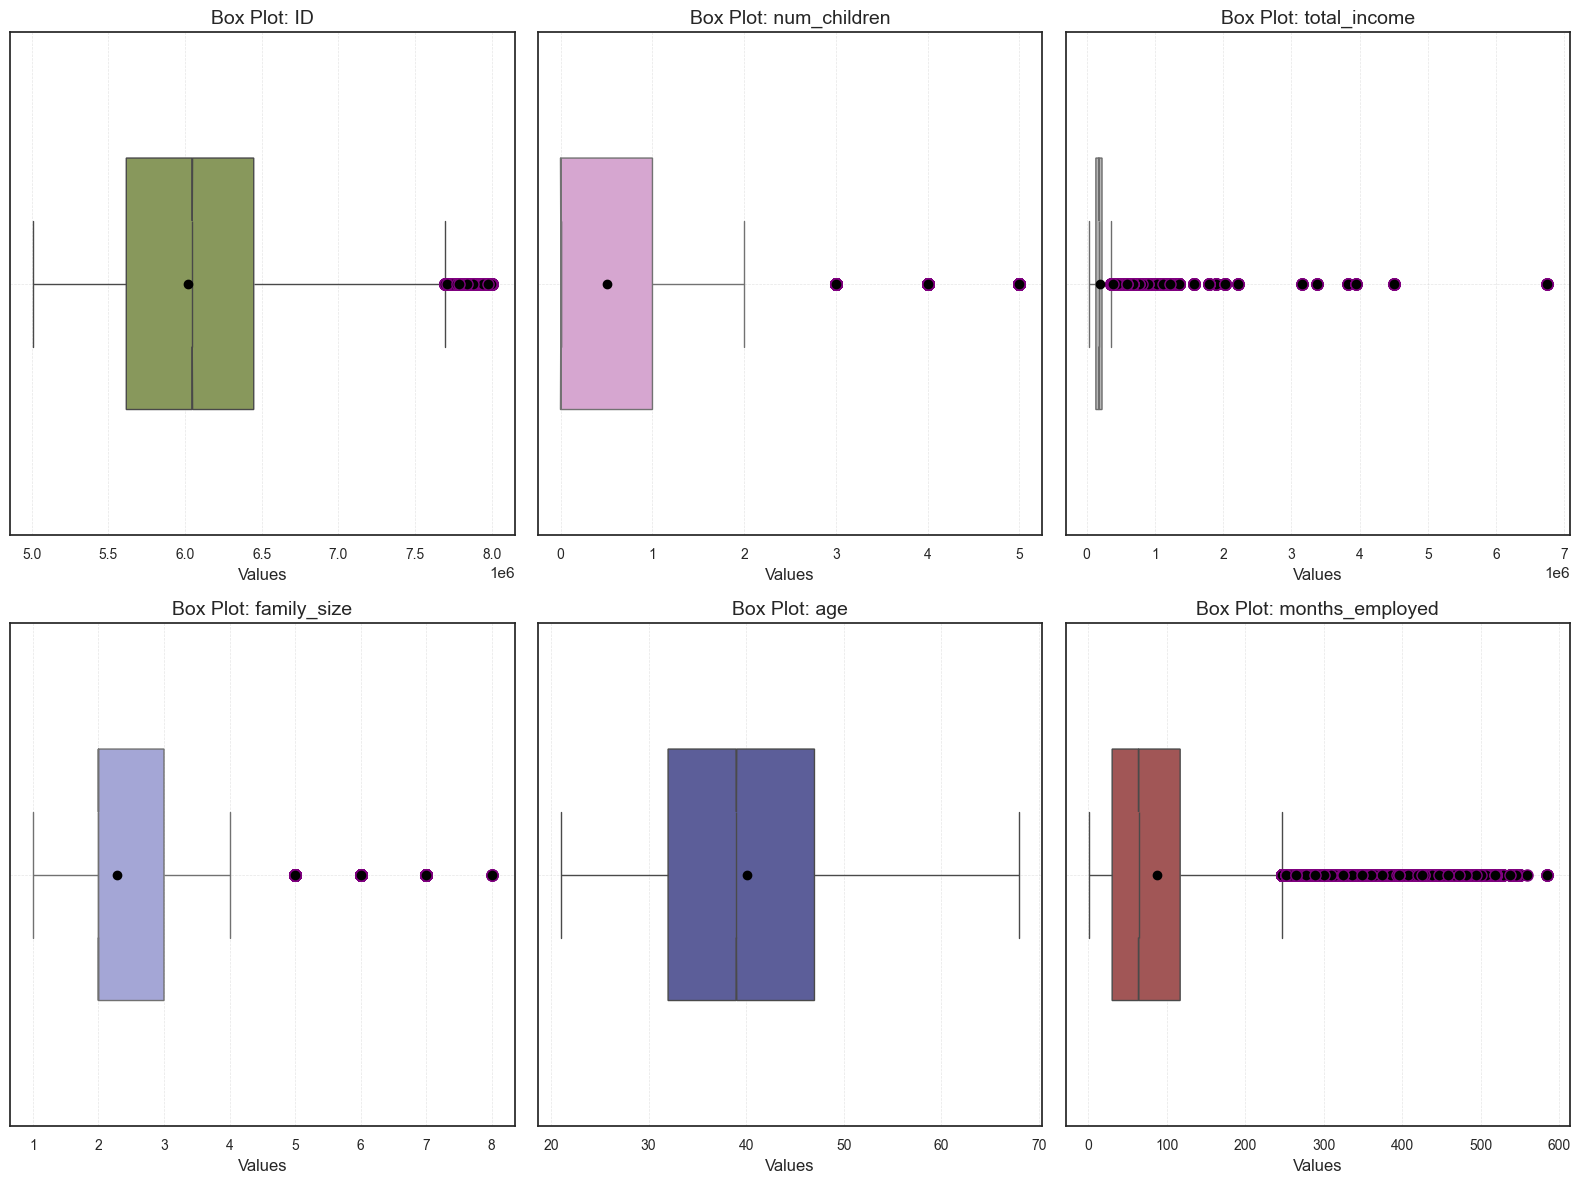

In [96]:
box_plot_all_columns(user_info_df, subplot_row = 3, figsize=(16, 12))

### Check outliers IQR

In [97]:
def check_outliers_IQR(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    outliers_column = []
    for col in num_cols:
        if df[col].nunique() > 2:
            outliers_column.append(col)
    outliers_df = df[outliers_column]
    outlier_counts = {}
    outlier_column = []
    for col in outliers_df.columns:
        q1, q3 = np.percentile(outliers_df[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = (outliers_df[col] < lower_bound) | (outliers_df[col] > upper_bound)
        outlier_counts[col] = outliers.sum()
    
    print("Number of outliers in each column (IQR method):")
    for col, count in outlier_counts.items():
        print(f"{col}: {count}")
        if count > 0:
            outlier_column.append(col)
    
    print("\nColumns with outliers:", outlier_column)
    
    return outliers_df, outlier_counts



def plot_outliers_scatterplot_IQR(df, outlier_counts, subplot_row=3, figsize: tuple = (16, 12)):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The 'data' parameter must be a pandas DataFrame.")
    
    sns.set(font_scale=1, style='white')
    
    num_cols = len(outlier_counts)
    if num_cols == 0:
        raise ValueError("The DataFrame does not contain any numerical columns.")
    
    num_rows = int(np.ceil(num_cols / subplot_row))
    fig, axes = plt.subplots(num_rows, subplot_row, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    
    for i, col in enumerate(outlier_counts.keys()):
        axes[i].scatter(df.index, df[col], label=col, color='green', edgecolor='black')
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        axes[i].scatter(df.index[outliers], df[col][outliers], color='black', edgecolor='purple', label='Outliers')
        axes[i].axhline(y=lower_bound, color='r', linestyle='--')
        axes[i].axhline(y=upper_bound, color='r', linestyle='--')
        axes[i].set_title(f'Scatterplot of {col}')
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel(col)
        axes[i].grid(True, linestyle='--', linewidth=0.3, alpha=0.3)
    plt.tight_layout()
    plt.show()



def save_transformation_metadata(metadata, column, method):
    """Save transformation metadata to pickle."""
    if not os.path.exists('pickle'):
        os.makedirs('pickle')
    
    filename = f"{column.replace(' ', '_')}_{method}_metadata.pkl"
    filepath = os.path.join('pickle', filename)
    
    with open(filepath, 'wb') as file:
        pickle.dump(metadata, file)
    print(f"Metadata for '{column}' ({method}) saved as '{filename}'.")



def handle_outliers_IQR(df, 
                    columns, 
                    method: Literal['cap', 'remove', 'impute', 'transform', 'flag']='cap', 
                    threshold=1.5, 
                    imputation_method: Literal['median', 'mean']='mean', 
                    transformation_method: Literal['log', 'sqrt', 'boxcox']='log'):
    """
    Handle outliers in specified columns of a DataFrame using various methods.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    columns (list): List of column names to process
    method (str): Outlier handling method ('cap', 'trim', 'cap', 'impute', 'transform', 'flag')
    threshold (float): IQR multiplier for defining outliers
    imputation_method (str): Method for imputation ('median' or 'mean')
    transformation_method (str): Method for transformation ('log', 'sqrt', or 'boxcox')
    
    Returns:
    pd.DataFrame: DataFrame with handled outliers
    """
    df_copy = df.copy()
    metadata = {}
    
    for col in columns:
        q1 = df_copy[col].quantile(0.25)
        q3 = df_copy[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        
        metadata[col] = {'method': method, 'threshold': threshold, 
                        'lower_bound': lower_bound, 'upper_bound': upper_bound}
        
        # This method caps the outliers at a specified percentile. It preserves the data points but limits their extreme values.
        if method == 'cap':
            df_copy[col] = np.clip(df_copy[col], lower_bound, upper_bound)
        
        # This method removing the outliers from the dataset
        elif method == 'remove':
            df_copy = df_copy[(df_copy[col] >= lower_bound) & (df_copy[col] <= upper_bound)]
        
        # This involves replacing outliers with a central tendency measure (mean, median) or a boundary value.
        elif method == 'impute':
            replacement = df_copy[col].median() if imputation_method == 'median' else df_copy[col].mean()
            df_copy.loc[df_copy[col] < lower_bound, col] = replacement
            df_copy.loc[df_copy[col] > upper_bound, col] = replacement
            metadata[col]['imputation_value'] = replacement
        
        # This involves applying a mathematical function to reduce the impact of outliers. Common transformations include log, square root, or Box-Cox.
        elif method == 'transform':
            if transformation_method == 'log':
                df_copy[col] = np.log1p(df_copy[col])
            elif transformation_method == 'sqrt':
                df_copy[col] = np.sqrt(df_copy[col])
            elif transformation_method == 'boxcox':
                df_copy[col], _ = stats.boxcox(df_copy[col] + 1)  # Adding 1 to handle zero values
            else:
                raise ValueError("Invalid transformation method. Choose 'log', 'sqrt', or 'boxcox'.")
            metadata[col]['transformation_method'] = transformation_method
        
        # This involves creating a new binary column to flag outliers and keeping the original values. This allows the model to treat outliers differently.
        elif method == 'flag':
            df_copy[f'{col}_is_outlier'] = ((df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)).astype(int)
        
        else:
            raise ValueError("Invalid method. Choose 'cap', 'remove', 'impute', 'transform', or 'flag'.")
        
        save_transformation_metadata(metadata[col], col, method)
    
    return df_copy



def handle_outliers_zscore(df, 
                           columns, 
                           method='cap', 
                           z_threshold=3, 
                           imputation_method='mean', 
                           transformation_method='log'):
    """
    Handle outliers in specified columns of a DataFrame using Z-score method and save transformation metadata.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    columns (list): List of column names to process.
    method (str): Outlier handling method ('cap', 'remove', 'impute', 'transform', 'flag').
    z_threshold (float): Z-score threshold for defining outliers.
    imputation_method (str): Method for imputation ('median' or 'mean').
    transformation_method (str): Method for transformation ('log', 'sqrt', or 'boxcox').

    Returns:
    pd.DataFrame: DataFrame with handled outliers.
    """
    df_copy = df.copy()
    metadata = {}

    for col in columns:
        z_scores = zscore(df_copy[col].dropna())
        outliers = (np.abs(z_scores) > z_threshold)
        
        # Save metadata for the column
        metadata[col] = {'method': method, 'z_threshold': z_threshold}
        
        # Cap the outliers at the threshold
        if method == 'cap':
            mean = df_copy[col].mean()
            std_dev = df_copy[col].std()
            lower_bound = mean - z_threshold * std_dev
            upper_bound = mean + z_threshold * std_dev
            df_copy[col] = np.clip(df_copy[col], lower_bound, upper_bound)
            metadata[col]['lower_bound'] = lower_bound
            metadata[col]['upper_bound'] = upper_bound
        
        # Remove the outliers from the DataFrame
        elif method == 'remove':
            df_copy = df_copy[~outliers]
        
        # Impute the outliers with the mean or median
        elif method == 'impute':
            replacement = df_copy[col].median() if imputation_method == 'median' else df_copy[col].mean()
            df_copy.loc[outliers, col] = replacement
            metadata[col]['imputation_value'] = replacement
        
        # Apply a transformation to handle outliers
        elif method == 'transform':
            if transformation_method == 'log':
                df_copy[col] = np.log1p(df_copy[col])
            elif transformation_method == 'sqrt':
                df_copy[col] = np.sqrt(df_copy[col])
            elif transformation_method == 'boxcox':
                df_copy[col], _ = stats.boxcox(df_copy[col] + 1)
            else:
                raise ValueError("Invalid transformation method. Choose 'log', 'sqrt', or 'boxcox'.")
            metadata[col]['transformation_method'] = transformation_method
        
        # Add a flag column to identify outliers
        elif method == 'flag':
            df_copy[f'{col}_is_outlier'] = outliers.astype(int)
        
        else:
            raise ValueError("Invalid method. Choose 'cap', 'remove', 'impute', 'transform', or 'flag'.")
        
        # Save metadata to a pickle file
        save_transformation_metadata(metadata[col], col, method)
    
    return df_copy







#### Before outliers handeling

In [98]:
outliers_df, outlier_counts = check_outliers_IQR(user_info_df)

Number of outliers in each column (IQR method):
ID: 3034
num_children: 5929
total_income: 18041
family_size: 5601
age: 0
months_employed: 20101

Columns with outliers: ['ID', 'num_children', 'total_income', 'family_size', 'months_employed']


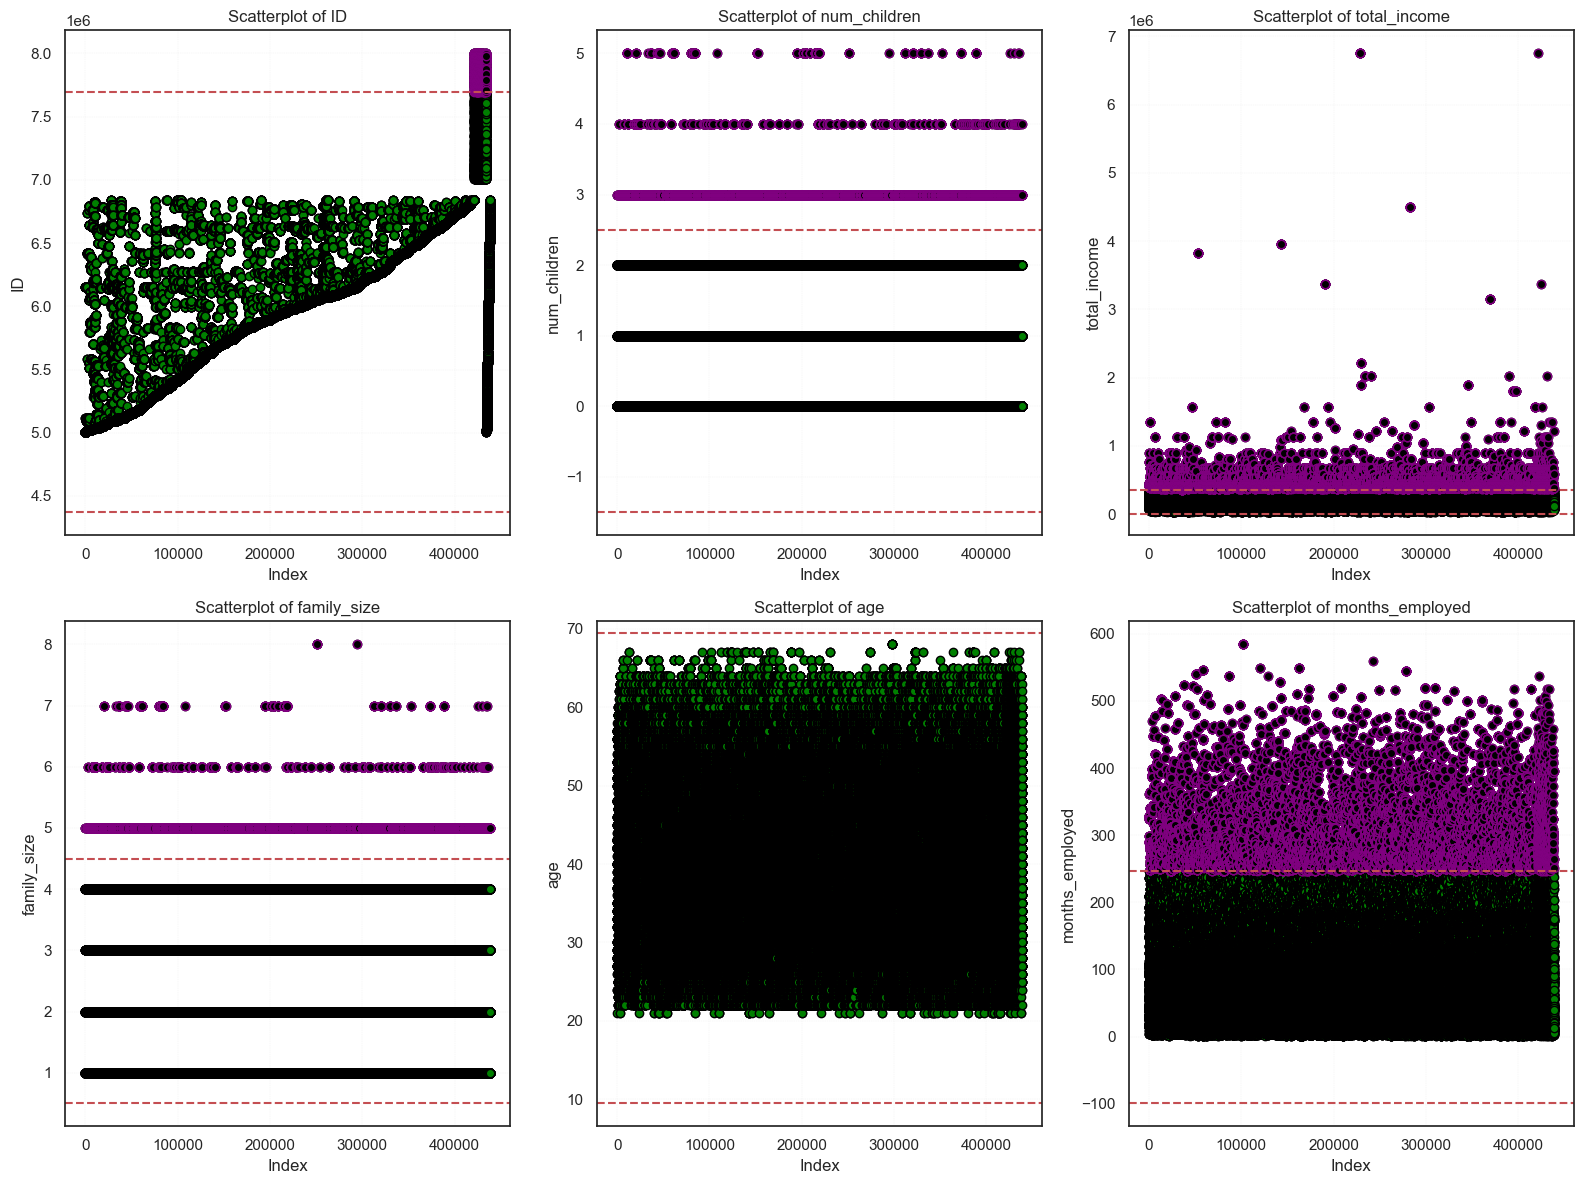

In [99]:
plot_outliers_scatterplot_IQR(user_info_df, outlier_counts)

#### After outliers handeling

In [100]:
outliers_column = ['total_income', 'months_employed']

user_info_df = handle_outliers_IQR(user_info_df, outliers_column, method='transform', transformation_method='boxcox')

outliers_df, outlier_counts = check_outliers_IQR(user_info_df)

Metadata for 'total_income' (transform) saved as 'total_income_transform_metadata.pkl'.
Metadata for 'months_employed' (transform) saved as 'months_employed_transform_metadata.pkl'.
Number of outliers in each column (IQR method):
ID: 3034
num_children: 5929
total_income: 8471
family_size: 5601
age: 0
months_employed: 93

Columns with outliers: ['ID', 'num_children', 'total_income', 'family_size', 'months_employed']


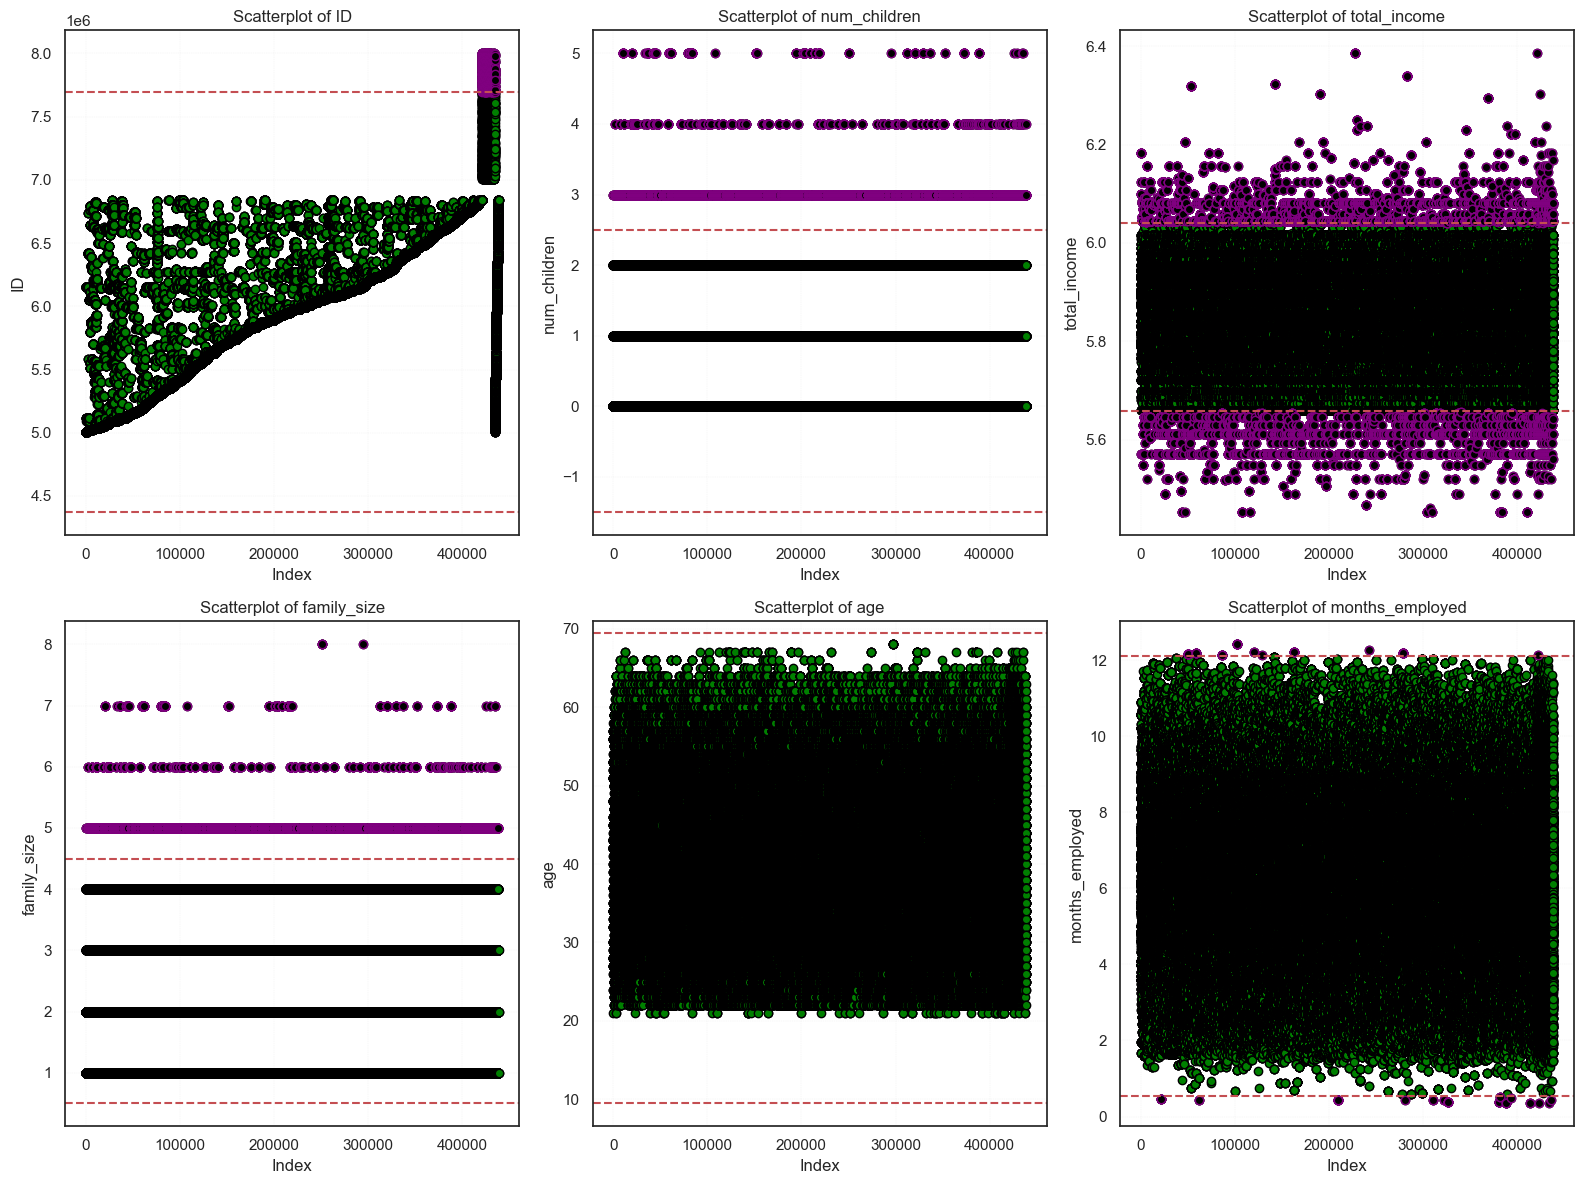

In [101]:
plot_outliers_scatterplot_IQR(user_info_df, outlier_counts)

### skew

In [102]:
def calculate_skewness(df):
    
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    cols_with_multiple_values = []
    
    right_skewed = {}
    left_skewed = {}
    normal_skewed = {}
    
    columns_right_skewed = []
    columns_left_skewed = []
    columns_normal_skewed = []
    
    for col in num_cols:
        if df[col].nunique() > 2:
            cols_with_multiple_values.append(col)
    
    for col in cols_with_multiple_values:
        skewness = df[col].skew()
        if skewness < 0.10 and skewness > -0.10:
            normal_skewed[col] = skewness
        elif skewness > 0.10:
            right_skewed[col] = skewness
        elif skewness < -0.10:
            left_skewed[col] = skewness
    
    for col in right_skewed:
        print(f"{col} is right skewed with skewness {right_skewed[col]}")
        columns_right_skewed.append(col)
    
    print(f'columns right skewed: {columns_right_skewed}')
    print('\n')
    
    for col in left_skewed:
        print(f"{col} is left skewed with skewness {left_skewed[col]}")
        columns_left_skewed.append(col)
    
    print(f'columns left skewed: {columns_left_skewed}')
    print('\n')
    
    print(f'columns right and left skewed: {columns_right_skewed + columns_left_skewed}')
    print('\n')
    
    for col in normal_skewed:
        print(f"{col} is normal skewed with skewness {normal_skewed[col]}")
        columns_normal_skewed.append(col)
    
    print(f'normal skewed columns: {columns_normal_skewed}')
    
    return columns_right_skewed, columns_left_skewed


def handle_skewness(
    df: pd.DataFrame,
    columns: List[str],
    method: Literal['log', 'sqrt', 'cbrt', 'reciprocal', 'boxcox', 'yeo_johnson', 'winsorize', 'binning', 'robust_scale'] = 'yeo_johnson',
    log_base: float = np.e,
    boxcox_lambda: Optional[float] = None,
    yeo_johnson_lambda: Optional[float] = None,
    winsorize_limits: Tuple[float, float] = (0.05, 0.05),
    binning_strategy: Literal['quantile', 'uniform', 'kmeans'] = 'quantile',
    n_bins: int = 10,
    robust_scale_quantile_range: Tuple[float, float] = (25.0, 75.0)
) -> pd.DataFrame:
    """
    Handle skewness in specified columns using selected method.

    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to transform
    - method: list of methods to apply. If None, 'yeo_johnson' is applied by default.
        Available methods: ['log', 'sqrt', 'cbrt', 'reciprocal', 'boxcox', 'yeo_johnson', 'winsorize', 'binning', 'robust_scale']
    - log_base: base for logarithmic transformation (default: np.e)
    - boxcox_lambda: lambda parameter for Box-Cox transformation (default: None, i.e., find optimal lambda)
    - yeo_johnson_lambda: lambda parameter for Yeo-Johnson transformation (default: None, i.e., find optimal lambda)
    - winsorize_limits: tuple of (lower, upper) percentiles to winsorize (default: (0.05, 0.05))
    - binning_strategy: strategy for binning ('uniform', 'quantile', or 'kmeans') (default: 'quantile')
    - n_bins: number of bins for binning (default: 10)
    - robust_scale_quantile_range: tuple of (q_min, q_max) for RobustScaler (default: (25.0, 75.0))

    Returns:
    - DataFrame with original and transformed columns
    """
    metadata = {}
    available_methods = ['log', 'sqrt', 'cbrt', 'reciprocal', 'boxcox', 'yeo_johnson', 'winsorize', 'binning', 'robust_scale']
    
    if method not in available_methods:
        raise ValueError(f"Invalid method: {method}. Available methods: {available_methods}")

    for col in columns:
        
        metadata[col] = {'method': method}
        
        if method == 'log':
            # Handles right-skewed data well, can't handle negative values
            if np.any(df[col] <= 0):
                raise ValueError(f"Column {col} contains non-positive values, cannot apply log transformation")
            df[col] = np.log(df[col]) / np.log(log_base)
            metadata[col]['log_base'] = log_base
        
        elif method == 'sqrt':
            # Handles right-skewed data, less aggressive than log
            if np.any(df[col] < 0):
                raise ValueError(f"Column {col} contains negative values, cannot apply sqrt transformation")
            df[col] = np.sqrt(df[col])
        
        elif method == 'cbrt':
            # Handles both right and left-skewed data, can handle negative values
            df[col] = np.cbrt(df[col])
        
        elif method == 'reciprocal':
            # Handles right-skewed data, can't handle zero values
            if np.any(df[col] == 0):
                raise ValueError(f"Column {col} contains zero values, cannot apply reciprocal transformation")
            df[col] = 1 / df[col]
        
        elif method == 'boxcox':
            # Handles right-skewed data, requires all positive values
            if np.any(df[col] <= 0):
                raise ValueError(f"Column {col} contains non-positive values, cannot apply boxcox transformation")
            df[col], _ = stats.boxcox(df[col], lmbda=boxcox_lambda)
            metadata[col]['boxcox_lambda'] = boxcox_lambda
        
        elif method == 'yeo_johnson':
            # Handles both right and left-skewed data, can handle negative values
            df[col], _ = stats.yeojohnson(df[col], lmbda=yeo_johnson_lambda)
            metadata[col]['yeo_johnson_lambda'] = yeo_johnson_lambda
        
        elif method == 'winsorize':
            # Handles both right and left-skewed data by capping extreme values
            df[col] = stats.mstats.winsorize(df[col], limits=winsorize_limits)
        
        elif method == 'binning':
            # Can help with both right and left-skewed data
            if binning_strategy == 'quantile':
                df[col] = pd.qcut(df[col], q=n_bins, labels=False, duplicates='drop')
            elif binning_strategy == 'uniform':
                df[col] = pd.cut(df[col], bins=n_bins, labels=False)
            elif binning_strategy == 'kmeans':
                from sklearn.cluster import KMeans
                kmeans = KMeans(n_clusters=n_bins, n_init=10, random_state=42)
                df[col] = kmeans.fit_predict(df[col].values.reshape(-1, 1))
        
        elif method == 'robust_scale':
            # Handles both right and left-skewed data
            scaler = RobustScaler(quantile_range=robust_scale_quantile_range)
            df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
            
        save_transformation_metadata(metadata[col], col, method)
        
    return df




In [103]:
columns_right_skewed, columns_left_skewed = calculate_skewness(user_info_df)

ID is right skewed with skewness 0.21252667208539813
num_children is right skewed with skewness 1.4249556931064558
family_size is right skewed with skewness 0.7427878003672892
age is right skewed with skewness 0.25154926935802985
columns right skewed: ['ID', 'num_children', 'family_size', 'age']


columns left skewed: []


columns right and left skewed: ['ID', 'num_children', 'family_size', 'age']


total_income is normal skewed with skewness -0.010427351321316775
months_employed is normal skewed with skewness -0.030497571657413874
normal skewed columns: ['total_income', 'months_employed']


# 2- Clean credit_record_df

In [104]:
df_columns = credit_record_df.columns.to_list()
print(df_columns)

['ID', 'MONTHS_BALANCE', 'STATUS']


In [105]:
columns_info(credit_record_df)

names  dtypes                                             unique  \
0              ID   int64  [5001711, 5001712, 5001713, 5001714, 5001715, ...   
1  MONTHS_BALANCE   int64  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   
2          STATUS  object                           [X, 0, C, 1, 2, 3, 4, 5]   

   n_unique  max_value  min_value  number_of_rows  number_of_null  
0     45985  5150487.0  5001711.0         1048575               0  
1        61        0.0      -60.0         1048575               0  
2         8        NaN        NaN         1048575               0

In [106]:
credit_record_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


## 1- extract ids that in user_info_df

In [107]:
ids = user_info_df['ID'].unique()

len(ids)

363149

In [108]:
# to work on the rows i have his information in the application_records data

credit_record_df = credit_record_df[credit_record_df['ID'].isin(ids)]

print(credit_record_df.shape)

credit_record_df.head()

(649743, 3)


ID  MONTHS_BALANCE STATUS
92938  5008804               0      C
92939  5008804              -1      C
92940  5008804              -2      C
92941  5008804              -3      C
92942  5008804              -4      C

## 2- Handel the data

In [109]:
# i creat Map to put the class 0 or 1 

def categorize_and_count(group):
    statuses = group['STATUS'].tolist()
    
    # Updated weights for good and bad statuses
    count_good = (
        statuses.count('C') * 1.0 +   # Paid off (best status)
        statuses.count('0') * 0.8     # 1-29 days past due, Slightly delayed (very good)
    )
    
    count_bad = (
        statuses.count('1') * 5 +     # 30-59 days past due (moderate risk)
        statuses.count('2') * 6 +     # 60-89 days past due (high risk)
        statuses.count('3') * 8 +     # 90-119 days past due (very high risk)
        statuses.count('4') * 10 +     # 120-149 days past due (critical risk)
        statuses.count('5') * 12      # More than 150 days past due (worst risk)
    )
    
    # Determine the classification based on weighted counts
    if count_bad >= count_good:
        return 0  # Bad credit
    elif count_good > count_bad:
        return 1  # Good credit


# Filter out 'X' statuses
agg_df = credit_record_df[credit_record_df['STATUS'] != 'X'].copy()

# Apply the classification
classification_df = agg_df.groupby('ID').apply(categorize_and_count).reset_index(name='STATUS')

# Find the minimum MONTHS_BALANCE for each ID
min_month_df = credit_record_df.groupby('ID')['MONTHS_BALANCE'].min().reset_index(name='Months_sub')

# Merge the classification and minimum month results
final_credit_record_classification_df = pd.merge(min_month_df, classification_df, on='ID')

final_credit_record_classification_df['Months_sub'] = final_credit_record_classification_df['Months_sub'].abs()

print(final_credit_record_classification_df.shape)

final_credit_record_classification_df.head()

(27468, 3)


ID  Months_sub  STATUS
0  5008804          15       1
1  5008805          14       1
2  5008806          29       1
3  5008808           4       1
4  5008810          26       1

In [110]:
# Save the final map to pickle
output_folder = "pickle"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_path = os.path.join(output_folder, "credit_classification_map.pkl")
with open(output_path, "wb") as f:
    pickle.dump(final_credit_record_classification_df, f)

print(f"Final classification map saved to {output_path}")

Final classification map saved to pickle\credit_classification_map.pkl


In [111]:
# # Reload the processed map
# import pickle

# input_path = "pickle/credit_classification_map.pkl"
# with open(input_path, "rb") as f:
#     loaded_credit_map = pickle.load(f)

# print("Loaded classification map:")
# print(loaded_credit_map.head())


In [112]:
final_credit_record_classification_df['STATUS'].value_counts()

STATUS
1    26216
0     1252
Name: count, dtype: int64

# 3- Marge the two DataFrame

## Visualization df

In [113]:
original_df = pd.merge(original_user_info_df, final_credit_record_classification_df, on='ID')

original_df = original_df.drop(['ID'], axis=1)

original_df.rename(columns={'STATUS':'Status'}, inplace=True)

original_df.dropna(inplace=True)

original_df.drop_duplicates(inplace=True)

print(original_df.shape)

original_df.head()

(20374, 18)


gender  owns_car  owns_realty  num_children  total_income  \
2       1         1            1             0        112500   
3       0         0            1             0        270000   
4       0         0            1             0        270000   
5       0         0            1             0        270000   
6       1         1            1             0        270000   

            income_type                education_level         family_status  \
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   
5  Commercial associate  Secondary / secondary special  Single / not married   
6               Working               Higher education               Married   

        housing_type  has_work_phone  has_phone  has_email      occupation  \
2  House / apartment               0          0          0  Security staff   
3  House / apartment               0          1          1     Sales staff   
4  House / apartment               0          1          1     Sales staff   
5  House / apartment               0          1          1     Sales staff   
6  House / apartment               1          1          1     Accountants   

   family_size  age  months_employed  Months_sub  Status  
2            2   58           37.800          29       1  
3            1   52          101.700           4       1  
4            1   52          101.700          26       1  
5            1   52          101.700          38       1  
6            2   46           25.633           5       1

## Main DataFrame

In [114]:
classification_df = pd.merge(user_info_df, final_credit_record_classification_df, on='ID')

classification_df = classification_df.drop(['ID'], axis=1)

classification_df.rename(columns={'STATUS':'status'}, inplace=True)

target_column_classification = 'status'

# classification_df.dropna(inplace=True)

classification_df.drop_duplicates(inplace=True)

print(classification_df.shape)

classification_df.head()

(24548, 18)


gender  owns_car  owns_realty  num_children  total_income  \
0       1         1            1             0      6.007459   
1       1         1            1             0      6.007459   
2       1         1            1             0      5.765550   
3       0         0            1             0      5.929204   
4       0         0            1             0      5.929204   

            income_type                education_level         family_status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

        housing_type  has_work_phone  has_phone  has_email      occupation  \
0   Rented apartment               1          0          0             NaN   
1   Rented apartment               1          0          0             NaN   
2  House / apartment               0          0          0  Security staff   
3  House / apartment               0          1          1     Sales staff   
4  House / apartment               0          1          1     Sales staff   

   family_size  age  months_employed  Months_sub  status  
0            2   32         8.421503          15       1  
1            2   32         8.421503          14       1  
2            2   58         5.286791          29       1  
3            1   52         7.431940           4       1  
4            1   52         7.431940          26       1

In [115]:
classification_df['status'].value_counts()

status
1    23353
0     1195
Name: count, dtype: int64

# 4 - Fill null column

In [116]:
classification_df = fill_missing_values_dataFrame(
    classification_df, 
    model='dependent_column', 
    column_to_impute='occupation', 
    dependent_column='status', 
    top_n=5
)
classification_df.isnull().sum()

Columns with missing values: ['occupation']
Imputation completed using dependent_column model


gender             0
owns_car           0
owns_realty        0
num_children       0
total_income       0
income_type        0
education_level    0
family_status      0
housing_type       0
has_work_phone     0
has_phone          0
has_email          0
occupation         0
family_size        0
age                0
months_employed    0
Months_sub         0
status             0
dtype: int64

# 5 - Encoder

In [117]:
classification_df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

['income_type',
 'education_level',
 'family_status',
 'housing_type',
 'occupation']

In [118]:
print(classification_df['income_type'].unique())
print(classification_df['education_level'].unique())
print(classification_df['family_status'].unique())
print(classification_df['housing_type'].unique())
print(classification_df['occupation'].unique())

['Working' 'Commercial associate' 'State servant' 'Student' 'Pensioner']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
['Managers' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Drivers' 'Core staff' 'High skill tech staff' 'Cleaning staff'
 'Cooking staff' 'Low-skill Laborers' 'Medicine staff'
 'Private service staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'IT staff' 'Realty agents']


In [119]:
classification_df = encode_column(classification_df, columns = 'income_type', method= 'ordinal', ordinal_categories=['Student', 'Pensioner', 'Working', 'State servant', 'Commercial associate'])
classification_df = encode_column(classification_df, columns = 'education_level', method= 'ordinal', ordinal_categories=['Lower secondary', 'Incomplete higher', 'Secondary / secondary special', 'Higher education', 'Academic degree'])
classification_df = encode_column(classification_df, columns = 'family_status', method= 'ordinal', ordinal_categories=['Separated', 'Widow', 'Single / not married', 'Civil marriage', 'Married'])
classification_df = encode_column(classification_df, columns = 'housing_type', method= 'ordinal', ordinal_categories=['Rented apartment', 'Municipal apartment', 'With parents', 'Office apartment', 'Co-op apartment', 'House / apartment'])
classification_df = encode_column(classification_df, columns = 'occupation', method= 'ordinal', ordinal_categories=['Low-skill Laborers', 'Cleaning staff', 'Cooking staff', 'Waiters/barmen staff', 'Private service staff', 'Medicine staff', 'Secretaries', 'Laborers', 'Drivers', 'Security staff', 'Sales staff', 'Accountants', 'Core staff', 'HR staff', 'High skill tech staff', 'Realty agents', 'IT staff', 'Managers'])

Encoder for 'income_type' saved as 'income_type_OE.pkl' in 'pickle/' folder.
Encoder for 'education_level' saved as 'education_level_OE.pkl' in 'pickle/' folder.
Encoder for 'family_status' saved as 'family_status_OE.pkl' in 'pickle/' folder.
Encoder for 'housing_type' saved as 'housing_type_OE.pkl' in 'pickle/' folder.
Encoder for 'occupation' saved as 'occupation_OE.pkl' in 'pickle/' folder.


In [120]:
classification_df['income_type'] = classification_df['income_type'].astype('int64')
classification_df['education_level'] = classification_df['education_level'].astype('int64')
classification_df['family_status'] = classification_df['family_status'].astype('int64')
classification_df['housing_type'] = classification_df['housing_type'].astype('int64')
classification_df['occupation'] = classification_df['occupation'].astype('int64')

In [121]:
classification_df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

[]

# 6- Visualization

In [122]:
columns_info(original_df)

names   dtypes  \
0            gender    int64   
1          owns_car    int64   
2       owns_realty    int64   
3      num_children    int64   
4      total_income    int64   
5       income_type   object   
6   education_level   object   
7     family_status   object   
8      housing_type   object   
9    has_work_phone    int64   
10        has_phone    int64   
11        has_email    int64   
12       occupation   object   
13      family_size    int64   
14              age    int64   
15  months_employed  float64   
16       Months_sub    int64   
17           Status    int64   

                                               unique  n_unique    max_value  \
0                                              [1, 0]         2        1.000   
1                                              [1, 0]         2        1.000   
2                                              [1, 0]         2        1.000   
3                                  [0, 3, 1, 2, 4, 5]         6        5.000   
4   [112500, 270000, 135000, 130500, 157500, 40500...       190  1575000.000   
5   [Working, Commercial associate, State servant,...         5          NaN   
6   [Secondary / secondary special, Higher educati...         5          NaN   
7   [Married, Single / not married, Civil marriage...         5          NaN   
8   [House / apartment, Rented apartment, Municipa...         6          NaN   
9                                              [0, 1]         2        1.000   
10                                             [0, 1]         2        1.000   
11                                             [0, 1]         2        1.000   
12  [Security staff, Sales staff, Accountants, Lab...        18          NaN   
13                              [2, 1, 5, 3, 4, 6, 7]         7        7.000   
14  [58, 52, 46, 48, 29, 27, 34, 32, 56, 43, 44, 4...        47       67.000   
15  [37.8, 101.7, 25.633, 39.8, 36.767, 48.967, 38...      3225      523.767   
16  [29, 4, 26, 38, 5, 42, 16, 8, 22, 7, 3, 25, 30...        61       60.000   
17                                             [1, 0]         2        1.000   

    min_value  number_of_rows  number_of_null  
0       0.000           20374               0  
1       0.000           20374               0  
2       0.000           20374               0  
3       0.000           20374               0  
4   27000.000           20374               0  
5         NaN           20374               0  
6         NaN           20374               0  
7         NaN           20374               0  
8         NaN           20374               0  
9       0.000           20374               0  
10      0.000           20374               0  
11      0.000           20374               0  
12        NaN           20374               0  
13      1.000           20374               0  
14     21.000           20374               0  
15      0.567           20374               0  
16      0.000           20374               0  
17      0.000           20374               0

In [123]:
original_df.head(3)

gender  owns_car  owns_realty  num_children  total_income  \
2       1         1            1             0        112500   
3       0         0            1             0        270000   
4       0         0            1             0        270000   

            income_type                education_level         family_status  \
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

        housing_type  has_work_phone  has_phone  has_email      occupation  \
2  House / apartment               0          0          0  Security staff   
3  House / apartment               0          1          1     Sales staff   
4  House / apartment               0          1          1     Sales staff   

   family_size  age  months_employed  Months_sub  Status  
2            2   58             37.8          29       1  
3            1   52            101.7           4       1  
4            1   52            101.7          26       1

## Pie Chart

In [124]:
def pie_chart_plotly(
    labels: List[str],
    sizes: List[float],
    title: Optional[str] = None,
    color_sequence: Optional[List[str]] = None,
    hole: float = 0,
    pull: Optional[List[float]] = None,
    text_info: str = 'percent+label',
    text_position: str = 'inside',
    opacity: float = 0.8,
    width: int = 800,
    height: int = 600
):
    """
    Generates an interactive pie chart using Plotly Express.

    Parameters:
    ---------
    labels (List[str]): A list of labels for the pie chart slices.
    sizes (List[float]): A list of sizes for each pie chart slice.
    title (Optional[str]): The title of the pie chart.
    color_sequence (Optional[List[str]]): A list of colors for the pie chart slices.
    hole (float): The size of the hole in the middle of the pie chart (0 to 1).
    pull (Optional[List[float]]): A list of values to pull slices out from the center.
    text_info (str): The information to display on the slices.
    text_position (str): The position of the text on the slices.
    opacity (float): The opacity of the pie chart slices.
    width (int): The width of the figure in pixels.
    height (int): The height of the figure in pixels.
    
    Example:
    -------
    >>> pie_chart_plotly(labels=cars, sizes=data, title="Customized Car Sales Pie Chart")
    
    Returns:
    -------
    plotly.graph_objs._figure.Figure
    """
    
    # Create a DataFrame from the labels and sizes
    df = pd.DataFrame({'labels': labels, 'sizes': sizes})
    
    # Set default title if not provided
    if title is None:
        title = 'Pie Chart'
    
    # Generate random pull values if not provided
    if pull is None:
        pull = [random.uniform(0, 0.2) if random.random() > 0.5 else 0 for _ in range(len(labels))]

    # Create the pie chart
    fig = px.pie(
        df,
        values='sizes',
        names='labels',
        title=title,
        color_discrete_sequence=color_sequence,
        hole=hole,
        opacity=opacity
    )

    # Update the layout and traces
    fig.update_traces(
        textposition=text_position,
        textinfo=text_info,
        pull=pull
    )

    fig.update_layout(
        width=width,
        height=height
    )

    return fig


def pie_chart(
    labels: List[str],
    sizes: List[float],
    explode: Optional[Tuple[float, ...]] = None,
    palette: str = 'magma',
    shadow: bool = True,
    startangle: int = 90,
    title: Optional[str] = None,
    figsize: Tuple[int, int] = (10, 7),
    wedge_linewidth: float = 1.0,
    wedge_edgecolor: str = 'black',
    text_color: str = 'black',
    text_size: int = 8,
    text_weight: str = 'bold',
    legend_title: str = 'Legend',
    legend_loc: str = 'best',
    legend_bbox_to_anchor: Tuple[float, float, float, float] = (1, 0, 0, 1)
):
    """
    Generates a pie chart with the given parameters.

    Parameters:
    ---------
    labels (List[str]): A list of labels for the pie chart slices.
    sizes (List[float]): A list of sizes for each pie chart slice.
    explode (Optional[Tuple[float, ...]]): A tuple indicating the fraction of the radius with which to offset each wedge.
    palette (str): The color palette to use for the pie chart.
    shadow (bool): Whether to draw a shadow beneath the pie chart.
    startangle (int): The starting angle for the pie chart.
    title (Optional[str]): The title of the pie chart.
    figsize (Tuple[int, int]): The size of the figure.
    wedge_linewidth (float): The linewidth of the pie chart wedges.
    wedge_edgecolor (str): The edge color of the pie chart wedges.
    text_color (str): The color of the text labels.
    text_size (int): The size of the text labels.
    text_weight (str): The weight of the text labels.
    legend_title (str): The title of the legend.
    legend_loc (str): The location of the legend.
    legend_bbox_to_anchor (Tuple[float, float, float, float]): The bounding box anchor for the legend.
    
    Example:
    -------
    >>> pie_chart(labels=cars, sizes=data, title="Customized Car Sales Pie Chart")
    
    Returns:
    -------
    None
    """
    
    # Sample colors from the chosen palette
    colors = sns.color_palette(palette, len(labels))
    
    # Set default title if not provided
    if title is None:
        title = 'Pie Chart'
    
    # Generate random explode values if not provided
    if explode is None:
        random_list = []
        for _ in range(len(labels)):
            rand_num = random.random()
            if rand_num < 0.5:
                random_list.append(0)
            else:
                random_list.append(round(random.uniform(0.1, 0.3), 1))
        explode = tuple(random_list)

    # Function to format the percentages and absolute values on the pie chart
    def func(pct: float, allvalues: List[float]) -> str:
        absolute = int(pct / 100. * np.sum(allvalues))
        return f"{pct:.2f}%\n({absolute:d})"

    # Create a figure and axis for the pie chart
    fig, ax = plt.subplots(figsize=figsize)
    
    # Properties for the pie chart wedges
    wedge_props = {'linewidth': wedge_linewidth, 'edgecolor': wedge_edgecolor}
    
    # Plot the pie chart
    wedges, texts, autotexts = ax.pie(
        sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct=lambda pct: func(pct, sizes),
        shadow=shadow,
        startangle=startangle,
        wedgeprops=wedge_props,
        textprops=dict(color=text_color)
    )

    # Add a legend to the pie chart
    ax.legend(wedges, labels, title=legend_title, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor)
    
    # Set properties for the text on the pie chart
    plt.setp(autotexts, size=text_size, weight=text_weight)
    
    # Set the title of the pie chart
    ax.set_title(title)
    
    # Display the pie chart
    plt.show()


def randomize_lists(list1, list2):
    """
    Randomize the order of two lists while maintaining their relative pairings.
    
    Args:
    list1 (list): First input list
    list2 (list): Second input list
    
    Returns:
    tuple: A tuple containing two randomized lists
    
    Raises:
    ValueError: If the lists have different lengths
    """
    # Check if lists have the same length
    if len(list1) != len(list2):
        raise ValueError("Lists must have equal length")
    
    # Create a list of tuples to preserve original pairings
    paired_list = list(zip(list1, list2))
    
    # Shuffle the paired list
    random.shuffle(paired_list)
    
    # Unzip the shuffled list back into two separate lists
    shuffled_list1, shuffled_list2 = zip(*paired_list)
    
    # Convert back to lists (zip returns tuples)
    return list(shuffled_list1), list(shuffled_list2)



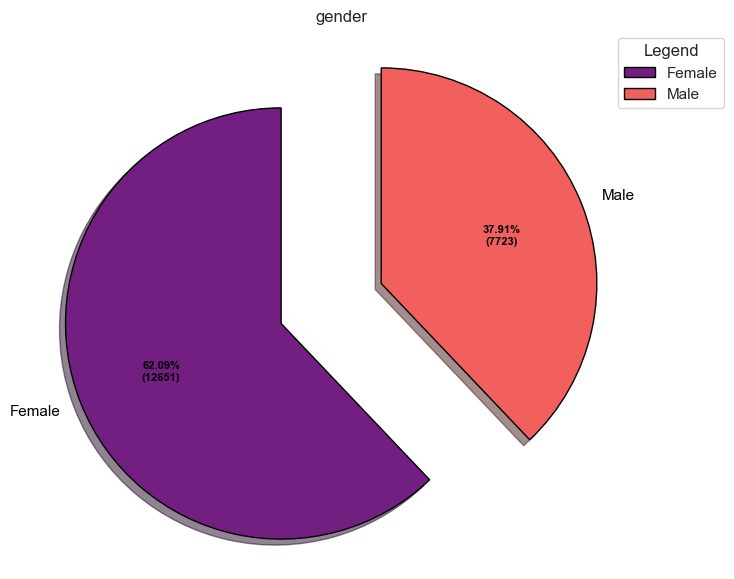

In [125]:
PaymentMethod_name = ['Female', 'Male']
PaymentMethod_values = original_df['gender'].value_counts().values.tolist()
pie_chart(labels=PaymentMethod_name, sizes=PaymentMethod_values, title="gender")

In [126]:
PaymentMethod_name = original_df['num_children'].value_counts().index.to_list()
PaymentMethod_values = original_df['num_children'].value_counts().values.tolist()
pie_chart_plotly(labels=PaymentMethod_name, sizes=PaymentMethod_values, title="num_children")

In [127]:
PaymentMethod_name = original_df['housing_type'].value_counts().index.to_list()
PaymentMethod_values = original_df['housing_type'].value_counts().values.tolist()
pie_chart_plotly(labels=PaymentMethod_name, sizes=PaymentMethod_values, title="housing_type")

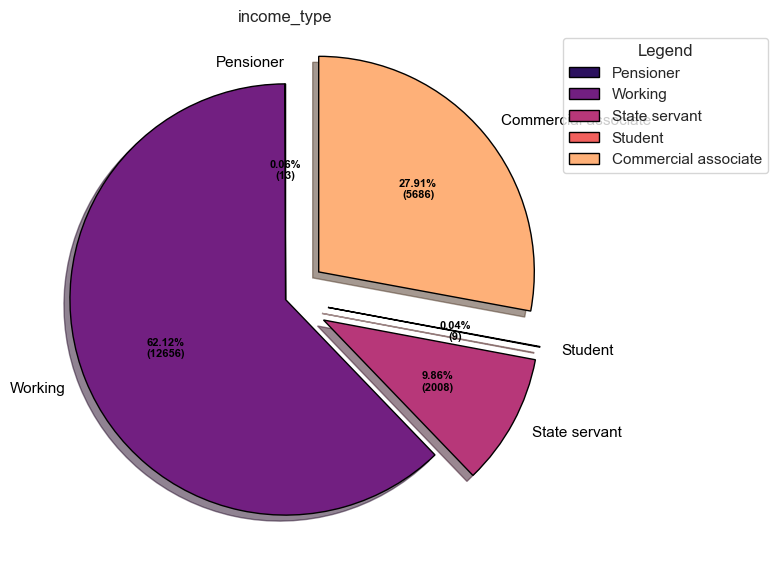

In [128]:
PaymentMethod_name = original_df['income_type'].value_counts().index.to_list()
PaymentMethod_values = original_df['income_type'].value_counts().values.tolist()
PaymentMethod_name, PaymentMethod_values = randomize_lists(PaymentMethod_name, PaymentMethod_values)
pie_chart(labels=PaymentMethod_name, sizes=PaymentMethod_values, title="income_type")

## Multiple bar

In [129]:
def multiple_bar_plot_matplotlib(
    categories, 
    datasets, 
    labels=None, 
    palette='magma', 
    width=0.35, 
    edgecolor='black', 
    xlabel=None, 
    ylabel=None, 
    title=None, 
    hatches:list=None, 
    hatch:bool=True, 
    order=False, 
    figsize=(10, 6)
):
    """
    Creates multiple bar plots using Matplotlib with customizable colors, hatches, and labels.
    
    Parameters:
    ---------
    - categories (list): Categories for the x-axis.
    - datasets (list of lists): Values for each dataset.
    - labels (list): Labels for each dataset.
    - palette (str): Color palette for the bars (default is 'magma').
    - width (float): Width of the bars (default is 0.35).
    - edgecolor (str): Edge color of the bars (default is 'black').
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - title (str): Title of the plot.
    - hatches (list): List of hatches for the bars.
    - hatch (bool): to make hatches or not (default is True).
    - order (bool): Whether to order the bars by height of the first dataset (default is False).
    - figsize (tuple): Figure size (default is (10, 6)).
    
    Examples:
    --------
    >>> multiple_bar_plot_matplotlib(tick_labels, data, labels=labels, palette='viridis', title='Scores by group and category', xlabel='Category', ylabel='Scores',width=0.65)
    >>> multiple_bar_plot_matplotlib(categories, [values1,values2], palette='viridis', title='Scores by group and category', xlabel='Category', ylabel='Scores',width=0.65)
    
    Returns:
    -------
    - None
    """
    # If ordering is requested, order the categories and all datasets by the first dataset
    if order:
        categories, *datasets = zip(*sorted(zip(categories, *datasets), key=lambda pair: pair[1], reverse=True))

    # Determine the number of datasets
    num_datasets = len(datasets)
    
    # Determine the width of each bar group
    bar_width = width / num_datasets
    
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    x = np.arange(len(categories))  # the label locations
    
    # Determine hatches if not provided and hatching is enabled
    if hatch:
        if not hatches:
            hatches = random.sample(['X', 'oo', 'O|', '/', '+', '++', '--', '-\\', 'xx', '*-', '\\\\', '|*', '\\', 'OO', 'o', '**', 'o-', '*', '//', '||', '+o', '..', '/o', 'O.', '\\|', 'x*', '|', '-', None], len(categories))
    
    # Determine colors
    colors = random.sample(sns.color_palette(palette), num_datasets)
    
    for i, dataset in enumerate(datasets):
        bar_position = x + (i - num_datasets / 2) * bar_width + bar_width / 2
        bars = ax.bar(bar_position, dataset, bar_width, label=labels[i] if labels else f'Dataset {i+1}', color=colors[i] if colors else None, edgecolor=edgecolor, hatch=hatches if hatch else None)
        
        # Adding data labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Set the labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend(title=title)
    
    # Add gridlines
    ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.4)
    
    # Adjust layout to make room for the annotations
    fig.tight_layout()
    plt.show()




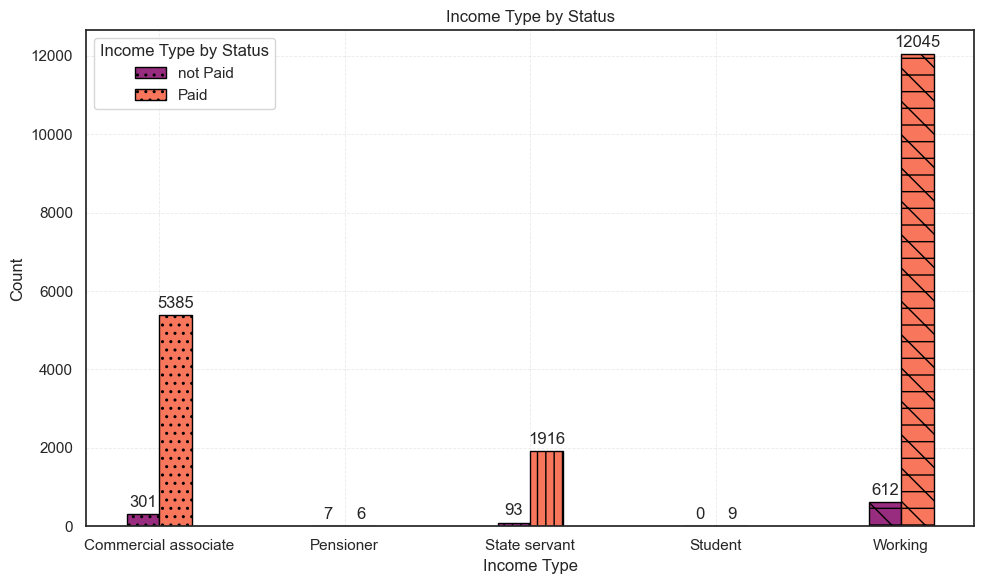

In [130]:
grouped_data = original_df.groupby(['income_type', 'Status']).size().unstack(fill_value=0)

categories = grouped_data.index.tolist()
datasets = [grouped_data[col].tolist() for col in grouped_data.columns]
labels = ['not Paid', 'Paid']

multiple_bar_plot_matplotlib(categories, datasets, labels=labels, title='Income Type by Status', xlabel='Income Type', ylabel='Count')

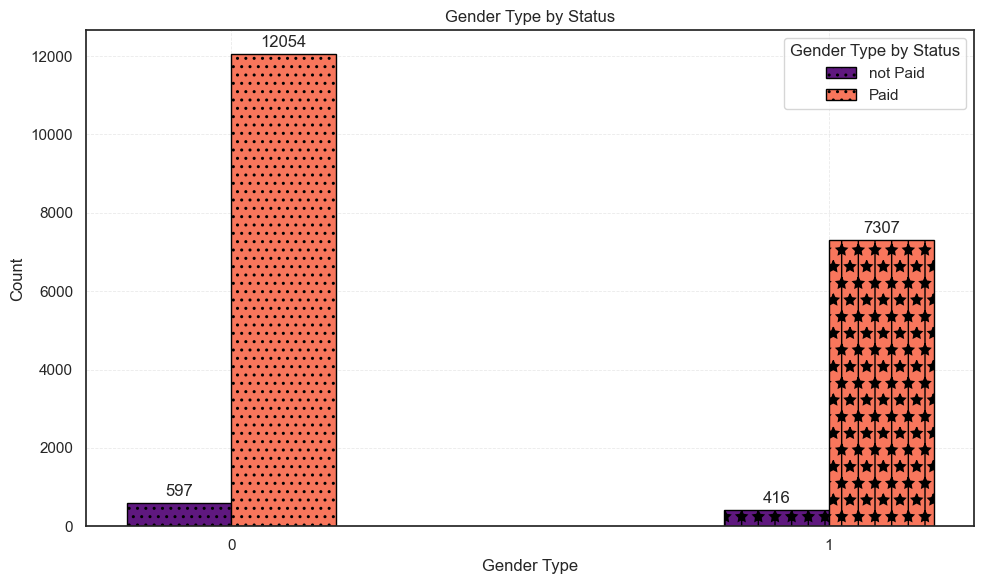

In [131]:
grouped_data = original_df.groupby(['gender', 'Status']).size().unstack(fill_value=0)

categories = grouped_data.index.tolist()
datasets = [grouped_data[col].tolist() for col in grouped_data.columns]
labels = ['not Paid', 'Paid']

multiple_bar_plot_matplotlib(categories, datasets, labels=labels, title='Gender Type by Status', xlabel='Gender Type', ylabel='Count')

## Bar

In [132]:
def bar_plot_matplotlib(
    x, y, 
    palette='magma', 
    palette2='viridis',
    color=None,
    width=0.75, 
    edgecolor='black', 
    xlabel=None, 
    ylabel=None, 
    title=None, 
    hatches:list=None,
    hatch:bool=True,
    order=False,
    x_rotation = 45,
    figsize = (10, 8)
):
    """
    Creates a bar plot using matplotlib with customizable colors, hatches, and labels.
    
    Parameters:
    --------
    - x (list): Categories for the x-axis.
    - y (list): Values for the y-axis.
    - palette (str): Color palette for the bars (default is 'magma').
    - width (float): Width of the bars (default is 0.8).
    - edgecolor (str): Edge color of the bars (default is 'black').
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - title (str): Title of the plot.
    - hatches (list): List of hatches for the bars.
    - hatch (bool): to make hatches or not (default is True)
    - order (bool): Whether to order the bars by height (default is False).
    
    Example:
    --------
    >>> bar_plot_matplotlib(categories, values)
    
    Returns:
    --------
    - None
    """
    plt.figure(figsize = figsize)
    
    if order:
        # Order the bars by the y-values
        x, y = zip(*sorted(zip(x, y), key=lambda pair: pair[1], reverse=True))
    if hatch is True:
        if not hatches:
            hatches = random.sample(['X', 'oo', 'O|', '/', '+', '++', '--', '-\\', 'xx', '*-', '\\\\', '|*', '\\', 'OO', 'o', '**', 'o-', '*', '//', '||', '+o', '..', '/o', 'O.', '\\|', 'x*', '|', '-', None], len(x))
    
    # get the color for each plot
    if color is None:
        if len(x) <= 6 :
            colors = random.sample(sns.color_palette(palette), len(x))
        elif len(x) <= 12 :
            colors = random.sample(sns.color_palette(palette) + sns.color_palette(palette2), len(x))
        elif len(x) > 12 :
            colors = random.choices(sns.color_palette(palette) + sns.color_palette(palette2), k=len(x))
    else:
        colors = [color] * len(x)
    
    # Create the bar plot
    bars = plt.bar(x, y, color=colors, hatch=hatches, width=width, edgecolor=edgecolor)
    
    # Set the labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.4)
    
    # Add legend
    plt.legend(bars, x, title=title)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0, f'{height}', ha='center', va='bottom', color='black')
    plt.xticks(rotation=x_rotation)
    
    # Display plot
    plt.show()



def bar_plot_plotly(
    df: pd.DataFrame, x: str, y: str, hue: str = None,
    color_discrete_sequence=None, 
    barmode: str = 'group',
    xlabel: str = None, 
    ylabel: str = None, 
    title: str = None, 
    width: int = 800,
    height: int = 600,
    text_auto: bool = True,
    category_orders: dict = None
):
    """
    Plots a bar chart using Plotly Express.

    Parameters:
    -------
    - df: DataFrame containing the data to plot.
    - x: Column name for the x-axis.
    - y: Column name for the y-axis.
    - hue: Column name for color grouping.
    - color_discrete_sequence: Custom color sequence for the bars.
    - barmode: Mode for displaying bars ('group' or 'stack').
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - title: Title of the plot.
    - width: Width of the figure in pixels.
    - height: Height of the figure in pixels.
    - text_auto: Whether to display values on bars.
    - category_orders: Dict to specify the order of categorical variables.
    
    Returns:
    -------
    plotly.graph_objs._figure.Figure
    """
    
    fig = px.bar(df, x=x, y=y, color=hue,
                 barmode=barmode,
                 color_discrete_sequence=color_discrete_sequence,
                 title=title,
                 labels={x: xlabel or x, y: ylabel or y},
                 width=width,
                 height=height,
                 text_auto=text_auto,
                 category_orders=category_orders)
    
    fig.update_layout(
        xaxis_title=xlabel or x,
        yaxis_title=ylabel or y,
        legend_title=hue,
    )
    
    return fig



In [133]:
column_counts = original_df['age'].value_counts().reset_index()
column_counts.columns = ['age', 'value']

bar_plot_plotly(df=column_counts, x='age', y='value', hue='value')

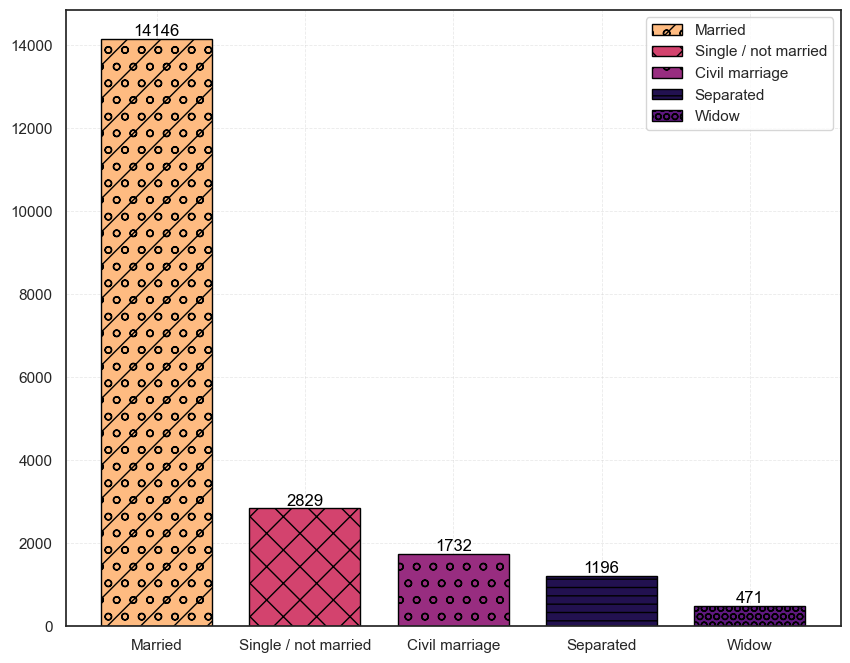

In [134]:
column_counts = original_df['family_status'].value_counts().reset_index()
column_counts.columns = ['family_status', 'value']

bar_plot_matplotlib(column_counts['family_status'], column_counts['value'],x_rotation=0)

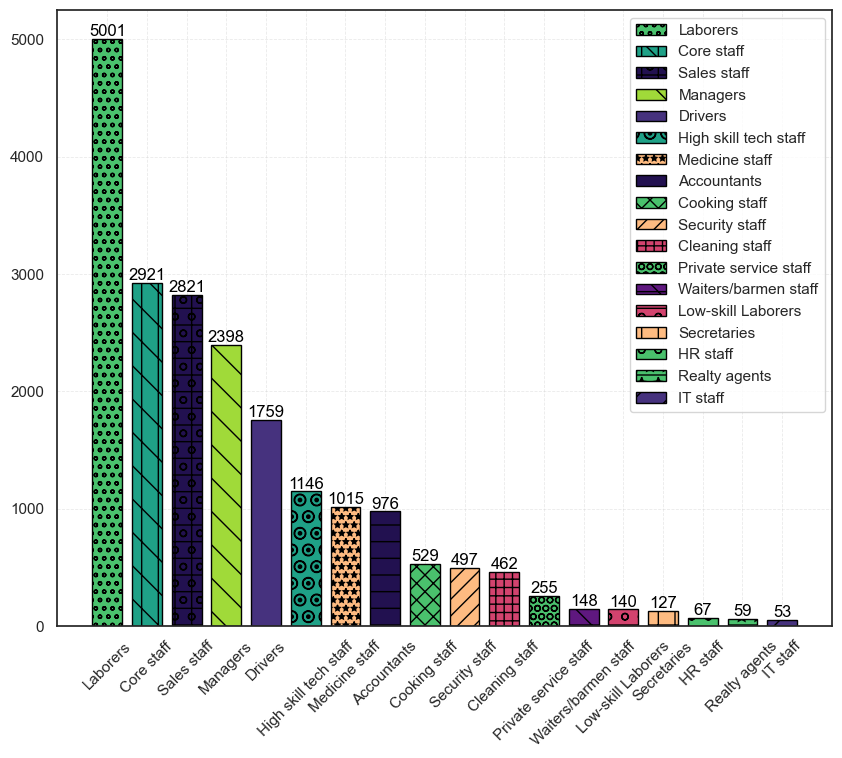

In [135]:
column_counts = original_df['occupation'].value_counts().reset_index()
column_counts.columns = ['occupation', 'value']

bar_plot_matplotlib(column_counts['occupation'], column_counts['value'],x_rotation=45)

## count plot

In [136]:
def count_plot(df: pd.DataFrame, 
               x: Optional[str] = None, 
               y: Optional[str] = None, 
               hue: Optional[str] = None,
               column_plot: Optional[str] = None,
               palette: str = 'magma', 
               edgecolor: str = 'black', 
               order: bool = False, 
               figsize: tuple = (8, 6), 
               ax: Optional[plt.Axes] = None) -> plt.Axes:
    """
    Creates a count plot with Seaborn.
    
    Parameters:
    ---------
    - df (pd.DataFrame): The DataFrame containing the data.
    - x (Optional[str]): The column to plot on the x-axis.
    - y (Optional[str]): The column to plot on the y-axis.
    - hue (Optional[str]): The column to use for color encoding.
    - column_plot (Optional[str]): The column to plot. If None, inferred from x or y.
    - palette (str): Color palette to use for the plot.
    - edgecolor (str): Color of the edges of the bars.
    - order (bool): Whether to order the bars by count.
    - figsize (tuple): Size of the figure.
    - stat (Literal['count', 'percent', 'proportion', 'probability']): Statistical representation to plot.
    - ax (Optional[plt.Axes]): Matplotlib Axes object to draw the plot onto, if None a new figure is created.
    
    Examples:
    --------
    >>> count_plot(tips,'size')
    >>> count_plot(tips ,y = 'day',order=True)
    
    Returns:
    -------
    - plt.Axes: The Axes object with the plot.
    """
    
    show = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        show = True
    
    # Infer column to plot if not provided
    if column_plot is None:
        if x is not None:
            column_plot = x
        elif y is not None:
            column_plot = y
        else:
            column_plot = df.iloc[:, -1].name
            x = column_plot

    
    # Validate column existence
    if column_plot not in df.columns:
        raise ValueError(f"The column '{column_plot}' does not exist in the DataFrame.")
    
    # Set default hue if not provided
    if hue is None:
        hue = column_plot
    
    # Determine order of the bars if specified
    order_list = df[column_plot].value_counts().index.tolist() if order else None
    
    # Plot the count plot
    sns.countplot(data=df, x=x, y=y, hue=hue, palette=palette, 
                  order=order_list, edgecolor=edgecolor, ax=ax)
    
    # Add percentages on the bars
    total = len(df[column_plot])
    if y is not None:  # Horizontal bars
        for p in ax.patches:
            width = p.get_width()
            percentage = f'{100 * width / total:.1f}%'
            ax.annotate(percentage, (width, p.get_y() + p.get_height() / 2.), 
                        ha='left', va='center', fontsize=12, color='black', xytext=(0, 0), 
                        textcoords='offset points')
    else:  # Vertical bars
        for p in ax.patches:
            height = p.get_height()
            percentage = f'{100 * height / total:.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 0), 
                        textcoords='offset points')
    
    # Set axis labels
    if x is not None:
        ax.set_xlabel(x, fontsize=14)
    elif y is not None:
        ax.set_ylabel(y, fontsize=14)
    else:
        ax.set_xlabel(column_plot, fontsize=14)
    
    # Set y-axis label based on stat
    y_label = 'Count'
    ax.set_ylabel(y_label, fontsize=14)
    
    # Set plot title
    ax.set_title(f'Count Plot of {column_plot}', fontsize=16)
    
    # Style the plot
    ax.grid(True, linestyle='--', linewidth=0.8, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)
    
    # Show plot if created within the function
    if show:
        plt.show()
    
    return ax



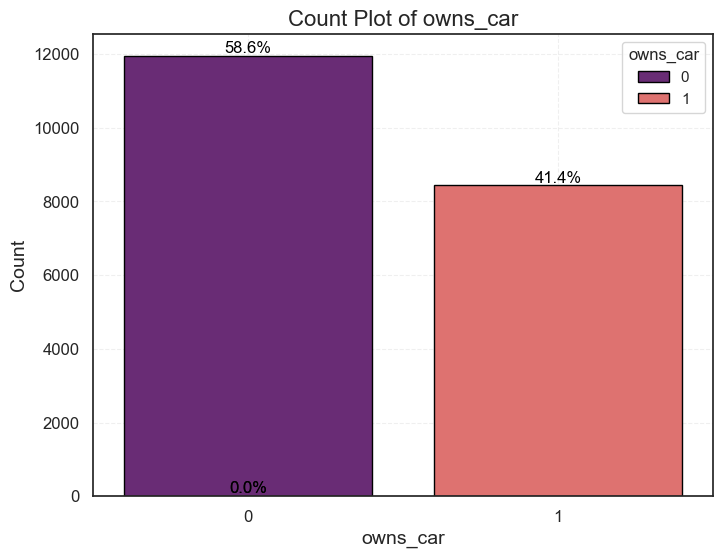

<Axes: title={'center': 'Count Plot of owns_car'}, xlabel='owns_car', ylabel='Count'>

In [137]:
count_plot(df=original_df , x='owns_car')

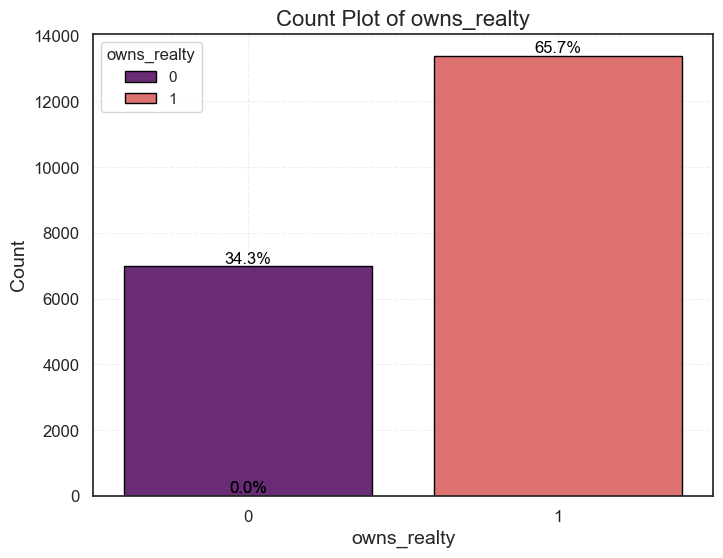

<Axes: title={'center': 'Count Plot of owns_realty'}, xlabel='owns_realty', ylabel='Count'>

In [138]:
count_plot(df=original_df , x='owns_realty')

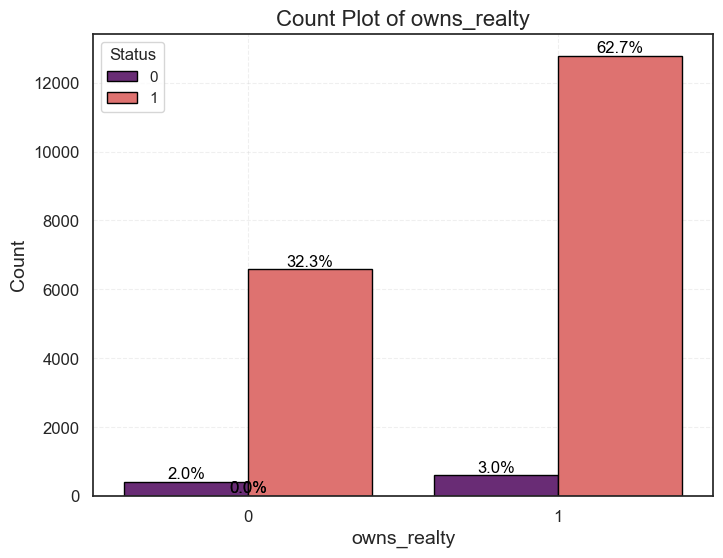

<Axes: title={'center': 'Count Plot of owns_realty'}, xlabel='owns_realty', ylabel='Count'>

In [139]:
count_plot(df=original_df , x='owns_realty' , hue='Status')

## Violin

In [140]:
def plot_violin_all_column(
    data,
    n_cols=3,
    figsize=(15, 15),
    Vision: Literal['Vertical', 'horizontal'] = "horizontal",
    palette="magma",
    palette2="viridis",
    inner="box",
    split=False,
    density_norm='area',
    linewidth=1,
    bw_method=0.2,
    gridsize=100,
    xlim=None,
    ylim=None,
    title="Violin Plots of Numeric Variables"
):
    """
    Creates violin plots for all numeric columns in the dataset using subplots.
    
    Parameters:
    ----------
    - data (DataFrame): Input dataframe.
    - n_cols (int): Number of columns in the subplot grid.
    - figsize (tuple): Figure size.
    - palette (str or list): Color palette to use for the plot.
    - inner (str): Representation of the datapoints in the violin interior.
    - split (bool): Whether to split the violins for easier comparison.
    - density_norm (str): Method for scaling the width of each violin.
    - linewidth (float): Width of the lines that will divide the violins.
    - bw_method (float): Bandwidth of the kernel density estimate.
    - gridsize (int): Number of points in the grid for the kernel density estimate.
    - xlim (tuple or None): Limits for the x-axis.
    - ylim (tuple or None): Limits for the y-axis.
    - title (str): Overall title for the figure.
    
    Examples:
    --------
    >>> plot_violin_all_column(penguins, n_cols=2, Vision='Vertical')
    >>> plot_violin_all_column(df, n_cols=3, Vision='horizontal')
    
    Returns:
    -------
    - matplotlib figure
    """
    # Select only numeric columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    n_plots = len(numeric_cols)
    
    # Calculate number of rows needed
    n_rows = (n_plots - 1) // n_cols + 1
    
    # get the color for each plot
    if n_plots <= 6 :
        colors = random.sample(sns.color_palette(palette), n_plots)
    elif n_plots <= 12 :
        colors = random.sample(sns.color_palette(palette) + sns.color_palette(palette2), n_plots)
    elif n_plots > 12 :
        colors = random.choices(sns.color_palette(palette) + sns.color_palette(palette2), k=n_plots)
    
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    if Vision == 'horizontal':
        for i, col in enumerate(numeric_cols):
            sns.violinplot(
                data=data,
                x=col,
                y=None,
                ax=axes[i],
                color=colors[i],
                inner=inner,
                split=split,
                density_norm=density_norm,
                linewidth=linewidth,
                bw_method=bw_method,
                gridsize=gridsize
            )
            axes[i].set_title(f'Violin Plot of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Value')
            
            # Set axis limits if provided
            if xlim:
                axes[i].set_xlim(xlim)
            if ylim:
                axes[i].set_ylim(ylim)
    elif Vision == 'Vertical':
        for i, col in enumerate(numeric_cols):
            sns.violinplot(
                data=data,
                x=None,
                y=col,
                ax=axes[i],
                color=colors[i],
                inner=inner,
                split=split,
                density_norm=density_norm,
                linewidth=linewidth,
                bw_method=bw_method,
                gridsize=gridsize
            )
            axes[i].set_title(f'Violin Plot of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Value')
            
            # Set axis limits if provided
            if xlim:
                axes[i].set_xlim(xlim)
            if ylim:
                axes[i].set_ylim(ylim)
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()




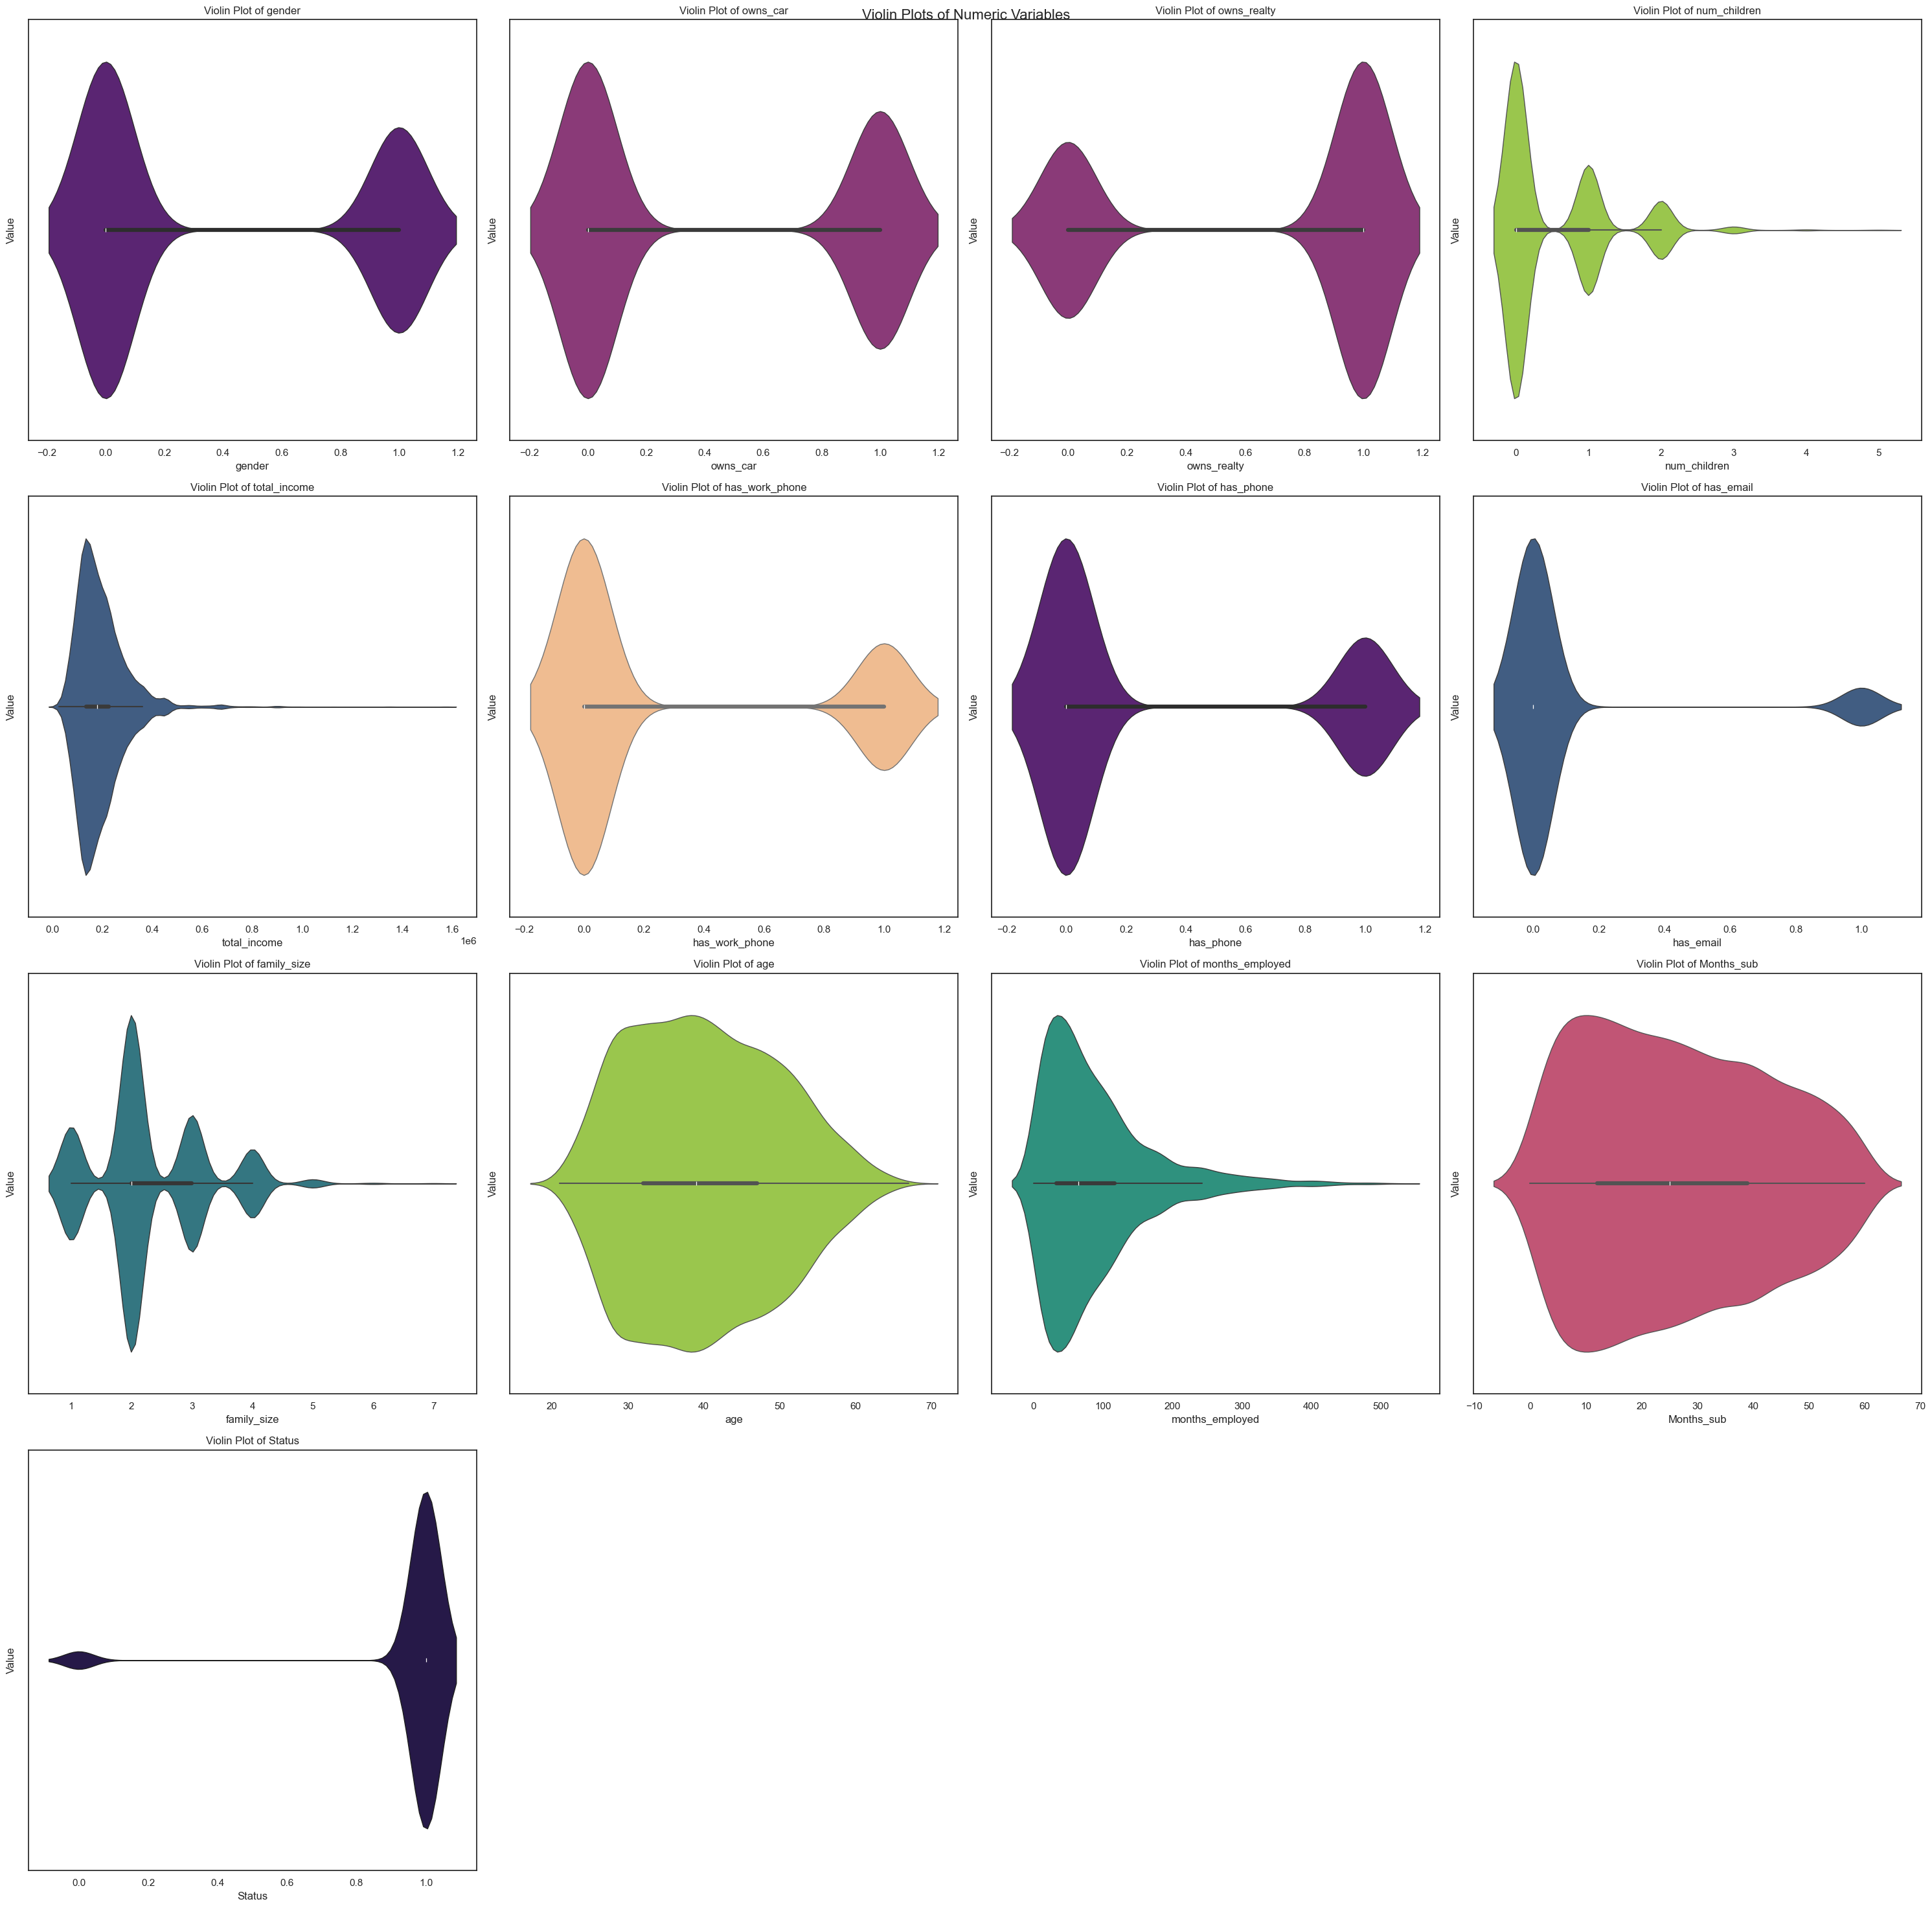

In [141]:
plot_violin_all_column(original_df, figsize=(30, 30), n_cols=4)

## Histogram

In [142]:
def plot_single_histogram_seaborn(df, x=None, y=None,hue=None, palette: str = 'viridis',color=None, kde:bool=True,bins=20, edgecolor='black', alpha=0.8, multiple: Literal['layer', 'dodge', 'stack', 'fill']='layer', orientation='vertical',legend_title=None,title=None, show=True) -> None:
        """Plot a histogram for a single column."""
        df= pd.DataFrame(df)
        if color is None:
                colors = random.sample(sns.color_palette(palette), 1)[0]
        else:
                colors = color
        plt.figure(figsize=(8, 6))
        sns.histplot(data=df, x=x, y=y, hue=hue,color=colors,kde=kde, bins=bins, edgecolor=edgecolor, alpha=alpha, multiple=multiple)
        plt.legend(legend_title if legend_title else ['hist'],loc='best')
        plt.title(title if title else 'hist', size=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if show:
            plt.show()



def plot_histograms(df: pd.DataFrame, column: Optional[Union[str, None]] = None, save_plots: bool = False, palette: str = 'magma',
                            bins: Optional[Union[int, list]] = 30, edgecolor: str = 'black', alpha: float = 0.9, kde: bool = True,
                            multiple: Literal['layer', 'dodge', 'stack', 'fill'] = 'layer', show = True, single_histogram_figsize = (8, 6), all_histograms_figsize = (14, 12)) -> None:
    """
    Plots histograms for numerical columns in the dataframe using Seaborn.
    
    Parameters:
    ----------
    df (pd.DataFrame): The input dataframe.
    column (Union[str, None], optional): The specific column to plot. If None, plot all numerical columns.
    save_plots (bool, optional): Whether to save the plots as images. Default is False.
    palette (str, optional): The color palette to use for the plots. Default is 'magma'.
    bins (Union[int, list], optional): Number of bins or bin edges for the histogram. Default is None.
    edgecolor (str, optional): Color of the edge of the bins. Default is 'black'.
    alpha (float, optional): Transparency level of the bins. Default is 0.9.
    kde (bool, optional): Whether to plot a KDE. Default is True.
    multiple (Literal['layer', 'dodge', 'stack', 'fill'], optional): How to plot multiple elements. Default is 'layer'.
    
    Examples:
    >>> plot_histograms_seaborn(penguins, bins=30)
    >>> plot_histograms_seaborn(penguins,"body_mass_g", bins=30)
    
    Returns:
    -------
    None
    """
    
    def plot_single_histogram(col_data: pd.Series, col_name: str, color: str) -> None:
        plt.figure(figsize=single_histogram_figsize)
        sns.histplot(col_data, kde=kde, color=color, bins=bins, edgecolor=edgecolor, alpha=alpha, multiple=multiple)
        plt.title(f"Histogram for {col_name}")
        plt.tight_layout()
        if save_plots:
            plt.savefig(f"histogram_{col_name}.png")
        plt.show()
    
    def plot_all_histograms(numerical_cols: pd.DataFrame) -> None:
        num_columns = len(numerical_cols.columns)
        ncols = int(np.ceil(np.sqrt(num_columns)))
        nrows = int(np.ceil(num_columns / ncols))
        colors = sns.color_palette(palette, num_columns)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=all_histograms_figsize)
        for index, col in enumerate(numerical_cols.columns):
            ax = axes.flatten()[index]
            sns.histplot(df[col], kde=kde, color=colors[index], bins=bins, edgecolor=edgecolor, alpha=alpha, multiple=multiple, ax=ax)
            ax.set_title(col)

        # Remove empty subplots
        for i in range(num_columns, nrows * ncols):
            fig.delaxes(axes.flatten()[i])

        plt.suptitle("Histograms of Numerical Columns", size=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save_plots:
            plt.savefig("all_histograms.png")
        if show:
            plt.show()
    
    try:
        num_cols = df.select_dtypes(include=['int64', 'float64']).columns
        cols_with_multiple_values = []
        for col in num_cols:
            if df[col].nunique() > 2:
                cols_with_multiple_values.append(col)
        
        numerical_columns = df[cols_with_multiple_values]
        
        if column is None or column.lower() == 'all':
            plot_all_histograms(numerical_columns)
        else:
            if column in numerical_columns.columns:
                color = sns.color_palette(palette, 1)[0]
                plot_single_histogram(df[column], column, color)
            else:
                print(f"Column '{column}' is not a numerical column in the dataframe.")
    except Exception as e:
        print(f"An error occurred: {e}")



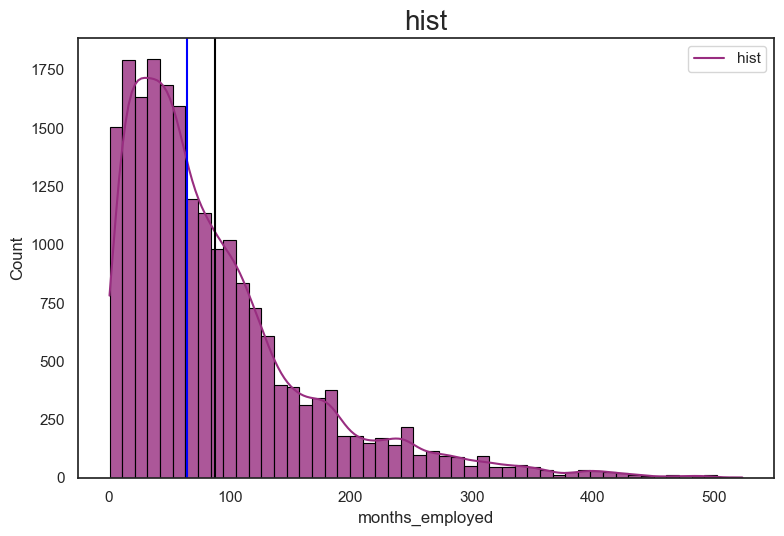

In [143]:
plot_single_histogram_seaborn(original_df,x='months_employed', bins=50, palette='magma', show=False)
plt.axvline(np.mean(original_df["months_employed"]) , color = "black" , label ="The Mean of the tenure")
plt.axvline(np.median(original_df["months_employed"]) , color = "blue" , label ="The Median of the tenure")
plt.show()

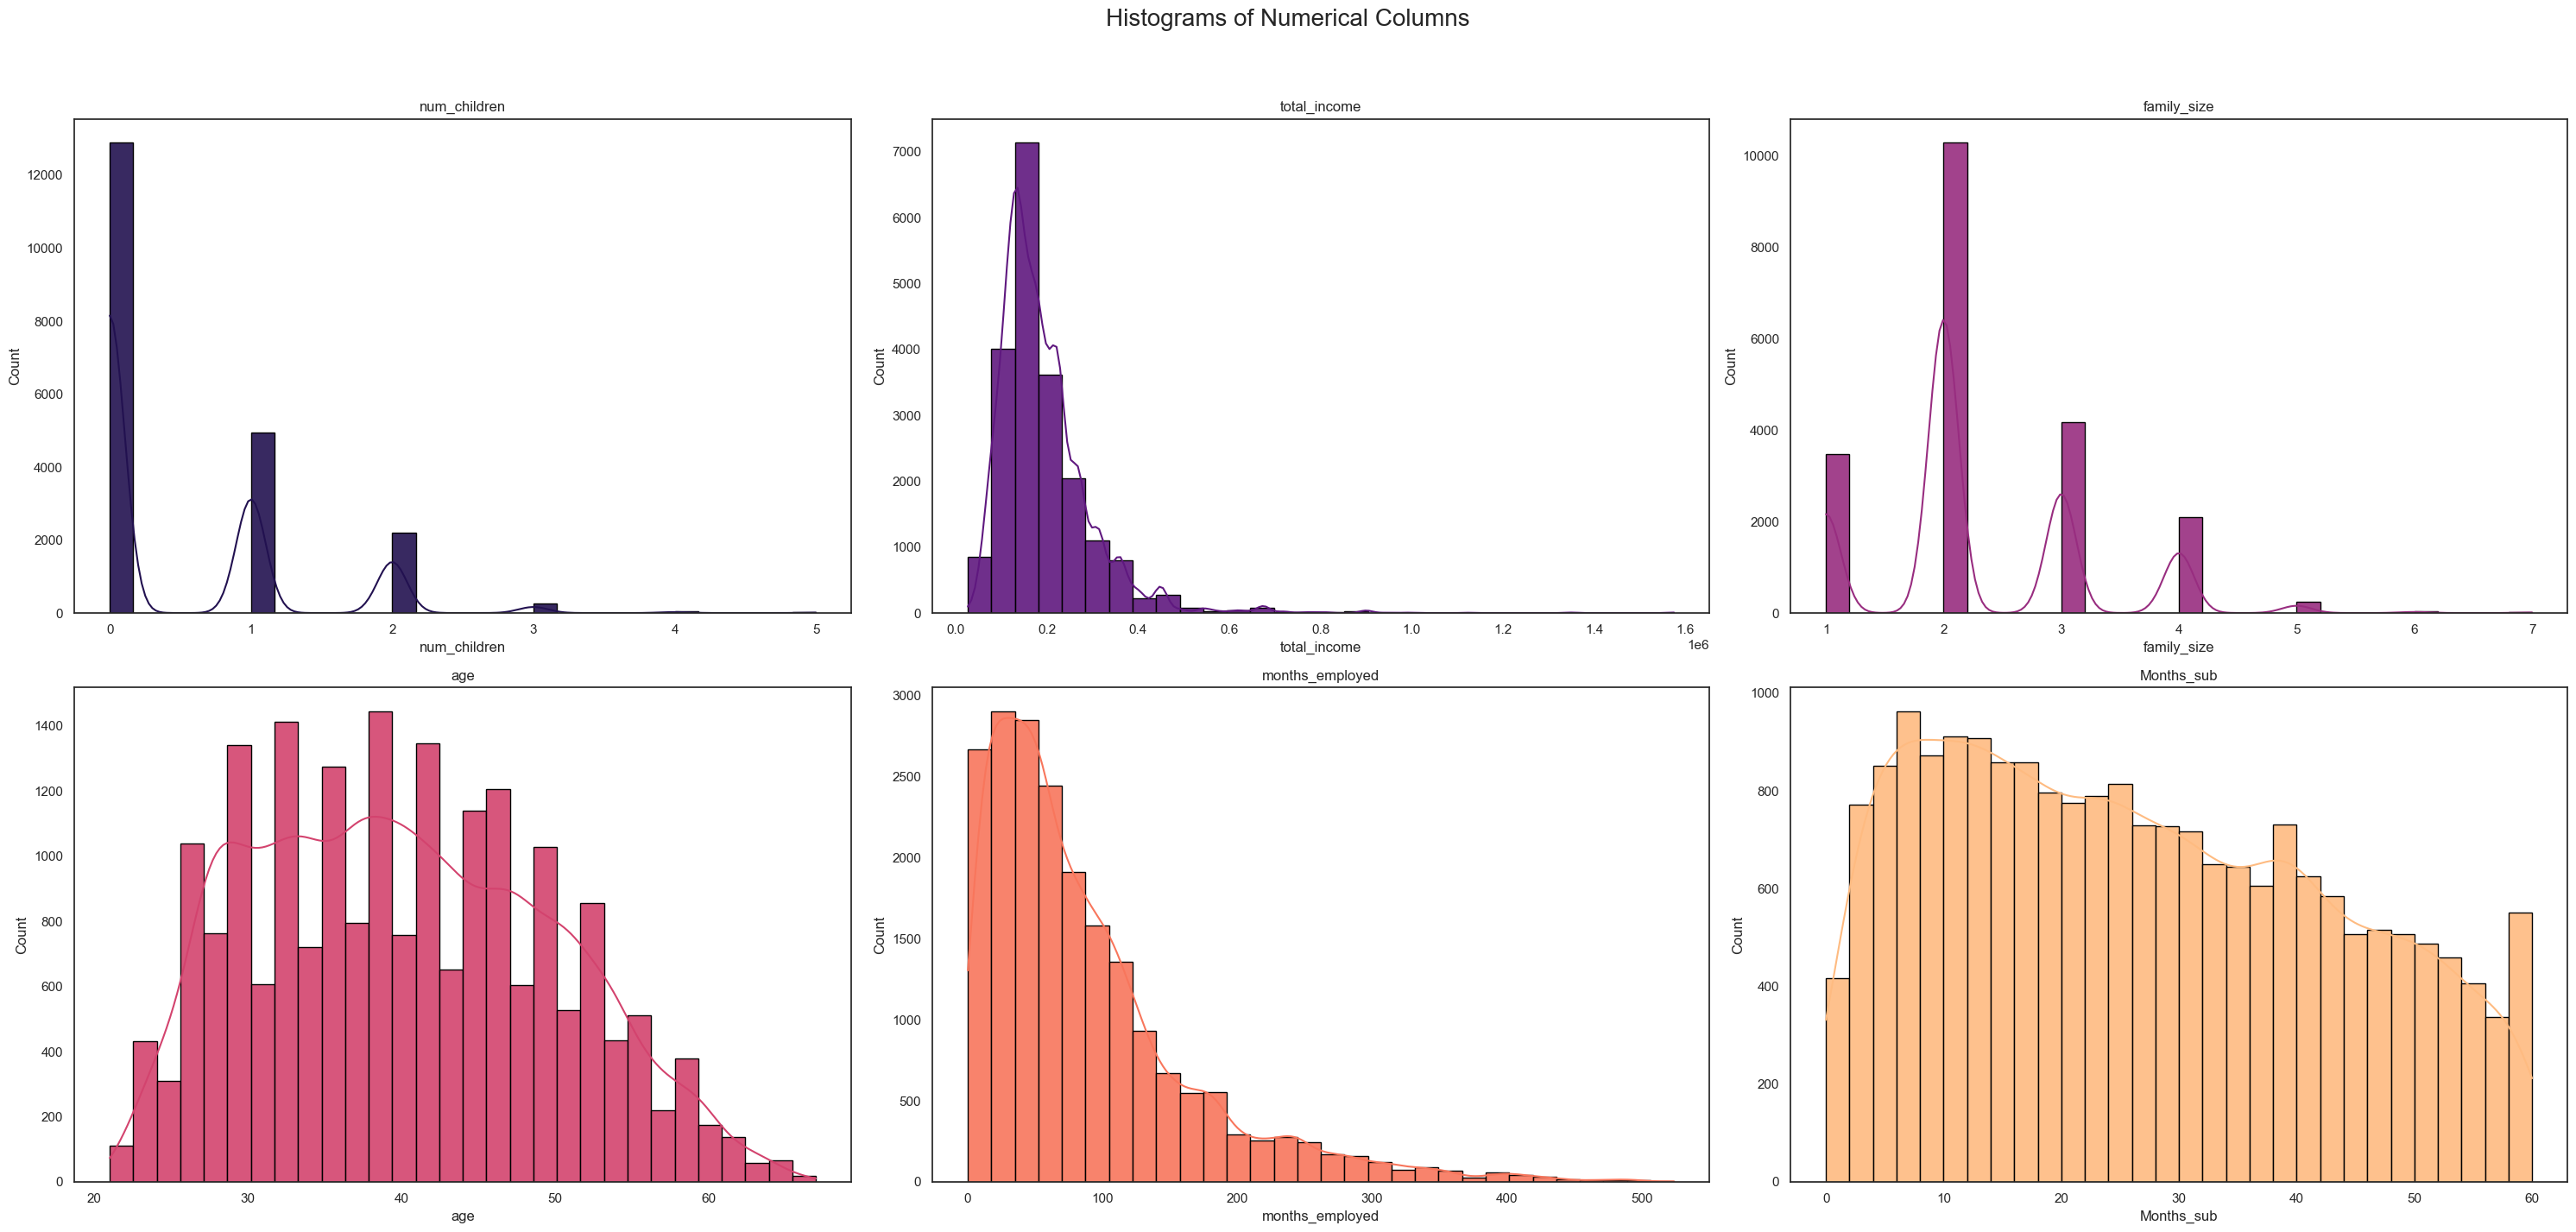

In [144]:
plot_histograms(original_df,column=None, bins=30, all_histograms_figsize = (30, 15))

# 7- Correlation Coefficient

In [145]:
def calculate_correlation(df: pd.DataFrame, outcome_column: Optional[str] = None, num_results: Optional[int] = 5) -> pd.DataFrame:
    """
    Calculates and prints the Pearson correlation coefficient and p-value for each numeric column in the DataFrame
    against the specified outcome column, ordered by the Pearson correlation coefficient.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing data.
    outcome_column (str): The name of the outcome column to calculate the correlation against.
    num_results (int, optional): The number of top results to display. If None, display all results.

    Returns:
    pd.DataFrame: A DataFrame containing the Pearson correlation coefficients and p-values for each numeric column.
    """
    if outcome_column is None:
        outcome_column = df.iloc[:, -1].name
    
    if outcome_column not in df.columns:
        raise ValueError(f"The column '{outcome_column}' does not exist in the DataFrame.")
    
    # Select numeric columns from the DataFrame
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
    
    # Ensure the outcome column is included in the numeric columns
    if outcome_column not in numeric_columns:
        raise ValueError(f"The outcome column '{outcome_column}' must be numeric and present in the DataFrame.")
    
    print('Calculating Pearson correlation coefficients for numeric columns against the outcome column: {outcome_column}')
    
    # Store the results
    results = []

    # Loop through each numeric column and calculate Pearson correlation
    for param in numeric_columns:
        if param != outcome_column:
            pearson_coef, p_value = stats.pearsonr(df[param].dropna(), df[outcome_column].dropna())
            results.append((param, pearson_coef, p_value))

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Variable', 'Pearson Coefficient', 'P-Value'])

    # Order the results by Pearson correlation coefficient
    results_df = results_df.reindex(results_df['Pearson Coefficient'].abs().sort_values(ascending=False).index)
    
    # Limit the number of results if num_results is specified
    if num_results is not None:
        results_df = results_df.head(num_results)
    
    print(f'Top {num_results if num_results is not None else len(results_df)} results:\n{results_df}')
    
    # Print the results
    for index, row in results_df.iterrows():
        print(f"\n{row['Variable']}")
        print(f"The Pearson Correlation Coefficient for {row['Variable']} is {row['Pearson Coefficient']:.4f} with a P-value of P = {row['P-Value']:.4g}")
    
    return results_df



def Heatmap_Correlation(df: pd.DataFrame, mask: float = 0.5, cmap="YlGnBu", adv_cmap = True,  save_path: Optional[str] = None, annot_size=10, figsize=(20, 14)) -> pd.DataFrame:
    """
    Generates a heatmap to visualize the correlation matrix of numeric columns in the given DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the data.
    mask (float, optional): Threshold to mask correlations below this absolute value. Default is 0.5.
    save_path (str, optional): Path to save the heatmap image. If None, the heatmap is not saved. Default is None.
    annot_size (int, optional): Font size for annotations. Default is 10.
    figsize (tuple, optional): Size of the figure. Default is (20, 14).

    Returns:
    pd.DataFrame: Correlation matrix of the numeric columns in the DataFrame.
    """
    # Select numeric columns from the DataFrame
    numeric_columns = df.select_dtypes(include=['int64', 'float64'])
    
    if numeric_columns.empty:
        raise ValueError("The DataFrame does not contain any numeric columns.")
    
    # Compute the correlation matrix
    correlations = numeric_columns.corr()
    
    # Create a mask to highlight correlations greater than 0.5 or less than -0.5
    mask = (correlations.abs() < mask)

    if adv_cmap:
        # Define two separate colormaps and combine them into one
        cmap_pos = sns.color_palette(cmap, as_cmap=True)             # Colormap for positive values
        cmap_neg = sns.color_palette(cmap, as_cmap=True).reversed()  # Colormap for negative values
        colors = cmap_neg(np.linspace(0, 1, 128))
        colors = np.vstack((colors, cmap_pos(np.linspace(0, 1, 128))))
        cmap_combined = LinearSegmentedColormap.from_list('CustomMap', colors)
    else:
        cmap_combined = cmap
    
    # Create a figure and axis for the heatmap
    plt.figure(figsize=figsize)
    
    # Create a heatmap with customization
    heatmap = sns.heatmap(
        data=correlations,
        annot=True,                     # Annotate cells with the data value
        fmt=".2f",                      # Format the annotations to 2 decimal places
        cmap=cmap_combined,             # Combined colormap
        cbar=True,                      # Show color bar
        cbar_kws={'label': 'Correlation'},    # Color bar customization
        linewidths=0.5,                 # Line width between cells
        linecolor='gray',               # Line color between cells
        square=True,                    # Force square cells
        mask=mask,                      # Mask correlations below the threshold
        annot_kws={"size": annot_size}, # Annotation font size 
        xticklabels=True,               # Show x-axis labels
        yticklabels=True,               # Show y-axis labels
        robust=True                     # Robust colormap limits
    )
    
    # Customize the plot
    plt.title('Heatmap of Correlation Matrix', fontsize=18, weight='bold', pad=20)
    plt.xlabel('Features', fontsize=14, weight='bold')
    plt.ylabel('Features', fontsize=14, weight='bold')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout for better fit
    plt.tight_layout()
    
    # Add grid lines for better readability
    plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.3)
    
    # Save the heatmap if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        logging.info('Heatmap saved to %s', save_path)
    
    # Display the heatmap
    plt.show()
    
    # Return the correlation matrix
    return correlations




## Calculate Correlation

In [146]:
calculate_correlation(classification_df, outcome_column=target_column_classification,num_results=5)

Calculating Pearson correlation coefficients for numeric columns against the outcome column: {outcome_column}
Top 5 results:
           Variable  Pearson Coefficient       P-Value
16       Months_sub             0.049921  5.035197e-15
14              age             0.037565  3.921646e-09
15  months_employed             0.034029  9.664752e-08
2       owns_realty             0.026242  3.921604e-05
1          owns_car             0.018772  3.268643e-03

Months_sub
The Pearson Correlation Coefficient for Months_sub is 0.0499 with a P-value of P = 5.035e-15

age
The Pearson Correlation Coefficient for age is 0.0376 with a P-value of P = 3.922e-09

months_employed
The Pearson Correlation Coefficient for months_employed is 0.0340 with a P-value of P = 9.665e-08

owns_realty
The Pearson Correlation Coefficient for owns_realty is 0.0262 with a P-value of P = 3.922e-05

owns_car
The Pearson Correlation Coefficient for owns_car is 0.0188 with a P-value of P = 0.003269


Variable  Pearson Coefficient       P-Value
16       Months_sub             0.049921  5.035197e-15
14              age             0.037565  3.921646e-09
15  months_employed             0.034029  9.664752e-08
2       owns_realty             0.026242  3.921604e-05
1          owns_car             0.018772  3.268643e-03

## Visualize Correlation with Heatmap

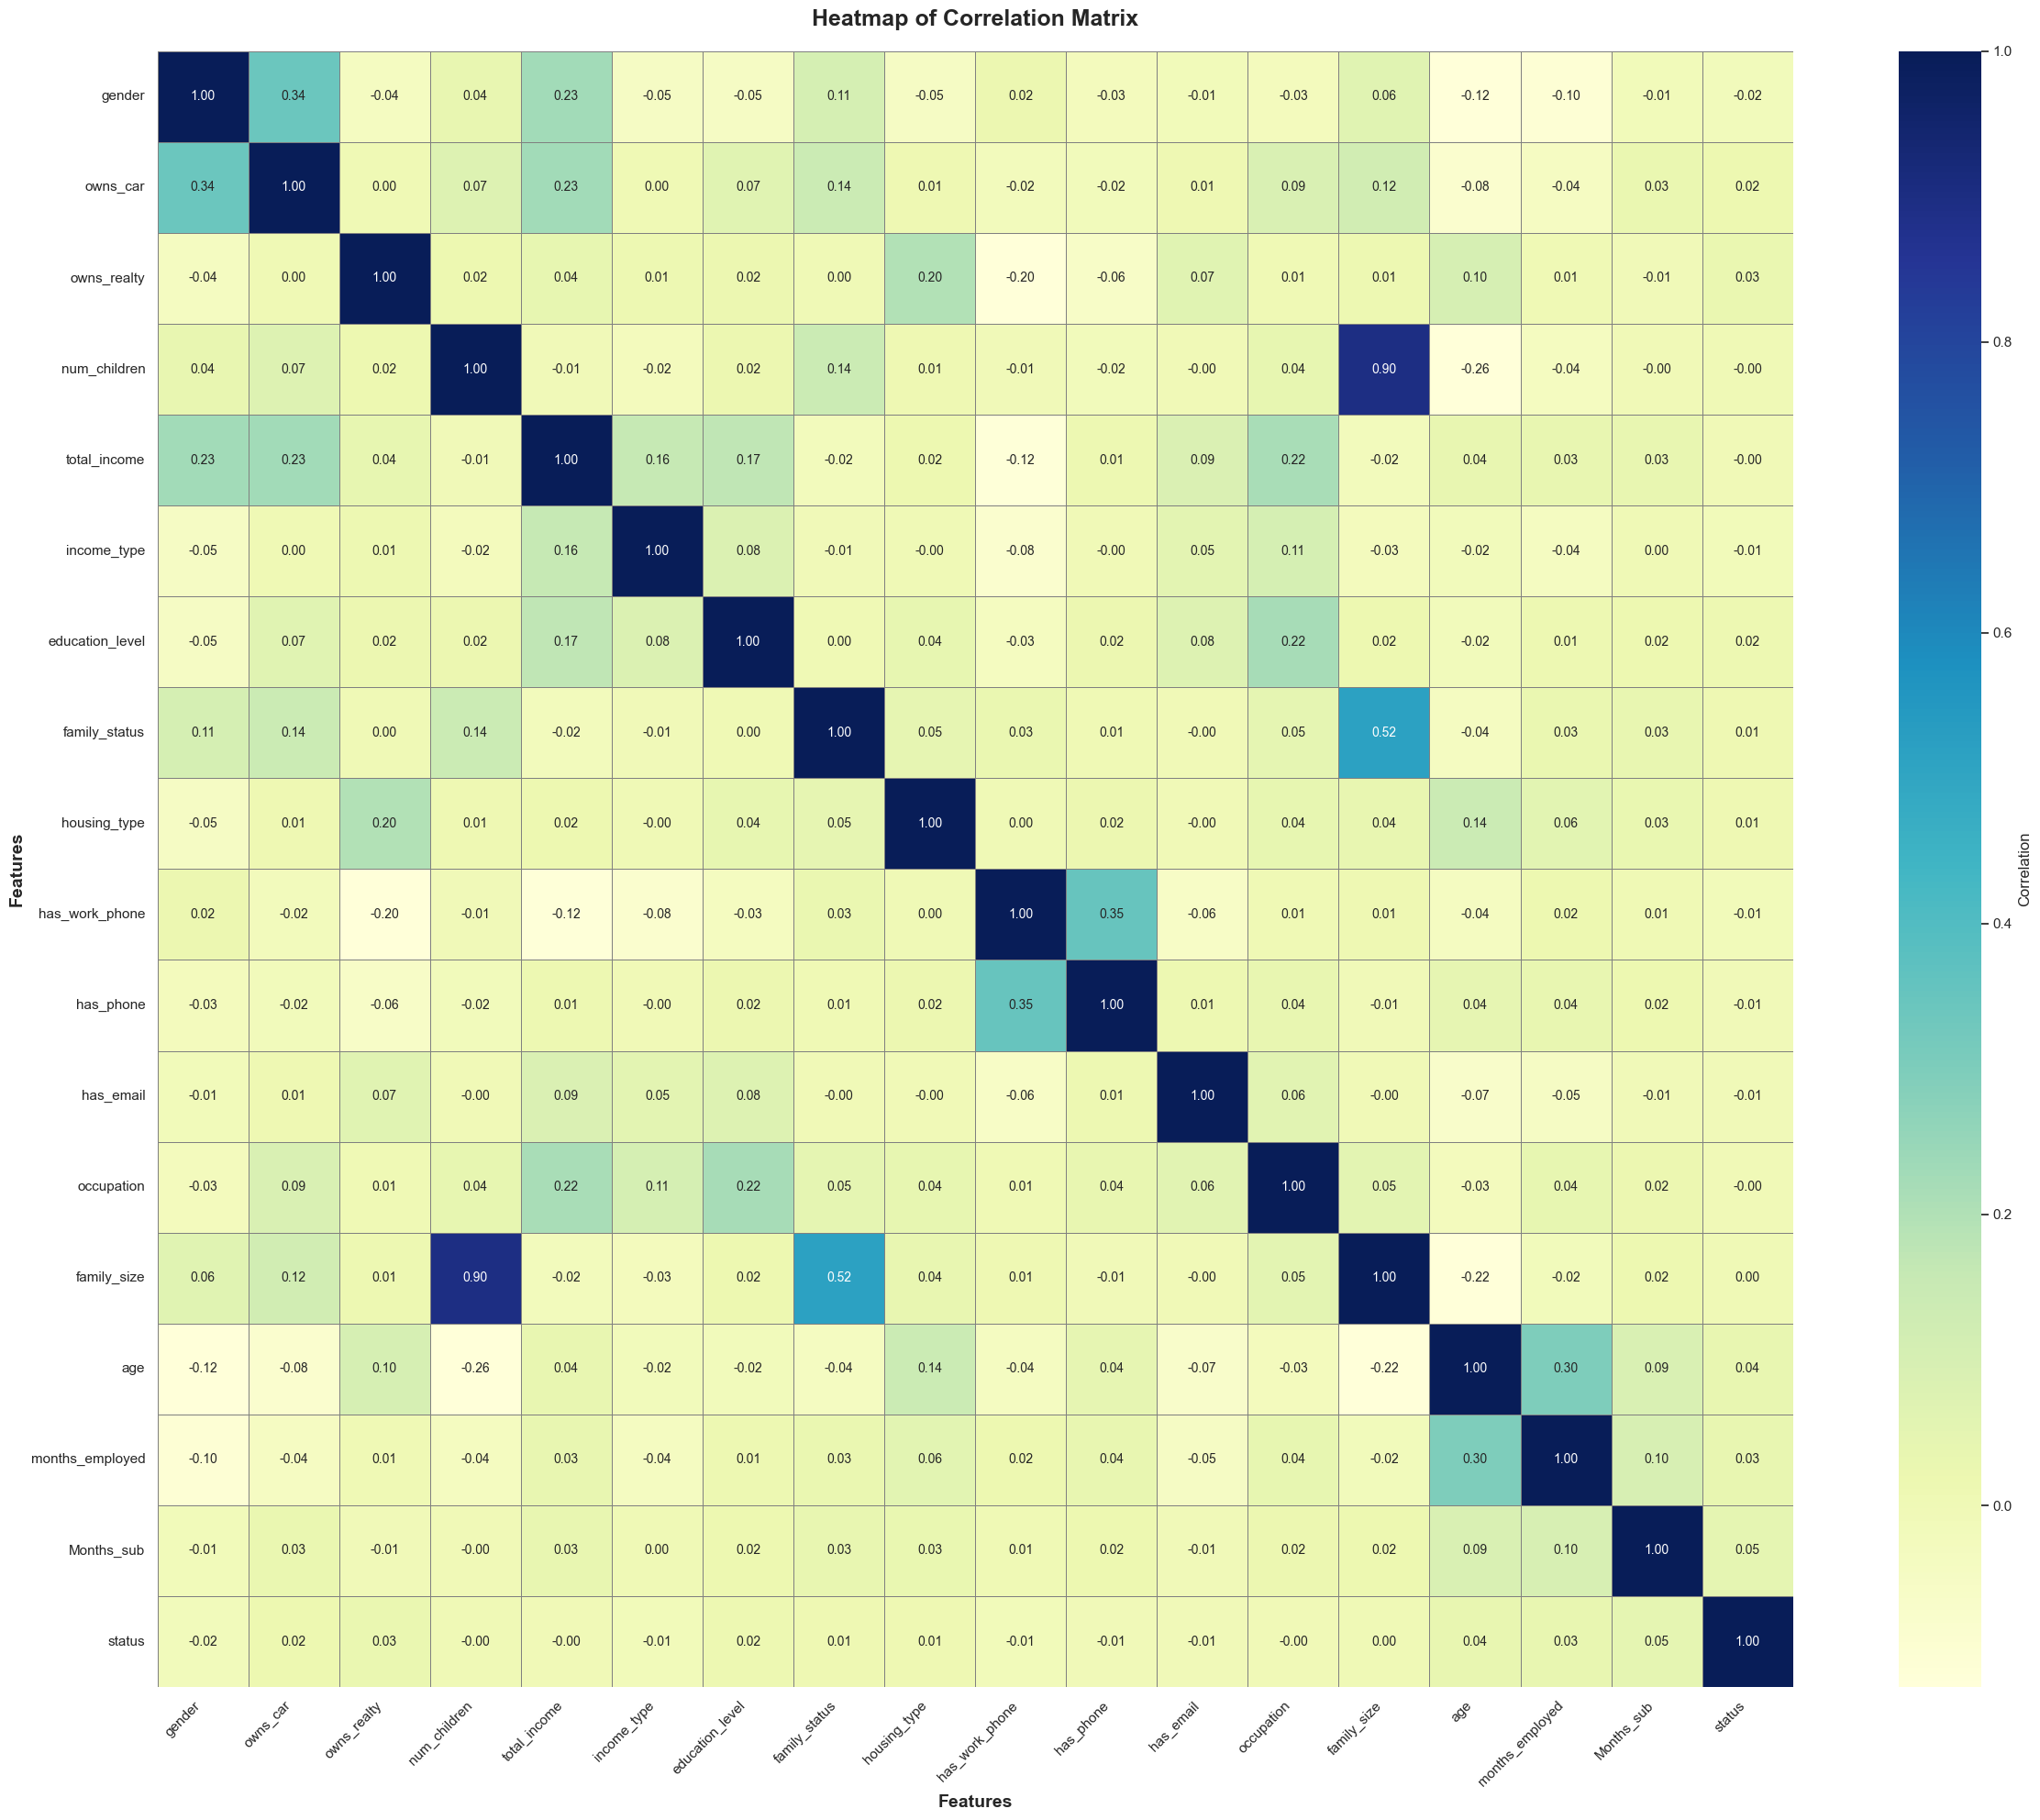

In [147]:
correlations = Heatmap_Correlation(classification_df, mask=0, cmap="YlGnBu", adv_cmap=False, save_path=None, annot_size = 10, figsize=(25, 20))

# 8- Repair unbalanced data by using oversampling and undersampling

In [148]:
def get_x_y(df,target:Optional[str] = None):
    if target == None:
        x=df.iloc[:,:-1]
        y=df.iloc[:,-1]
    else:
        x=df.drop(target,axis=1)
        y=df[target]
    return x,y



def over_under_sampling_classification(
    x: pd.DataFrame, 
    y: pd.Series, 
    over_sampling: Literal['SMOTE', 'SVMSMOTE', 'BorderlineSMOTE-1', 'BorderlineSMOTE-2', 'ADASYN', 'SMOTEN', 'SMOTENC', 'random_over_sampler'] = 'SVMSMOTE', 
    under_sampling: Literal['TomekLinks', 'EditedNearestNeighbours', 'RepeatedEditedNearestNeighbours', 'AllKNN', 'CondensedNearestNeighbour', 'ClusterCentroids', 'NearMiss', 'random_under_sampler'] = 'TomekLinks', 
    over_sampling_strategy= "auto", 
    under_sampling_strategy= "auto", 
    k_neighbors: int = 5, 
    random_state: int = 42, 
    categorical_features: Optional[list] = None, 
    over: bool = True, 
    under: bool = True,
    make_df: bool = True,
    n_jobs = -1
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    print(f'Starting over-sampling and/or under-sampling process.')
    print(f'Initial class distribution: {Counter(y)}')
    
    valid_over_sampling_strategies = [
        'random_over_sampler', 'SMOTE', 'SVMSMOTE', 'BorderlineSMOTE-1', 
        'BorderlineSMOTE-2', 'ADASYN', 'SMOTEN', 'SMOTENC'
    ]
    valid_under_sampling_strategies = [
        'random_under_sampler', 'TomekLinks', 'EditedNearestNeighbours', 'RepeatedEditedNearestNeighbours', 
        'AllKNN', 'CondensedNearestNeighbour', 'ClusterCentroids', 'NearMiss'
    ]
    
    if over and over_sampling not in valid_over_sampling_strategies:
        raise ValueError(f"Invalid over_sampling strategy '{over_sampling}' specified. "
                        f"Valid options are: {', '.join(valid_over_sampling_strategies)}")
    
    if under and under_sampling not in valid_under_sampling_strategies:
        raise ValueError(f"Invalid under_sampling strategy '{under_sampling}' specified. "
                        f"Valid options are: {', '.join(valid_under_sampling_strategies)}")
    
    print(f'\nuse {over_sampling} model for oversampling')
    
    # Over-sampling
    if over:
        if over_sampling == 'SMOTE':
            print(f'Applying SMOTE with strategy {over_sampling_strategy}')
            smote = SMOTE(sampling_strategy=over_sampling_strategy, random_state=random_state, k_neighbors=k_neighbors, n_jobs=n_jobs)
            x, y = smote.fit_resample(x, y)
        elif over_sampling == 'SVMSMOTE':
            print(f'Applying SVMSMOTE with strategy {over_sampling_strategy}')
            svmsmote = SVMSMOTE(sampling_strategy=over_sampling_strategy, random_state=random_state, n_jobs=n_jobs)
            x, y = svmsmote.fit_resample(x, y)
        elif over_sampling == 'BorderlineSMOTE-1':
            print(f'Applying BorderlineSMOTE(kind="borderline-1") with strategy {over_sampling_strategy}')
            bl1smote = BorderlineSMOTE(kind='borderline-1', sampling_strategy=over_sampling_strategy, random_state=random_state, n_jobs=n_jobs)
            x, y = bl1smote.fit_resample(x, y)
        elif over_sampling == 'BorderlineSMOTE-2':
            print(f'Applying BorderlineSMOTE(kind="borderline-2") with strategy {over_sampling_strategy}')
            bl2smote = BorderlineSMOTE(kind='borderline-2', sampling_strategy=over_sampling_strategy, random_state=random_state, n_jobs=n_jobs)
            x, y = bl2smote.fit_resample(x, y)
        elif over_sampling == 'ADASYN':
            print(f'Applying ADASYN with strategy {over_sampling_strategy}')
            adasyn = ADASYN(sampling_strategy=over_sampling_strategy, random_state=random_state, n_jobs=n_jobs)
            x, y = adasyn.fit_resample(x, y)
        elif over_sampling == 'SMOTEN':
            print(f'Applying SMOTEN with strategy {over_sampling_strategy}')
            smoten = SMOTEN(sampling_strategy=over_sampling_strategy, random_state=random_state, n_jobs=n_jobs)
            x, y = smoten.fit_resample(x, y)
        elif over_sampling == 'SMOTENC':
            if categorical_features is None:
                raise ValueError("categorical_features must be provided for SMOTENC")
            print(f'Applying SMOTENC with strategy {over_sampling_strategy}')
            smotenc = SMOTENC(categorical_features=categorical_features, sampling_strategy=over_sampling_strategy, random_state=random_state, n_jobs=n_jobs)
            x, y = smotenc.fit_resample(x, y)
        elif over_sampling == 'random_over_sampler':
            print(f'Applying RandomOverSampler with strategy {over_sampling_strategy}')
            ros = RandomOverSampler(sampling_strategy=over_sampling_strategy, random_state=random_state)
            x, y = ros.fit_resample(x, y)
            
    print(f'after oversampling class distribution: {Counter(y)}')
    print(f'\nuse {under_sampling} model for undersampling')
    # Under-sampling
    if under:
        if under_sampling == 'TomekLinks':
            print(f'Applying TomekLinks under-sampling.')
            tom = TomekLinks(n_jobs=n_jobs)
            x, y = tom.fit_resample(x, y)
        elif under_sampling == 'EditedNearestNeighbours':
            print(f'Applying EditedNearestNeighbours with strategy {under_sampling_strategy}')
            enn = EditedNearestNeighbours(sampling_strategy=under_sampling_strategy, n_neighbors=3, kind_sel='all', n_jobs=n_jobs)
            x, y = enn.fit_resample(x, y)
        elif under_sampling == 'RepeatedEditedNearestNeighbours':
            print(f'Applying RepeatedEditedNearestNeighbours with strategy {under_sampling_strategy}')
            renn = RepeatedEditedNearestNeighbours(sampling_strategy=under_sampling_strategy, n_neighbors=3, max_iter=100, kind_sel='all', n_jobs=n_jobs)
            x, y = renn.fit_resample(x, y)
        elif under_sampling == 'AllKNN':
            print(f'Applying AllKNN with strategy {under_sampling_strategy}')
            allknn = AllKNN(sampling_strategy=under_sampling_strategy, n_neighbors=3, kind_sel='all', allow_minority=True, n_jobs=n_jobs)
            x, y = allknn.fit_resample(x, y)
        elif under_sampling == 'CondensedNearestNeighbour':
            print(f'Applying CondensedNearestNeighbour with strategy {under_sampling_strategy}')
            cnn = CondensedNearestNeighbour(sampling_strategy=under_sampling_strategy, n_neighbors=1, random_state=random_state, n_jobs=n_jobs)
            x, y = cnn.fit_resample(x, y)
        elif under_sampling == 'ClusterCentroids':
            print(f'Applying ClusterCentroids with strategy {under_sampling_strategy}')
            cc = ClusterCentroids(sampling_strategy=under_sampling_strategy, random_state=random_state, voting='soft')
            x, y = cc.fit_resample(x, y)
        elif under_sampling == 'NearMiss':
            print(f'Applying NearMiss(version=1) with strategy {under_sampling_strategy}')
            nm = NearMiss(sampling_strategy=under_sampling_strategy, version=1, n_neighbors=3, n_jobs=n_jobs)
            x, y = nm.fit_resample(x, y)
        elif under_sampling == 'random_under_sampler':
            print(f'Applying RandomUnderSampler with strategy {under_sampling_strategy}')
            rus = RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=random_state)
            x, y = rus.fit_resample(x, y)
    
    print(f'after undersampling class distribution: {Counter(y)}')
    
    print(f'\nFinal class distribution: {Counter(y)}')
    print(f'Over-sampling and/or under-sampling process completed.')
    if make_df:
        x_resampled = pd.DataFrame(x, columns=x.columns)
        y_resampled = pd.Series(y, name=y.name)
        combined_df = pd.concat([x_resampled, y_resampled], axis=1)
        return combined_df, x_resampled, y_resampled
    else:
        return x, y



def check_balance_classification(df: pd.DataFrame, column_plot: Optional[str] = None, palette='magma', edgecolor='black', order: bool = True) -> pd.DataFrame:
    """
    This function takes a DataFrame and a column name, computes the value counts for that column,
    displays the counts as a small DataFrame, and creates a Seaborn count plot with customizations.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    column_plot (str, optional): The column name for which to compute and plot the value counts. If None,
                        the function will use the last column of the DataFrame.

    Returns:
    pandas.DataFrame: A DataFrame showing the value counts for the specified column.
    """
    if column_plot is None:
        column_plot = df.iloc[:, -1].name
    
    if column_plot not in df.columns:
        raise ValueError(f"The column '{column_plot}' does not exist in the DataFrame.")
    
    if order:
        order_list = df[column_plot].value_counts().index
    else:
        order_list = None
    
    # Compute value counts
    value_counts = df[column_plot].value_counts().to_frame()
    value_counts.rename(columns={column_plot: 'value_counts'}, inplace=True)
    value_counts.index.name = 'name'
    
    # Plot the count plot
    plt.figure(figsize=(8, 6))  # Set the figure size
    ax = sns.countplot(data=df, x=column_plot, hue=column_plot, palette=palette, 
                    order=order_list, edgecolor=edgecolor)
    
    # Add percentages on the bars
    total = len(df[column_plot])
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.xlabel(column_plot, fontsize=14)  # Set x-axis label with font size
    plt.ylabel('Count', fontsize=14)  # Set y-axis label with font size
    plt.title('Count Plot', fontsize=16)  # Set title with font size
    plt.grid(True, linestyle='--', linewidth=0.8, alpha=0.3)  # Add grid lines with custom style
    plt.xticks(fontsize=12)  # Set font size for x-axis ticks
    plt.yticks(fontsize=12)  # Set font size for y-axis ticks
    plt.show()
    
    return value_counts




In [149]:
x, y = get_x_y(classification_df, target_column_classification)

In [150]:
Counter(classification_df[target_column_classification])

Counter({1: 23353, 0: 1195})

In [151]:
classification_df, x, y = over_under_sampling_classification(x, y, over_sampling_strategy=0.65)

Starting over-sampling and/or under-sampling process.
Initial class distribution: Counter({1: 23353, 0: 1195})

use SVMSMOTE model for oversampling
Applying SVMSMOTE with strategy 0.65


  File "c:\Users\PC\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


after oversampling class distribution: Counter({1: 23353, 0: 8886})

use TomekLinks model for undersampling
Applying TomekLinks under-sampling.
after undersampling class distribution: Counter({1: 23144, 0: 8886})

Final class distribution: Counter({1: 23144, 0: 8886})
Over-sampling and/or under-sampling process completed.


### Check the unbalance data after repair 

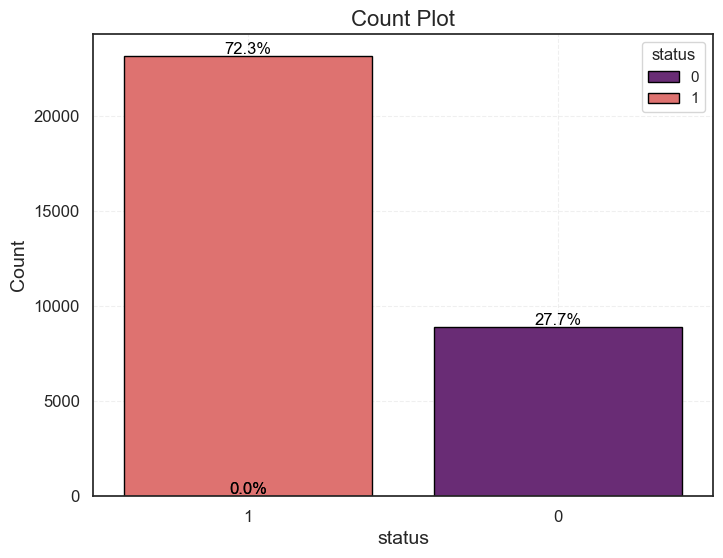

count
name       
1     23144
0      8886

In [152]:
check_balance_classification(classification_df,column_plot=target_column_classification)

# 9- Save and Call

## Save the final data

In [153]:
classification_df.to_csv('clean_Credit_Card_df.csv')

## Call clean_Credit_Card_df

In [3]:
classification_df = pd.read_csv('clean_Credit_Card_df.csv')
classification_df.drop(columns=['Unnamed: 0'], inplace=True)
target_column_classification = 'status'
print(classification_df.shape)
classification_df.head(3)

(32030, 18)


gender  owns_car  owns_realty  num_children  total_income  income_type  \
0       1         1            1             0      6.007459            2   
1       1         1            1             0      6.007459            2   
2       1         1            1             0      5.765550            2   

   education_level  family_status  housing_type  has_work_phone  has_phone  \
0                3              3             0               1          0   
1                3              3             0               1          0   
2                2              4             5               0          0   

   has_email  occupation  family_size  age  months_employed  Months_sub  \
0          0          17            2   32         8.421503          15   
1          0          17            2   32         8.421503          14   
2          0           9            2   58         5.286791          29   

   status  
0       1  
1       1  
2       1

In [4]:
classification_df.columns

Index(['gender', 'owns_car', 'owns_realty', 'num_children', 'total_income',
       'income_type', 'education_level', 'family_status', 'housing_type',
       'has_work_phone', 'has_phone', 'has_email', 'occupation', 'family_size',
       'age', 'months_employed', 'Months_sub', 'status'],
      dtype='object')

In [6]:
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32030 entries, 0 to 32029
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           32030 non-null  int64  
 1   owns_car         32030 non-null  int64  
 2   owns_realty      32030 non-null  int64  
 3   num_children     32030 non-null  int64  
 4   total_income     32030 non-null  float64
 5   income_type      32030 non-null  int64  
 6   education_level  32030 non-null  int64  
 7   family_status    32030 non-null  int64  
 8   housing_type     32030 non-null  int64  
 9   has_work_phone   32030 non-null  int64  
 10  has_phone        32030 non-null  int64  
 11  has_email        32030 non-null  int64  
 12  occupation       32030 non-null  int64  
 13  family_size      32030 non-null  int64  
 14  age              32030 non-null  int64  
 15  months_employed  32030 non-null  float64
 16  Months_sub       32030 non-null  int64  
 17  status      

# 10- Preprocessing

## 1- Split the data

In [155]:
def get_x_y(df,target:Optional[str] = None):
    if target == None:
        x=df.iloc[:,:-1]
        y=df.iloc[:,-1]
    else:
        x=df.drop(target,axis=1)
        y=df[target]
    return x,y


def get_x_y_TVT(df: pd.DataFrame, target: Optional[str] = None, test_size: float = 0.2, valid_size: float = 0.12, stratify: bool = False, shuffle: bool = True, random_state: Optional[int] = 42) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits the dataframe into training, validation, and test sets.
    
    Parameters:
    df (pd.DataFrame): The input dataframe.
    target (Optional[str]): The target column. If None, the last column is used as the target.
    test_size (float): The proportion of the dataset to include in the test split. Default is 0.2.
    train_size (float): The proportion of the dataset to include in the train split. Default is 0.8.
    valid_size (float): The proportion of the training dataset to include in the validation split. Default is 0.12.
    stratify (bool): Whether to stratify based on the target column. Default is False.
    shuffle (bool): Whether or not to shuffle the data before splitting. Default is True.
    random_state (Optional[int]): Controls the shuffling applied to the data before splitting. Pass an int for reproducible output. Default is 42.
    
    Returns:
    Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: Returns x_train, y_train, x_valid, y_valid, x_test, y_test.
    """
    
    def split_data_TVT(df: pd.DataFrame, target: Optional[str], test_size: float, valid_size: float, stratify: bool, shuffle: bool, random_state: Optional[int]) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
        """Splits the data into training, validation, and test sets."""
        x, y = extract_features_and_target(df, target)
        stratify_col = None
        if stratify:
            if y.nunique() < 20:  # This is a simple heuristic; you might want to adjust it
                stratify_col = y
            else:
                print("Stratification is not applicable for regression data. Continuing without stratification.")
                stratify = False
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=stratify_col, shuffle=shuffle, random_state=random_state)
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_size, shuffle=shuffle, random_state=random_state)
        return x_train, y_train, x_valid, y_valid, x_test, y_test
    
    def extract_features_and_target(df: pd.DataFrame, target: Optional[str]) -> Tuple[pd.DataFrame, pd.Series]:
        """Extracts features and target from the dataframe."""
        if target is None:
            x = df.iloc[:, :-1]
            y = df.iloc[:, -1]
        else:
            x = df.drop(target, axis=1)
            y = df[target]
        return x, y

    try:
        return split_data_TVT(df, target, test_size, valid_size, stratify, shuffle, random_state)
    except Exception as e:
        raise ValueError(f"An error occurred while splitting the data: {e}")


def get_x_y_TVT_shape(x_train: pd.DataFrame, y_train: pd.Series, x_valid: pd.DataFrame, y_valid: pd.Series, x_test: pd.DataFrame, y_test: pd.Series) -> None:
    """
    Prints the shapes of training, validation, and test datasets.

    Parameters:
    x_train (pd.DataFrame): The training features.
    y_train (pd.Series): The training labels.
    x_valid (pd.DataFrame): The validation features.
    y_valid (pd.Series): The validation labels.
    x_test (pd.DataFrame): The test features.
    y_test (pd.Series): The test labels.

    Returns:
    None
    """
    
    def print_shape(data: pd.DataFrame, label: str) -> None:
        """Prints the shape of a given dataset."""
        print(f'{label} shape = {data.shape}')
    
    try:
        print_shape(x_train, 'x_train')
        print_shape(x_valid, 'x_valid')
        print_shape(x_test, 'x_test')
        print_shape(y_train, 'y_train')
        print_shape(y_valid, 'y_valid')
        print_shape(y_test, 'y_test')
    except Exception as e:
        raise ValueError(f"An error occurred while printing shapes: {e}")



In [156]:
x,y = get_x_y(classification_df,target_column_classification)

In [157]:
x_train, y_train, x_valid, y_valid, x_test, y_test = get_x_y_TVT(classification_df, target=target_column_classification)

In [158]:
get_x_y_TVT_shape(x_train, y_train, x_valid, y_valid, x_test, y_test)

x_train shape = (22549, 17)
x_valid shape = (3075, 17)
x_test shape = (6406, 17)
y_train shape = (22549,)
y_valid shape = (3075,)
y_test shape = (6406,)


## 1- Feature Selection

In [159]:
# before feature selection
print(len(x.columns))
x.columns

17


Index(['gender', 'owns_car', 'owns_realty', 'num_children', 'total_income',
       'income_type', 'education_level', 'family_status', 'housing_type',
       'has_work_phone', 'has_phone', 'has_email', 'occupation', 'family_size',
       'age', 'months_employed', 'Months_sub'],
      dtype='object')

In [160]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Perform RFE
rfe = RFE(estimator=model, n_features_to_select=11)
rfe.fit(x_train, y_train)

# Save RFE model to pickle
with open('pickle/rfe_model.pkl', 'wb') as file:
    pickle.dump(rfe, file)
print("RFE model saved to 'pickle/rfe_model.pkl'.")

# Transform datasets
x_train_selected = rfe.transform(x_train)
x_valid_selected = rfe.transform(x_valid)
x_test_selected = rfe.transform(x_test)

# Get selected features
selected_features = x_train.columns[rfe.support_].tolist()

# Save selected features to pickle
with open('pickle/selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)
print("Selected features saved to 'pickle/selected_features.pkl'.")

# Keep only selected features in the original DataFrame
x = x[selected_features]


RFE model saved to 'pickle/rfe_model.pkl'.
Selected features saved to 'pickle/selected_features.pkl'.


In [161]:
# after feature selection
print(len(x.columns))
selected_features

11


['owns_car',
 'owns_realty',
 'total_income',
 'income_type',
 'education_level',
 'family_status',
 'occupation',
 'family_size',
 'age',
 'months_employed',
 'Months_sub']

## 2- Scaling

In [162]:
def scale_data(x_train: Union[np.ndarray, pd.DataFrame], 
               x_test: Union[np.ndarray, pd.DataFrame], 
               x_valid: Optional[Union[np.ndarray, pd.DataFrame]] = None, 
               scaler_type: Literal['standard', 'minmax', 'robust', 'maxabs', 'quantile', 'power', 'l2', 'log'] = 'standard',
               save_scaler_path: Optional[str] = 'pickle/scaler.pkl') -> Union[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """
    Scales the input data using the specified scaler type and saves the scaler to a pickle file.
    
    Parameters:
    x_train (Union[np.ndarray, pd.DataFrame]): Training data.
    x_test (Union[np.ndarray, pd.DataFrame]): Test data.
    x_valid (Optional[Union[np.ndarray, pd.DataFrame]]): Validation data (optional).
    scaler_type (str): Type of scaler to use ('standard', 'minmax', 'robust', 'maxabs', 'quantile', 'power', 'l2', 'log'). Default is 'standard'.
    save_scaler_path (Optional[str]): Path to save the fitted scaler as a pickle file. Default is 'pickle/scaler.pkl'.
    
    Returns:
    Union[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray, np.ndarray]]: Returns the scaled (x_train, x_test) if x_valid is not provided,
    otherwise returns (x_train, x_valid, x_test).
    """
    
    def get_scaler(scaler_type: str, n_samples: int):
        """Returns the scaler object based on the scaler type."""
        if scaler_type == 'standard':
            return StandardScaler()
        elif scaler_type == 'minmax':
            return MinMaxScaler()
        elif scaler_type == 'robust':
            return RobustScaler()
        elif scaler_type == 'maxabs':
            return MaxAbsScaler()
        elif scaler_type == 'quantile':
            return QuantileTransformer(output_distribution='uniform', n_quantiles=min(n_samples, 1000))
        elif scaler_type == 'power':
            return PowerTransformer(method='yeo-johnson')
        elif scaler_type == 'l2':
            return Normalizer(norm='l2')
        elif scaler_type == 'log':
            return None  # Log transformation handled separately
        else:
            raise ValueError(f"Unknown scaler_type: {scaler_type}")

    def log_transform(*arrays):
        """Applies log transformation to the given arrays."""
        return tuple(np.log1p(array) for array in arrays)
    
    try:
        n_samples = x_train.shape[0]
        scaler = get_scaler(scaler_type, n_samples)
        
        if scaler_type == 'log':
            if x_valid is None:
                return log_transform(x_train, x_test)
            else:
                return log_transform(x_train, x_valid, x_test)
        
        # Fit the scaler on the training data
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)
        
        # Save the scaler to pickle
        if save_scaler_path:
            os.makedirs(os.path.dirname(save_scaler_path), exist_ok=True)
            with open(save_scaler_path, 'wb') as file:
                pickle.dump(scaler, file)
            print(f"Scaler saved to '{save_scaler_path}'.")
        
        if x_valid is not None:
            x_valid_scaled = scaler.transform(x_valid)
            return x_train_scaled, x_test_scaled, x_valid_scaled
        else:
            return x_train_scaled, x_test_scaled
    
    except Exception as e:
        raise ValueError(f"An error occurred while scaling the data: {e}")




In [163]:
x_train, x_valid, x_test = scale_data(x_train_selected, x_valid_selected, x_test_selected)

Scaler saved to 'pickle/scaler.pkl'.


# 11- Train

In [164]:
def get_cross_validator(cv_type: Literal['KFold', 'StratifiedKFold', 'LeaveOneOut', 'LeavePOut', 'RepeatedKFold', 'TimeSeriesSplit'] = 'KFold', 
                        cv=5, shuffle=True, random_state=42, LeavePOut_p=2, RepeatedKFold_n_repeats=10):
    if cv_type == 'KFold':
        type_cross_valid = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
    elif cv_type == 'StratifiedKFold':
        type_cross_valid = StratifiedKFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
    elif cv_type == 'LeaveOneOut':
        type_cross_valid = LeaveOneOut()
    elif cv_type == 'LeavePOut':
        type_cross_valid = LeavePOut(p=LeavePOut_p)
    elif cv_type == 'RepeatedKFold':
        type_cross_valid = RepeatedKFold(n_splits=cv, n_repeats=RepeatedKFold_n_repeats, random_state=random_state)
    elif cv_type == 'TimeSeriesSplit':
        type_cross_valid = TimeSeriesSplit(n_splits=cv)
    else:
        raise ValueError("Invalid cv_type. Choose from 'KFold', 'StratifiedKFold', 'LeaveOneOut', 'LeavePOut', 'RepeatedKFold', 'TimeSeriesSplit'.")
    return type_cross_valid




In [165]:
models_names = ['XGBoost', 'RandomForest', 'LightGBM', 'CatBoost', 'DeepLearning']
models_values = [None, None, None, None, None]
have_overfitting = [None, None, None, None, None]

In [166]:
type_cross_valid = get_cross_validator(cv_type='StratifiedKFold', cv=5)

## XGBoost

### Grid Search

In [167]:
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# param_grid = {
#                 'n_estimators': [50, 100, 200, 300],
#                 'learning_rate': [0.01, 0.1, 0.2],
#                 'max_depth': [3, 5, 7, 10],
#                 'min_child_weight': [1, 3, 5],
#                 'gamma': [0, 0.1, 0.2],
#                 'subsample': [0.6, 0.8, 1.0],
#                 'colsample_bytree': [0.8, 1.0, 1.2]
#             }

# XGB_grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring='f1',
#     cv=type_cross_valid,
#     verbose=2,
#     n_jobs=-1
# )

In [168]:
# # Fit GridSearchCV
# print("Starting GridSearchCV...")
# XGB_grid_search.fit(x_train, y_train)

In [169]:
# best_params = XGB_grid_search.best_params_
# best_score = XGB_grid_search.best_score_
# print('best_params =',best_params)
# print('best_score =',best_score)



In [ ]:
# best_score = 0.8630508739745861

# formatted_text = ', \n'.join(
#     f"{key} = '{value}'" if isinstance(value, str) else f"{key} = {value}"
#     for key, value in best_params.items()
# )
# print(f'({formatted_text})')

In [170]:
# XGBoost_model = XGB_grid_search.best_estimator_
# XGBoost_model

### Normal Train

In [171]:
XGBoost_model = XGBClassifier(
    n_estimators=500, 
    max_depth=8, 
    learning_rate=0.05, 
    gamma=0.2, 
    min_child_weight=5, 
    subsample=0.7, 
    colsample_bytree=0.7, 
    reg_alpha=0.1, 
    reg_lambda=1, 
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42
)

XGBoost_model.fit(
    x_train, y_train, 
    eval_set=[(x_valid, y_valid)], 
    early_stopping_rounds=20, 
    verbose=True
)

[0]	validation_0-logloss:0.57516
[1]	validation_0-logloss:0.56507
[2]	validation_0-logloss:0.55602
[3]	validation_0-logloss:0.54650
[4]	validation_0-logloss:0.53846
[5]	validation_0-logloss:0.53089
[6]	validation_0-logloss:0.52418
[7]	validation_0-logloss:0.51696
[8]	validation_0-logloss:0.50837
[9]	validation_0-logloss:0.50203
[10]	validation_0-logloss:0.49591
[11]	validation_0-logloss:0.49067
[12]	validation_0-logloss:0.48511
[13]	validation_0-logloss:0.47969
[14]	validation_0-logloss:0.47409
[15]	validation_0-logloss:0.46919
[16]	validation_0-logloss:0.46441
[17]	validation_0-logloss:0.45987
[18]	validation_0-logloss:0.45564
[19]	validation_0-logloss:0.45152
[20]	validation_0-logloss:0.44815
[21]	validation_0-logloss:0.44369
[22]	validation_0-logloss:0.43896
[23]	validation_0-logloss:0.43476
[24]	validation_0-logloss:0.43186
[25]	validation_0-logloss:0.42845
[26]	validation_0-logloss:0.42519
[27]	validation_0-logloss:0.42157
[28]	validation_0-logloss:0.41872
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Check Overfitting

In [172]:
def Check_Overfitting_Classification(
    model,
    x: np.ndarray,
    y: np.ndarray,
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_valid: np.ndarray,
    y_valid: np.ndarray,
    learning_curve_scoring: Literal['accuracy', 'precision', 'recall', 'f1', 'roc_auc'] = 'accuracy',
    cv_type: Literal['KFold', 'StratifiedKFold', 'LeaveOneOut', 'LeavePOut', 'RepeatedKFold', 'TimeSeriesSplit'] = 'KFold',
    cv: int = 5,
    cv_scoring: Literal['accuracy', 'precision', 'recall', 'f1', 'roc_auc'] = 'accuracy',
    shuffle: bool = True,
    LeavePOut_p: int = 2,
    RepeatedKFold_n_repeats: int = 10,
    random_state: int = 42,
    n_jobs = -1,
    plot: bool = True
) -> Dict[str, Any]:
    """
    Evaluate the performance of a model to check for overfitting.

    Parameters:
    - model: The machine learning model to evaluate.
    - x: Feature set for cross-validation.
    - y: Target set for cross-validation.
    - x_train: Training feature set.
    - y_train: Training target set.
    - x_valid: Validation feature set.
    - y_valid: Validation target set.
    - learning_curve_scoring: Scoring metric for learning curve (default is 'accuracy').
    - cv_type: Type of cross-validation ('KFold', 'StratifiedKFold', 'LeaveOneOut', 'LeavePOut', 'RepeatedKFold', 'TimeSeriesSplit').
    - cv: Number of cross-validation folds (default is 5).
    - cv_scoring: Scoring metric for cross-validation (default is 'accuracy').
    - shuffle: Whether to shuffle the data before splitting (default is True).
    - LeavePOut_p: Number of samples to leave out in LeavePOut (default is 2).
    - RepeatedKFold_n_repeats: Number of repeats in RepeatedKFold (default is 10).
    - random_state: Random seed for reproducibility (default is 42).
    - plot: Whether to plot the learning and ROC curves (default is True).

    Returns:
    - A dictionary containing various evaluation metrics.
    """
    
    y_train_pred = model.predict(x_train)
    y_valid_pred = model.predict(x_valid)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    valid_precision = precision_score(y_valid, y_valid_pred, average='weighted')
    
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    valid_recall = recall_score(y_valid, y_valid_pred, average='weighted')
    
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    valid_f1 = f1_score(y_valid, y_valid_pred, average='weighted')
    
    train_mcc = matthews_corrcoef(y_train, y_train_pred)
    valid_mcc = matthews_corrcoef(y_valid, y_valid_pred)
    
    train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
    valid_balanced_acc = balanced_accuracy_score(y_valid, y_valid_pred)
    
    conf_matrix = confusion_matrix(y_valid, y_valid_pred)
    
    if hasattr(model, "predict_proba"):
        if len(np.unique(y)) == 2:
            y_val_prob = model.predict_proba(x_valid)[:, 1]
            roc_auc = roc_auc_score(y_valid, y_val_prob)
            fpr, tpr, _ = roc_curve(y_valid, y_val_prob)
        else:
            y_val_prob = model.predict_proba(x_valid)
            roc_auc = roc_auc_score(y_valid, y_val_prob, multi_class='ovr')
            fpr, tpr = None, None
    else:
        roc_auc = None
        fpr, tpr = None, None
    
    if cv_type == 'KFold':
        type_cross_valid = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
    elif cv_type == 'StratifiedKFold':
        type_cross_valid = StratifiedKFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
    elif cv_type == 'LeaveOneOut':
        type_cross_valid = LeaveOneOut()
    elif cv_type == 'LeavePOut':
        type_cross_valid = LeavePOut(p=LeavePOut_p)
    elif cv_type == 'RepeatedKFold':
        type_cross_valid = RepeatedKFold(n_splits=cv, n_repeats=RepeatedKFold_n_repeats, random_state=random_state)
    elif cv_type == 'TimeSeriesSplit':
        type_cross_valid = TimeSeriesSplit(n_splits=cv)
    else:
        raise ValueError("Invalid cv_type. Choose from 'KFold', 'StratifiedKFold', 'LeaveOneOut', 'LeavePOut', 'RepeatedKFold', 'TimeSeriesSplit'.")
    
    cv_scores = cross_val_score(model, x, y, cv=type_cross_valid, scoring=cv_scoring, n_jobs=n_jobs)
    
    # Compute the learning curves
    train_sizes, train_scores, valid_scores = learning_curve(model, x, y, cv=type_cross_valid, scoring=learning_curve_scoring, n_jobs=n_jobs, random_state=random_state)
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    # # Compute the learning curves
    # train_sizes_t, train_scores_t, valid_scores_t = learning_curve(model, x_train, y_train, cv=type_cross_valid, scoring=learning_curve_scoring, n_jobs=n_jobs, random_state=random_state)
    # # Calculate the mean and standard deviation for training and validation scores
    # train_mean_t = np.mean(train_scores_t, axis=1)
    # train_std_t = np.std(train_scores_t, axis=1)
    # val_mean_t = np.mean(valid_scores_t, axis=1)
    # val_std_t = np.std(valid_scores_t, axis=1)
    
    print('Accuracy:')
    print(f'Training Accuracy: {train_accuracy:.4f}')
    print(f'Validation Accuracy: {valid_accuracy:.4f}')
    
    print('\nPrecision:')
    print(f'Training Precision: {train_precision:.4f}')
    print(f'Validation Precision: {valid_precision:.4f}')
    
    print('\nRecall:')
    print(f'Training Recall: {train_recall:.4f}')
    print(f'Validation Recall: {valid_recall:.4f}')
    
    print('\nF1-Score:')
    print(f'Training F1-Score: {train_f1:.4f}')
    print(f'Validation F1-Score: {valid_f1:.4f}')
    
    print('\nMCC:')
    print(f'Training MCC: {train_mcc:.4f}')
    print(f'Validation MCC: {valid_mcc:.4f}')
    
    print('\nBalanced Accuracy:')
    print(f'Training Balanced Accuracy: {train_balanced_acc:.4f}')
    print(f'Validation Balanced Accuracy: {valid_balanced_acc:.4f}')
    
    print('\nConfusion Matrix:')
    print(f'Validation Confusion Matrix:\n{conf_matrix}')
    
    print('\nCross-Validation(CV):')
    print(f'Cross-Validation Scores: {cv_scores}')
    print(f'Cross-Validation Mean Score: {cv_scores.mean():.4f}')
    
    if plot:
        # Plot the learning curves
        plt.figure()
        plt.plot(train_sizes, train_scores_mean, "r-+", label='Training Accuracy')
        plt.plot(train_sizes, valid_scores_mean, "b-*", label='Validation Accuracy')
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.25)
        plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, color='b', alpha=0.25)
        plt.xlabel('Training Size')
        plt.ylabel('Accuracy')
        plt.title('Learning Curve')
        plt.legend()
        plt.show()
        
        
        # # Plot the learning curves
        # plt.figure(figsize=(10, 6))
        # plt.plot(train_sizes_t, train_mean_t, 'o-', color='r', label='Training score')
        # plt.plot(train_sizes_t, val_mean_t, 'o-', color='g', label='Validation score')
        # plt.fill_between(train_sizes_t, train_mean_t - train_std_t, train_mean_t + train_std_t, color='r', alpha=0.1)
        # plt.fill_between(train_sizes_t, val_mean_t - val_std_t, val_mean_t + val_std_t, color='g', alpha=0.1)
        # plt.title('Learning Curves')
        # plt.xlabel('Training Set Size')
        # plt.ylabel('Accuracy')
        # plt.legend(loc='best')
        # plt.grid()
        # plt.show()
        
        
        if roc_auc is not None and fpr is not None and tpr is not None:
            print(f'ROC AUC: {roc_auc:.4f}')
            plt.figure()
            plt.plot(fpr, tpr, "g-o", label=f'ROC Curve (AUC = {roc_auc:.4f})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend()
            plt.show()
        else:
            print('ROC AUC: Not available for this model')
    
    results = {
        'train_accuracy': train_accuracy,
        'valid_accuracy': valid_accuracy,
        'train_precision': train_precision,
        'valid_precision': valid_precision,
        'train_recall': train_recall,
        'valid_recall': valid_recall,
        'train_f1': train_f1,
        'valid_f1': valid_f1,
        'train_mcc': train_mcc,
        'valid_mcc': valid_mcc,
        'train_balanced_acc': train_balanced_acc,
        'valid_balanced_acc': valid_balanced_acc,
        'conf_matrix': conf_matrix,
        'roc_auc': roc_auc,
        'cv_scores': cv_scores,
        'train_sizes': train_sizes,
        'train_scores_mean': train_scores_mean,
        'valid_scores_mean': valid_scores_mean
    }
    # return results




Accuracy:
Training Accuracy: 0.9647
Validation Accuracy: 0.9402

Precision:
Training Precision: 0.9650
Validation Precision: 0.9401

Recall:
Training Recall: 0.9647
Validation Recall: 0.9402

F1-Score:
Training F1-Score: 0.9642
Validation F1-Score: 0.9390

MCC:
Training MCC: 0.9116
Validation MCC: 0.8458

Balanced Accuracy:
Training Balanced Accuracy: 0.9437
Validation Balanced Accuracy: 0.9070

Confusion Matrix:
Validation Confusion Matrix:
[[ 696  138]
 [  46 2195]]

Cross-Validation(CV):
Cross-Validation Scores: [0.96140797 0.96079467 0.95941507 0.95977133 0.96388358]
Cross-Validation Mean Score: 0.9611


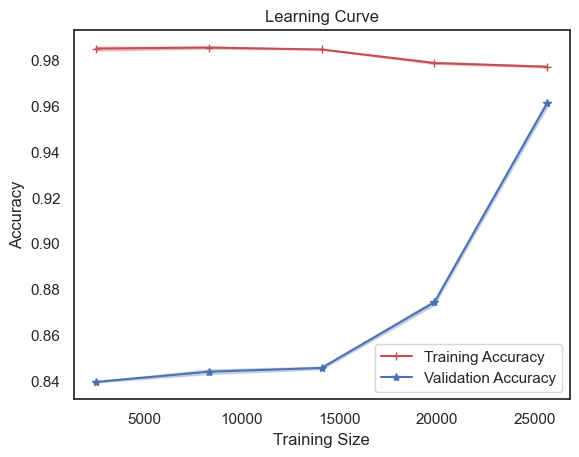

ROC AUC: 0.9666


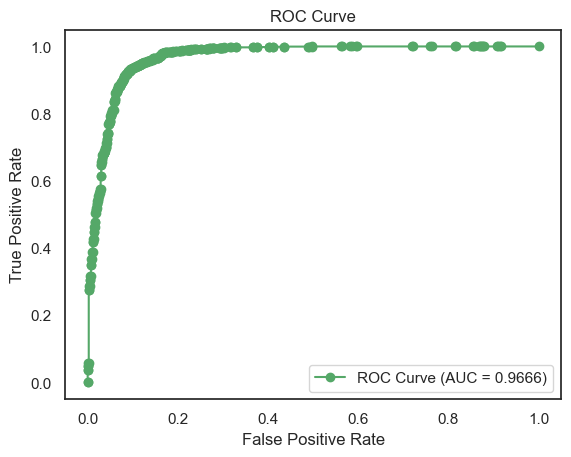

In [173]:
Check_Overfitting_Classification(XGBoost_model,x,y,x_train,y_train,x_valid,y_valid,'f1','StratifiedKFold',5,'f1')

In [174]:
have_overfitting[0] = 0 # if have overfitting add -1 if have small overfitting between(1% and 4%) add 0 if no overfitting add 1

### Get y_predict

In [175]:
y_pred = XGBoost_model.predict(x_test)

### Evaluate model

In [176]:
def plot_confusion_matrix(y_test, y_pred):
    """
    Plots a confusion matrix using seaborn's heatmap.

    Parameters:
    - y_test: array-like, shape (n_samples,)
        True labels of the test set.
    - y_pred: array-like, shape (n_samples,)
        Predicted labels by the model.

    This function calculates the confusion matrix from the true and predicted labels, 
    and then plots it as a heatmap with annotations and customizations for better visualization.
    """

    # Calculate the confusion matrix
    confusion = confusion_matrix(y_test, y_pred)

    # Create a figure and axis
    plt.figure(figsize=(8, 6))

    # Create a heatmap with customization
    sns.heatmap(
        data=confusion,
        annot=True,               # Annotate cells with the data value
        fmt="d",                  # Format the annotations as integers
        cmap="YlGnBu",            # Colormap
        cbar=True,                # Show color bar
        cbar_kws={'label': 'Scale'},  # Color bar customization
        linewidths=0.5,           # Line width between cells
        linecolor='gray',         # Line color between cells
        square=True,              # Force square cells
        annot_kws={"size": 10},   # Annotation font size
        xticklabels=True,         # Show x-axis labels
        yticklabels=True          # Show y-axis labels
    )

    # Customize the plot
    plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=14, weight='bold')
    plt.ylabel('True Label', fontsize=14, weight='bold')

    # Rotate x-axis labels
    plt.xticks(rotation=0, ha='right')

    # Adjust layout for better fit
    plt.tight_layout()

    # Display the heatmap
    plt.show()


def evaluate_model_Classification(y_test, y_pred):
    """
    Evaluates a classification model and plots the ROC curve.

    Parameters:
    - y_test: array-like, shape (n_samples,)
        True labels of the test set.
    - y_pred: array-like, shape (n_samples,)
        Predicted labels by the model.

    This function calculates several evaluation metrics including accuracy, recall,
    precision, F1 score, and ROC AUC score. It also plots the ROC curve.
    """

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    

    # Print evaluation metrics
    print(f'Accuracy score = {accuracy:.4f}')
    print(f'Recall score = {recall:.4f}')
    print(f'Precision score = {precision:.4f}')
    print(f'F1 score = {f1:.4f}')
    print(f'ROC AUC score = {roc_auc:.4f}')
    
    print("\nClassification Report:")
    print(f'\n{class_report}\n')

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, weight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, weight='bold')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18, weight='bold')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return accuracy, recall, precision, f1, roc_auc



#### Confusion Matrix

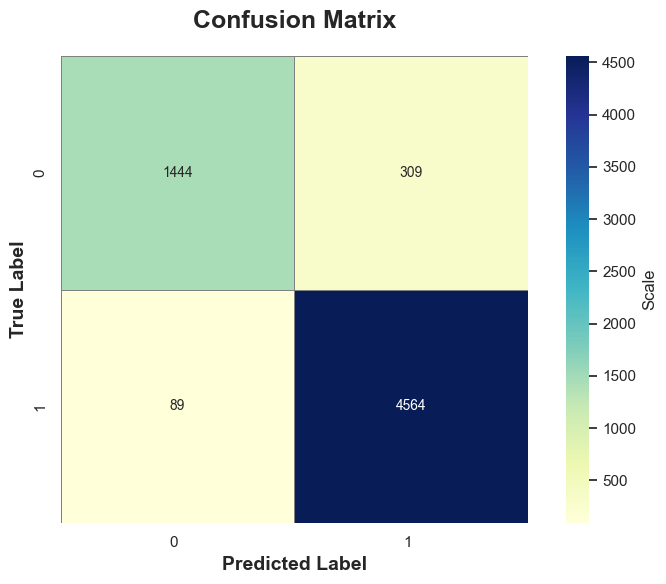

In [177]:
plot_confusion_matrix(y_test, y_pred)

#### accuracy,recall,precision,f1 and roc_auc

Accuracy score = 0.9379
Recall score = 0.9809
Precision score = 0.9366
F1 score = 0.9582
ROC AUC score = 0.9023

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1753
           1       0.94      0.98      0.96      4653

    accuracy                           0.94      6406
   macro avg       0.94      0.90      0.92      6406
weighted avg       0.94      0.94      0.94      6406




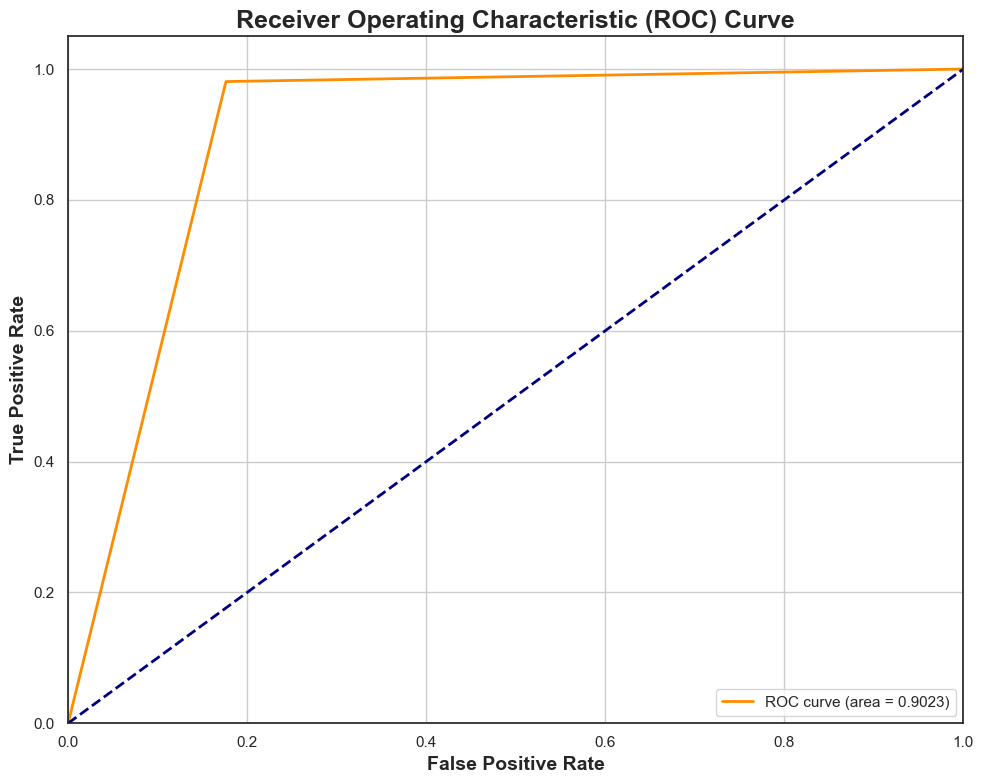

In [178]:
accuracy, recall, precision, f1, roc_auc = evaluate_model_Classification(y_test, y_pred)
models_values[0] = [accuracy, recall, precision, f1, roc_auc]

## Random Forest

### Grid Search

In [179]:
# rf = RandomForestClassifier(random_state=42)

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'class_weight': ['balanced', 'balanced_subsample']
# }

# rf_grid_search = GridSearchCV(
#     estimator=rf, 
#     param_grid=param_grid, 
#     scoring='f1', 
#     cv=type_cross_valid, 
#     n_jobs=-1, 
#     verbose=2
# )

In [180]:
# # Fit GridSearchCV
# print("Starting GridSearchCV...")
# rf_grid_search.fit(x_train, y_train)

In [181]:
# best_params = rf_grid_search.best_params_
# best_score = rf_grid_search.best_score_
# print('best_params =',best_params)
# print('best_score =',best_score)

In [ ]:
# best_score = 0.957869204761361

# formatted_text = ', \n'.join(
#     f"{key} = '{value}'" if isinstance(value, str) else f"{key} = {value}"
#     for key, value in best_params.items()
# )
# print(f'({formatted_text})')

In [182]:
# RF_model = rf_grid_search.best_estimator_
# RF_model

### Normal Train

In [183]:
RF_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=20,
    min_samples_leaf=5, 
    min_samples_split=5, 
    max_features='sqrt', 
    class_weight='balanced', 
    random_state=42
)

RF_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=5, min_samples_split=5,
                       n_estimators=200, random_state=42)

### Check Overfitting

Accuracy:
Training Accuracy: 0.9618
Validation Accuracy: 0.9164

Precision:
Training Precision: 0.9620
Validation Precision: 0.9165

Recall:
Training Recall: 0.9618
Validation Recall: 0.9164

F1-Score:
Training F1-Score: 0.9619
Validation F1-Score: 0.9165

MCC:
Training MCC: 0.9055
Validation MCC: 0.7888

Balanced Accuracy:
Training Balanced Accuracy: 0.9548
Validation Balanced Accuracy: 0.8949

Confusion Matrix:
Validation Confusion Matrix:
[[ 707  127]
 [ 130 2111]]

Cross-Validation(CV):
Cross-Validation Scores: [0.94792339 0.95244216 0.95133269 0.94636678 0.94757324]
Cross-Validation Mean Score: 0.9491


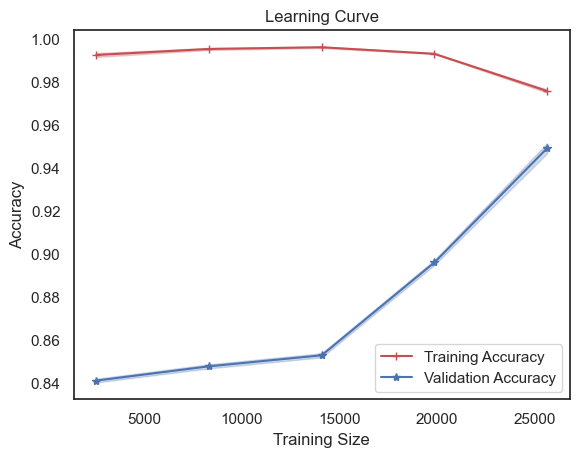

ROC AUC: 0.9574


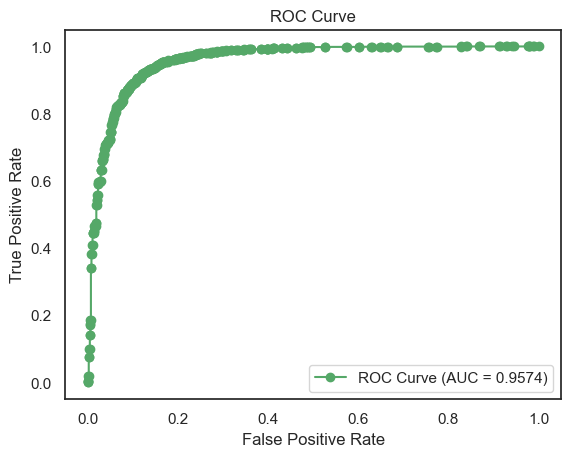

In [184]:
Check_Overfitting_Classification(RF_model,x,y,x_train,y_train,x_valid,y_valid,'f1','StratifiedKFold',5,'f1')

In [185]:
have_overfitting[1] = 0 # if have overfitting add -1 if have small overfitting between(1% and 4%) add 0 if no overfitting add 1

### Get y_predict

In [186]:
y_pred = RF_model.predict(x_test)

### Evaluate model

#### Confusion Matrix

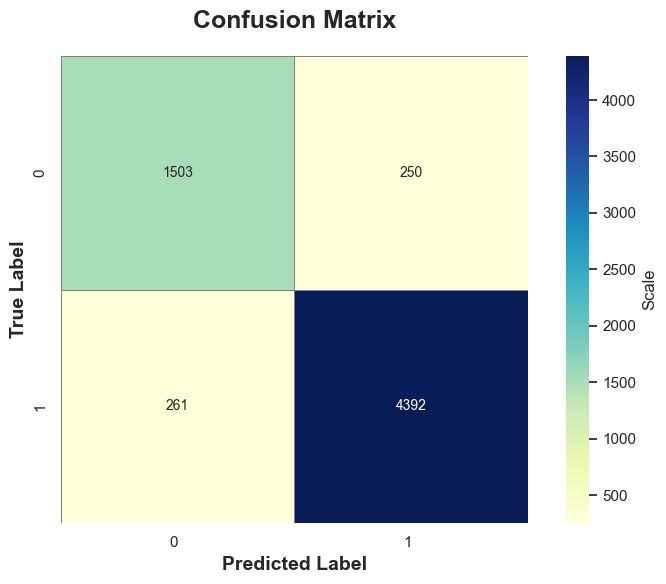

In [187]:
plot_confusion_matrix(y_test, y_pred)

#### accuracy,recall,precision,f1 and roc_auc

Accuracy score = 0.9202
Recall score = 0.9439
Precision score = 0.9461
F1 score = 0.9450
ROC AUC score = 0.9006

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1753
           1       0.95      0.94      0.95      4653

    accuracy                           0.92      6406
   macro avg       0.90      0.90      0.90      6406
weighted avg       0.92      0.92      0.92      6406




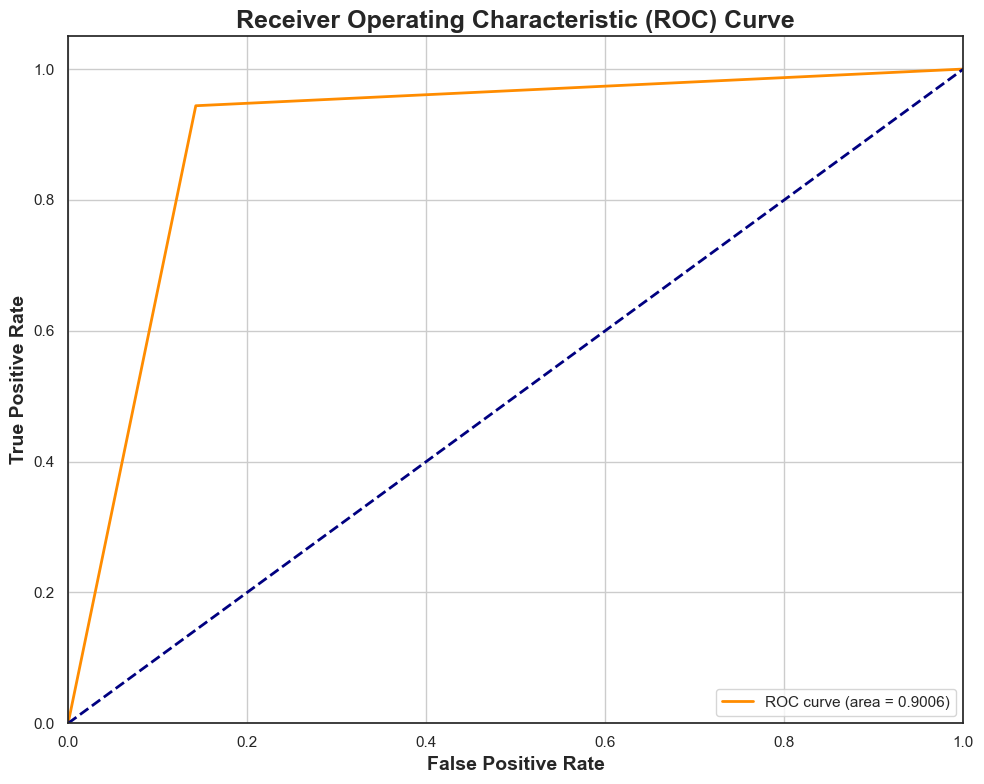

In [188]:
accuracy, recall, precision, f1, roc_auc = evaluate_model_Classification(y_test, y_pred)
models_values[1] = [accuracy, recall, precision, f1, roc_auc]

## LightGBM

### Grid Search

In [189]:
# lgb = LGBMClassifier(random_state=42)

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [-1, 5, 10],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'scale_pos_weight': [1, 10, 25]  # For imbalance handling
# }

# lgb_grid_search = GridSearchCV(
#     estimator=lgb, 
#     param_grid=param_grid, 
#     scoring='f1', 
#     cv=type_cross_valid, 
#     n_jobs=-1, 
#     verbose=2
# )

In [190]:
# # Fit GridSearchCV
# print("Starting GridSearchCV...")
# lgb_grid_search.fit(x_train, y_train)

In [191]:
# best_params = lgb_grid_search.best_params_
# best_score = lgb_grid_search.best_score_
# print('best_params =',best_params)
# print('best_score =',best_score)

In [ ]:
# best_score = 0.9658005958325004

# formatted_text = ', \n'.join(
#     f"{key} = '{value}'" if isinstance(value, str) else f"{key} = {value}"
#     for key, value in best_params.items()
# )
# print(f'({formatted_text})')

In [192]:
# lgb_model = lgb_grid_search.best_estimator_
# lgb_model

### Normal Train

In [193]:
lgb_model = LGBMClassifier(
    n_estimators=1000, 
    colsample_bytree=0.7, 
    learning_rate=0.05, 
    max_depth=8, 
    scale_pos_weight=1, 
    subsample=0.7, 
    reg_alpha=0.1, 
    reg_lambda=0.5,
    min_child_samples=20, 
    random_state=42)

lgb_model.fit(
    x_train, y_train,
    eval_set=[(x_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(50)]
)

[LightGBM] [Info] Number of positive: 16250, number of negative: 6299
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 22549, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.720653 -> initscore=0.947702
[LightGBM] [Info] Start training from score 0.947702
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=8,
               n_estimators=1000, random_state=42, reg_alpha=0.1,
               reg_lambda=0.5, scale_pos_weight=1, subsample=0.7)

### Check Overfitting

Accuracy:
Training Accuracy: 0.9745
Validation Accuracy: 0.9509

Precision:
Training Precision: 0.9749
Validation Precision: 0.9510

Recall:
Training Recall: 0.9745
Validation Recall: 0.9509

F1-Score:
Training F1-Score: 0.9742
Validation F1-Score: 0.9501

MCC:
Training MCC: 0.9366
Validation MCC: 0.8739

Balanced Accuracy:
Training Balanced Accuracy: 0.9575
Validation Balanced Accuracy: 0.9226

Confusion Matrix:
Validation Confusion Matrix:
[[ 718  116]
 [  35 2206]]

Cross-Validation(CV):
Cross-Validation Scores: [0.96907435 0.96673355 0.96807044 0.96717493 0.97161688]
Cross-Validation Mean Score: 0.9685


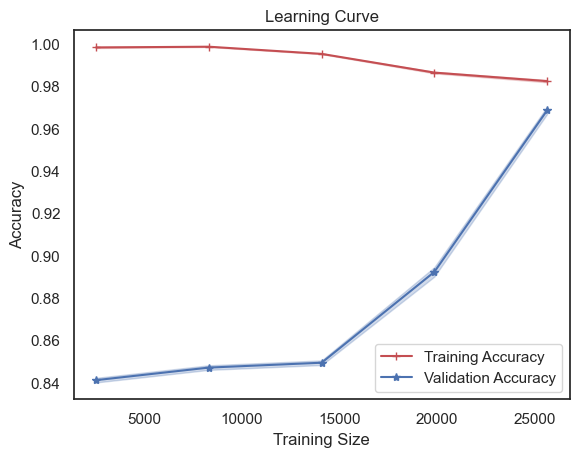

ROC AUC: 0.9692


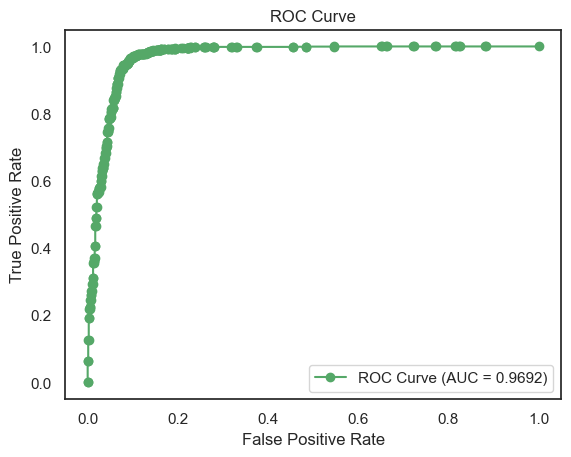

In [194]:
Check_Overfitting_Classification(lgb_model,x,y,x_train,y_train,x_valid,y_valid,'f1','StratifiedKFold',5,'f1')

In [195]:
have_overfitting[2] = 0 # if have overfitting add -1 if have small overfitting between(1% and 4%) add 0 if no overfitting add 1

### Get y_predict

In [196]:
y_pred = lgb_model.predict(x_test)

### Evaluate model

#### Confusion Matrix

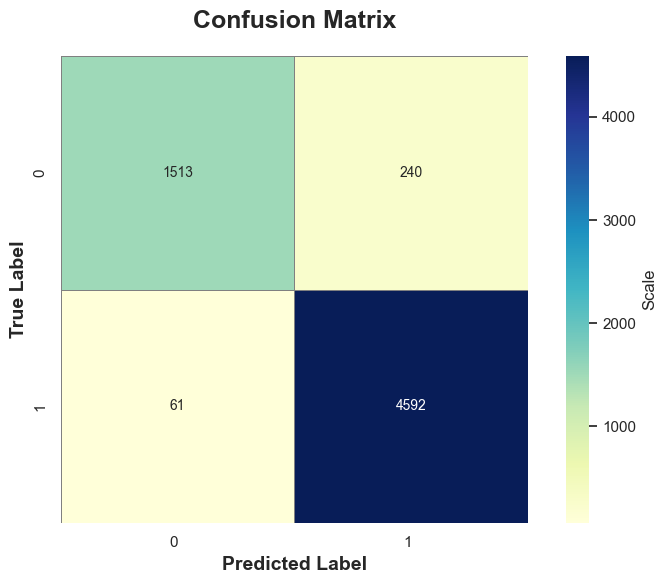

In [197]:
plot_confusion_matrix(y_test, y_pred)

#### accuracy,recall,precision,f1 and roc_auc

Accuracy score = 0.9530
Recall score = 0.9869
Precision score = 0.9503
F1 score = 0.9683
ROC AUC score = 0.9250

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1753
           1       0.95      0.99      0.97      4653

    accuracy                           0.95      6406
   macro avg       0.96      0.92      0.94      6406
weighted avg       0.95      0.95      0.95      6406




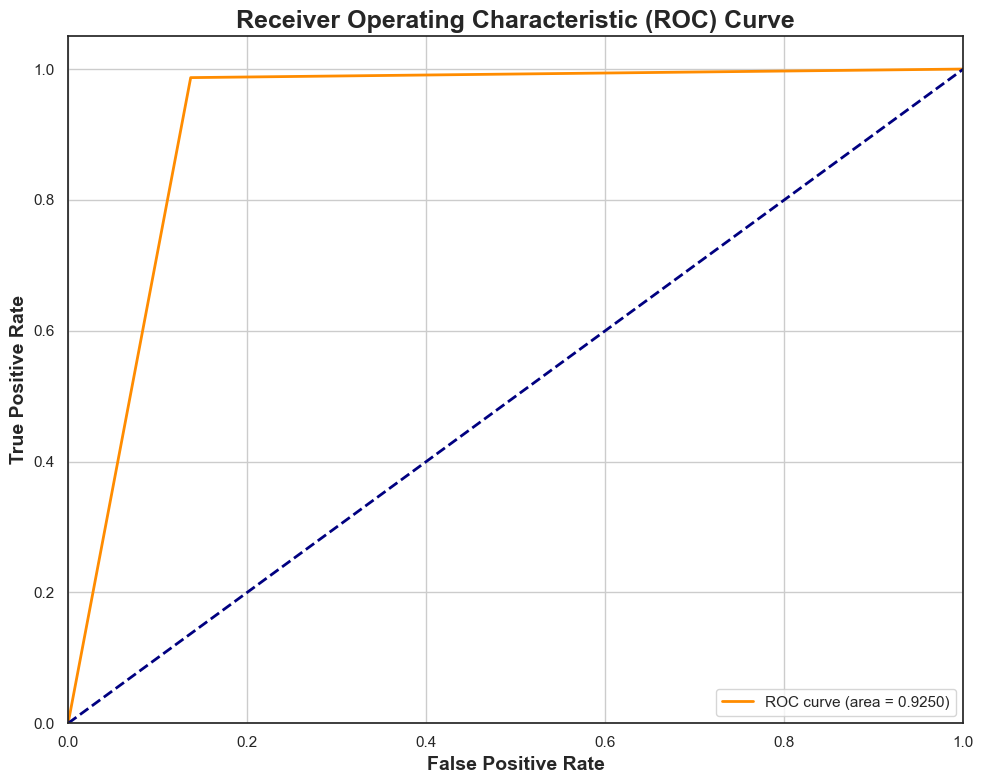

In [198]:
accuracy, recall, precision, f1, roc_auc = evaluate_model_Classification(y_test, y_pred)
models_values[2] = [accuracy, recall, precision, f1, roc_auc]

## CatBoost

### Grid Search

In [199]:
# catboost = CatBoostClassifier(verbose=0, allow_writing_files=False, random_state=42)

# param_grid = {
#     'iterations': [100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'depth': [4, 6, 8],
#     'l2_leaf_reg': [3, 5, 7],
#     'scale_pos_weight': [1, 10, 25]  # For imbalance handling
# }

# catboost_grid_search = GridSearchCV(
#     estimator=catboost, 
#     param_grid=param_grid, 
#     scoring='f1', 
#     cv=type_cross_valid, 
#     n_jobs=-1, 
#     verbose=2
# )

In [200]:
# # Fit GridSearchCV
# print("Starting GridSearchCV...")
# catboost_grid_search.fit(x_train, y_train)

In [201]:
# best_params = catboost_grid_search.best_params_
# best_score = catboost_grid_search.best_score_
# print('best_params =',best_params)
# print('best_score =',best_score)



In [ ]:
# best_score = 0.9674295049799062

# formatted_text = ', \n'.join(
#     f"{key} = '{value}'" if isinstance(value, str) else f"{key} = {value}"
#     for key, value in best_params.items()
# )
# print(f'({formatted_text})')

In [202]:
# catboost_model = catboost_grid_search.best_estimator_
# catboost_model

### Normal Train

In [203]:
catboost_model = CatBoostClassifier(
    iterations=200, 
    depth=8,
    verbose=0, 
    l2_leaf_reg=3, 
    learning_rate=0.2, 
    scale_pos_weight=1, 
    allow_writing_files=False, 
    random_state=42
)

catboost_model.fit(
    x_train, 
    y_train, 
    eval_set=(x_valid, y_valid), 
    # cat_features=categorical_features_indices  # if you have categorical features
)

### Check Overfitting

Accuracy:
Training Accuracy: 0.9704
Validation Accuracy: 0.9515

Precision:
Training Precision: 0.9710
Validation Precision: 0.9516

Recall:
Training Recall: 0.9704
Validation Recall: 0.9515

F1-Score:
Training F1-Score: 0.9700
Validation F1-Score: 0.9508

MCC:
Training MCC: 0.9263
Validation MCC: 0.8756

Balanced Accuracy:
Training Balanced Accuracy: 0.9502
Validation Balanced Accuracy: 0.9238

Confusion Matrix:
Validation Confusion Matrix:
[[ 720  114]
 [  35 2206]]

Cross-Validation(CV):
Cross-Validation Scores: [0.96696315 0.9674085  0.96674433 0.96643727 0.97057261]
Cross-Validation Mean Score: 0.9676


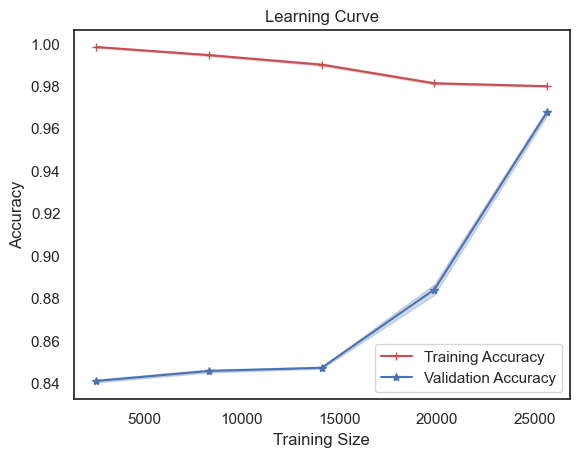

ROC AUC: 0.9690


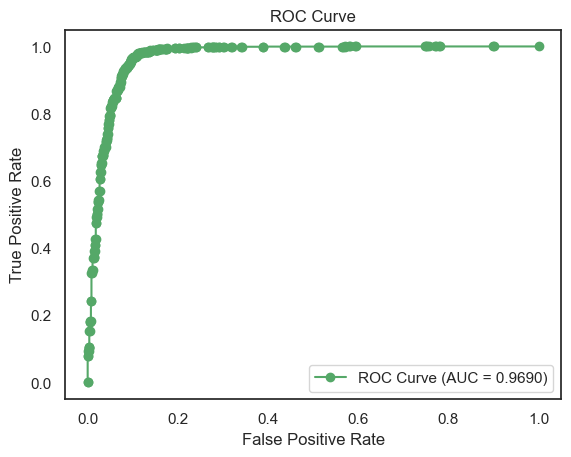

In [204]:
Check_Overfitting_Classification(catboost_model,x,y,x_train,y_train,x_valid,y_valid,'f1','StratifiedKFold',5,'f1')

In [205]:
have_overfitting[3] = 0 # if have overfitting add -1 if have small overfitting between(1% and 4%) add 0 if no overfitting add 1

### Get y_predict

In [206]:
y_pred = catboost_model.predict(x_test)

### Evaluate model

#### Confusion Matrix

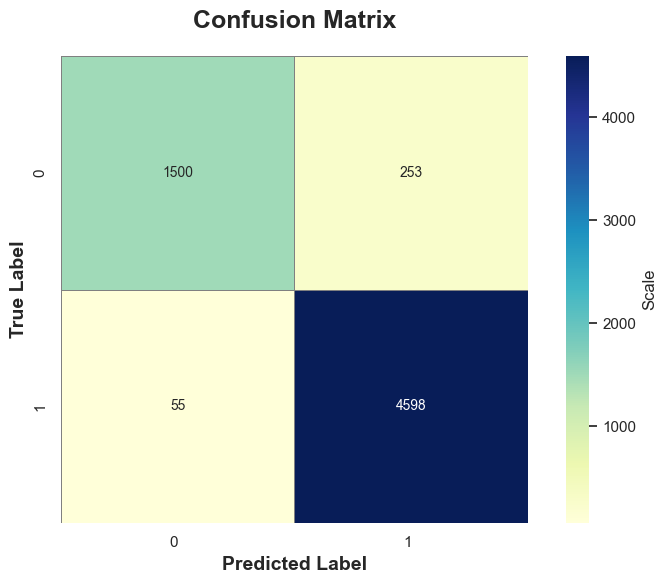

In [207]:
plot_confusion_matrix(y_test, y_pred)

#### accuracy,recall,precision,f1 and roc_auc

Accuracy score = 0.9519
Recall score = 0.9882
Precision score = 0.9478
F1 score = 0.9676
ROC AUC score = 0.9219

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1753
           1       0.95      0.99      0.97      4653

    accuracy                           0.95      6406
   macro avg       0.96      0.92      0.94      6406
weighted avg       0.95      0.95      0.95      6406




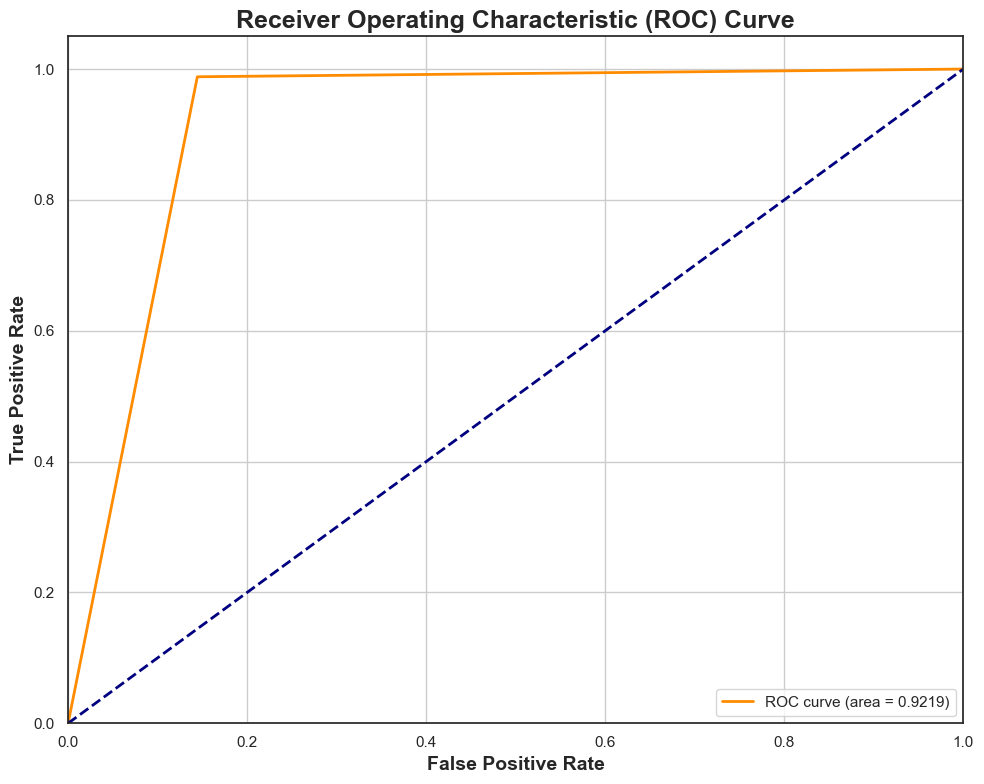

In [208]:
accuracy, recall, precision, f1, roc_auc = evaluate_model_Classification(y_test, y_pred)
models_values[3] = [accuracy, recall, precision, f1, roc_auc]

# save and load the models

## Save the models

In [209]:
# Create a directory to store the pickle files
output_folder = "pickle/models"
os.makedirs(output_folder, exist_ok=True)

# Define the models
models = {
    "XGBoost_model": XGBoost_model,
    "RF_model": RF_model,
    "lgb_model": lgb_model,
    "catboost_model": catboost_model
}

# Save each model to a separate pickle file
for model_name, model_object in models.items():
    filepath = os.path.join(output_folder, f"{model_name}.pkl")
    with open(filepath, "wb") as file:
        pickle.dump(model_object, file)
    print(f"Model '{model_name}' saved to '{filepath}'.")


Model 'XGBoost_model' saved to 'pickle/models\XGBoost_model.pkl'.
Model 'RF_model' saved to 'pickle/models\RF_model.pkl'.
Model 'lgb_model' saved to 'pickle/models\lgb_model.pkl'.
Model 'catboost_model' saved to 'pickle/models\catboost_model.pkl'.


## load the models

In [210]:
# # Load all models from the pickle folder
# loaded_models = {}

# for model_name in models.keys():
#     filepath = os.path.join(output_folder, f"{model_name}.pkl")
#     with open(filepath, "rb") as file:
#         loaded_models[model_name] = pickle.load(file)
#         print(f"Model '{model_name}' loaded from '{filepath}'.")

# # Access each loaded model
# XGBoost_model_loaded = loaded_models["XGBoost_model"]
# RF_model_loaded = loaded_models["RF_model"]
# lgb_model_loaded = loaded_models["lgb_model"]
# catboost_model_loaded = loaded_models["catboost_model"]


## Deep Learning

In [211]:
def get_optimizer(
    op_type: Literal['SGD', 'Momentum', 'Nesterov', 'Adagrad', 'RMSprop', 'Adam', 'Adadelta', 'Adamax', 'Nadam'] = 'Adam',
    learning_rate: float = 0.001,
    SGD_learning_rate: float = 0.01,
    momentum: float = 0.9,
    beta_1: float = 0.9,
    beta_2: float = 0.999,
    decay: float = 0.0,
    amsgrad: bool = False,
    rho: float = 0.9,
    initial_accumulator_value: float = 0.1
):
    """
    Returns a specified Keras optimizer.

    Parameters:
    - op_type (Literal): The type of optimizer to use. Default is 'Adam'.
    - learning_rate (float): Learning rate for the optimizer. Default is 0.001.
    - SGD_learning_rate (float): Learning rate specifically for SGD-based optimizers. Default is 0.01.
    - momentum (float): Momentum factor for optimizers that use momentum. Default is 0.9.
    - beta_1 (float): The exponential decay rate for the 1st moment estimates in Adam-based optimizers. Default is 0.9.
    - beta_2 (float): The exponential decay rate for the 2nd moment estimates in Adam-based optimizers. Default is 0.999.
    - decay (float): Learning rate decay over each update for some optimizers. Default is 0.0.
    - amsgrad (bool): Whether to apply the AMSGrad variant of the Adam optimizer. Default is False.
    - rho (float): Discounting factor for the history/coming gradient in RMSprop and Adadelta. Default is 0.9.
    - initial_accumulator_value (float): Starting value for the accumulators in Adagrad. Default is 0.1.

    Returns:
    - optimizer: A Keras optimizer instance.
    """

    if op_type == 'SGD':
        optimizer = SGD(learning_rate=SGD_learning_rate)
    elif op_type == 'Momentum':
        optimizer = SGD(learning_rate=SGD_learning_rate, momentum=momentum)
    elif op_type == 'Nesterov':
        optimizer = SGD(learning_rate=SGD_learning_rate, momentum=momentum, nesterov=True)
    elif op_type == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate, initial_accumulator_value=initial_accumulator_value)
    elif op_type == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate, rho=rho, decay=decay)
    elif op_type == 'Adam':
        optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, amsgrad=amsgrad)
    elif op_type == 'Adadelta':
        optimizer = Adadelta(learning_rate=learning_rate, rho=rho, decay=decay)
    elif op_type == 'Adamax':
        optimizer = Adamax(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, decay=decay)
    elif op_type == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, decay=decay)
    else:
        raise ValueError("Invalid optimizer_type. Choose from 'SGD', 'Momentum', 'Nesterov', 'Adagrad', 'RMSprop', 'Adam', 'Adadelta', 'Adamax', 'Nadam'.")
    return optimizer


def get_loss(
    loss_type: Literal['mean_squared_error', 'mean_absolute_error', 'Huber', 
                        'binary_crossentropy', 'hinge', 'categorical_crossentropy', 
                        'sparse_categorical_crossentropy'] = 'mean_squared_error',
    from_logits: bool = False,
    delta: float = 1.0,
    reduction: Literal['none', 'sum', 'sum_over_batch_size'] = 'sum_over_batch_size',
    label_smoothing: float = 0.0,
    axis: int = -1
):
    """
    Returns a specified Keras loss function.

    Parameters:
    - loss_type (Literal): The type of loss function to use. Default is 'mean_squared_error'.
    - from_logits (bool): Whether to interpret the output as logits (for cross-entropy losses). Default is False.
    - delta (float): The threshold at which to change between quadratic and linear loss (for Huber loss). Default is 1.0.
    - reduction (Literal): Type of reduction to apply to the loss. Options are 'none', 'sum', 'sum_over_batch_size'. Default is 'sum_over_batch_size'.
    - label_smoothing (float): Float in [0, 1]. When > 0, label values are smoothed, meaning the confidence on label values are relaxed. Default is 0.0.
    - axis (int): The axis along which to compute crossentropy (for categorical crossentropy losses). Default is -1.

    Returns:
    - loss: A Keras loss function instance.
    """

    if loss_type == 'mean_squared_error':
        loss = MeanSquaredError(reduction=reduction)
    elif loss_type == 'mean_absolute_error':
        loss = MeanAbsoluteError(reduction=reduction)
    elif loss_type == 'Huber':
        loss = Huber(delta=delta, reduction=reduction)
    elif loss_type == 'binary_crossentropy':
        loss = BinaryCrossentropy(from_logits=from_logits, label_smoothing=label_smoothing, reduction=reduction)
    elif loss_type == 'hinge':
        loss = Hinge(reduction=reduction)
    elif loss_type == 'categorical_crossentropy':
        loss = CategoricalCrossentropy(from_logits=from_logits, label_smoothing=label_smoothing, reduction=reduction, axis=axis)
    elif loss_type == 'sparse_categorical_crossentropy':
        loss = SparseCategoricalCrossentropy(from_logits=from_logits, reduction=reduction)
    else:
        raise ValueError("Invalid loss_type. Choose from 'mean_squared_error', 'mean_absolute_error', 'Huber', 'binary_crossentropy', 'hinge', 'categorical_crossentropy', 'sparse_categorical_crossentropy'.")
    
    return loss


def plot_line_matplotlib(x, y=None, df=None, 
                        num_of_line: int = 1, title: str = 'Line Plot', 
                        xlabel: str = None, ylabel: str = None, x_rotation=0,labels: list =None,
                        palette: str = 'magma',palette2: str = 'viridis', color = None, linestyles =True,
                        linewidths: float = 1.5, markers = True,markersize: float = 5, figsize: tuple=(10, 7), subplot=False, ax=None):
    """
    Plots a line chart using Matplotlib and Seaborn.
    
    Parameters:
    --------
    x (str or list of str): The column name(s) to be used for the x-axis.
    y (str or list of str): The column name(s) to be used for the y-axis.
    data (pd.DataFrame): The DataFrame containing the data to plot.
    num_of_line (int): Number of lines to plot. Default is 1.
    title (str): The title of the plot. Default is 'Line Plot'.
    xlabel (str): The label for the x-axis. Default is None.
    ylabel (str): The label for the y-axis. Default is None.
    palette (str): The color palette to use for the lines. Default is 'magma'.
    linewidths (float): The width of the lines. Default is 1.5.
    figsize (tuple): Size of the figure. Default is (10, 7).
    subplot (bool): Flag to indicate if this is a subplot. Default is False.
    ax (matplotlib.axes._subplots.AxesSubplot): The axis to plot on. Default is None.
    
    Example:
    --------
    >>> plot_line_matplotlib(x='time',y=['velocity_obj_1','velocity_obj_2'],data=df_vel,num_of_line = 2)
    
    Returns:
    None
    """
    # Ensure x and y are lists
    if not isinstance(x, list):
        x = [x]
    if y is not None:
        if not isinstance(y, list):
            y = [y]
    
    # Adjust the length of x and y to match num_of_line
    x_length = len(x)
    if y is not None:
        y_length = len(y)
    if y is not None:
        if x_length > y_length:
            y = y * x_length
        if x_length < y_length:
            x = x * y_length
    
    # get the color for each plot
    if color is None:
        if num_of_line <= 6 :
            colors = random.sample(sns.color_palette(palette), num_of_line)
        elif num_of_line <= 12 :
            colors = random.sample(sns.color_palette(palette) + sns.color_palette(palette2), num_of_line)
        elif num_of_line > 12 :
            colors = random.choices(sns.color_palette(palette) + sns.color_palette(palette2), k=num_of_line)
    else:
        colors = [color] * num_of_line
    
    # Generate random styles
    if linestyles == True:
        linestyles = random.sample(['-', '--', '-.', ':', None], num_of_line)
    else:
        linestyles = [None] * num_of_line
    
    if markers == True:
        markers = random.sample(['o', 'X', 's', '*', '+'], num_of_line)
    else:
        markers = [None] * num_of_line
    
    # Set default x and y labels if not provided
    if xlabel is None:
        xlabel = x[0]
    if y is not None:
        if ylabel is None:
            ylabel = y[0]
    
    # Plotting
    if subplot and ax is not None:
        for i in range(num_of_line):
            ax.plot(x[i], y[i], color=colors[i], linestyle=linestyles[i], linewidth=linewidths, marker=markers[i], markersize=markersize, data=df)
        ax.set_title(title)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.legend(title=title, loc='best')
        ax.grid(True, linestyle='--', linewidth=0.8, alpha=0.5)
    elif y is None and df is None:
        plt.figure(figsize=figsize)
        for i in range(num_of_line):
            plt.plot(x[i], color=colors[i], linestyle=linestyles[i], linewidth=linewidths,label=labels[i], marker=markers[i], markersize=markersize)
        plt.title(title)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.xticks(rotation=x_rotation)
        plt.legend(title=title, loc='best')
        plt.grid(True, linestyle='--', linewidth=0.8, alpha=0.5)
        plt.show()
    else:
        plt.figure(figsize=figsize)
        for i in range(num_of_line):
            plt.plot(x[i], y[i], color=colors[i], linestyle=linestyles[i], linewidth=linewidths, marker=markers[i], markersize=markersize,data=df)
        plt.title(title)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.xticks(rotation=x_rotation)
        plt.legend(title=title, loc='best')
        plt.grid(True, linestyle='--', linewidth=0.8, alpha=0.5)
        plt.show()




In [212]:
model = Sequential()

model.add(Dense(units=128, activation='relu', input_dim=x_train.shape[1])) # or ,input_shape=(x_train.shape[1],)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))

In [213]:
# get_optimizer
optimizer = get_optimizer(op_type='Adam', learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# get_loss
loss = get_loss(loss_type='binary_crossentropy', from_logits=False, label_smoothing=0, reduction='sum_over_batch_size')

In [214]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [215]:
# Create the EarlyStopping callback to stop training if no improvement
early_stopping = EarlyStopping(
    monitor='val_loss',  # Track validation loss
    mode='min',  # Stop when the validation loss is not decreasing
    patience=5,  # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True  # Restore the weights of the best epoch after stopping
)

# Define the file path to save the best weights
checkpoint_filepath = 'model_best_weights.weights.h5'

# Create the ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only the model's weights
    monitor='val_loss',  # Track validation loss
    mode='min',  # Save the model when the validation loss is minimized
    save_best_only=True  # Only save the best model
)

# # To load the saved best weights later (if needed)
# model.load_weights(checkpoint_filepath)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,  # Reduce learning rate by 80%
    patience=3,  # Wait 3 epochs before reducing learning rate
    min_lr=1e-5
)


In [216]:
history = model.fit(
    x_train, y_train, 
    validation_data=(x_valid,y_valid),  # if dont split the data train, test, valid use validation_split=0.2
    callbacks=[early_stopping, checkpoint, reduce_lr], 
    verbose=1, 
    batch_size=64, 
    epochs=80)

Epoch 1/80
353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5690 - loss: 0.7494 - val_accuracy: 0.7369 - val_loss: 0.5491 - learning_rate: 0.0010
Epoch 2/80
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7057 - loss: 0.5896 - val_accuracy: 0.7512 - val_loss: 0.5164 - learning_rate: 0.0010
Epoch 3/80
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7256 - loss: 0.5611 - val_accuracy: 0.7571 - val_loss: 0.5081 - learning_rate: 0.0010
Epoch 4/80
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7310 - loss: 0.5421 - val_accuracy: 0.7629 - val_loss: 0.4970 - learning_rate: 0.0010
Epoch 5/80
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7405 - loss: 0.5240 - val_accuracy: 0.7607 - val_loss: 0.4900 - learning_rate: 0.0010
Epoch 6/80
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7444 - loss: 0.5233 - val_accuracy: 0.7688 - val_loss: 0.4855 - learning_rate: 0.0010
Epoch 7/80
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7442 - loss: 0.5194 - 

In [217]:
# Retrieve the epoch with the best validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1

# Display the metrics for the best epoch
best_metrics = {
    'accuracy': history.history['accuracy'][best_epoch-1],
    'loss': history.history['loss'][best_epoch-1],
    'val_accuracy': history.history['val_accuracy'][best_epoch-1],
    'val_loss': history.history['val_loss'][best_epoch-1]
}

In [218]:
print(f'Best epoch: {best_epoch}')
print(f"Metrics at best epoch:")
print(f"accuracy: {best_metrics['accuracy']:.5f}")
print(f"loss: {best_metrics['loss']:.5f}")
print(f"val_accuracy: {best_metrics['val_accuracy']:.5f}")
print(f"val_loss: {best_metrics['val_loss']:.5f}")

Best epoch: 80
Metrics at best epoch:
accuracy: 0.83596
loss: 0.38317
val_accuracy: 0.86211
val_loss: 0.33776


### Evaluation

In [219]:
loss, accuracy = model.evaluate(x_test,y_test)

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.8630 - loss: 0.3420


In [220]:
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.3405, Test Accuracy: 0.8612


### Check Overfitting

### Training and Validation accuracy

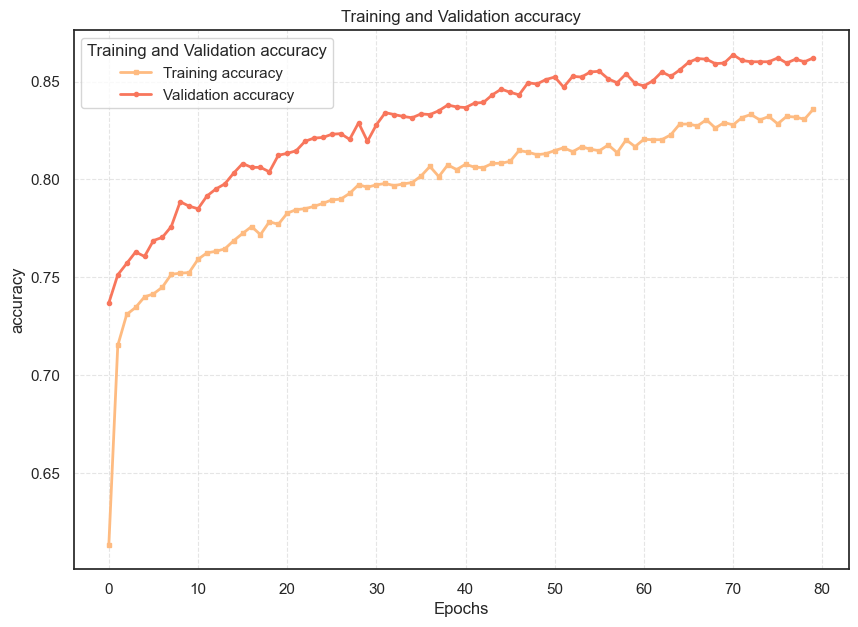

In [221]:
plot_line_matplotlib([history.history["accuracy"], history.history["val_accuracy"]],
                    labels=['Training accuracy', 'Validation accuracy'],
                    num_of_line=2,
                    linewidths=2,
                    markers = True,
                    markersize=3,
                    linestyles = False,
                    title='Training and Validation accuracy',
                    xlabel='Epochs',
                    ylabel='accuracy')

### Training and Validation loss

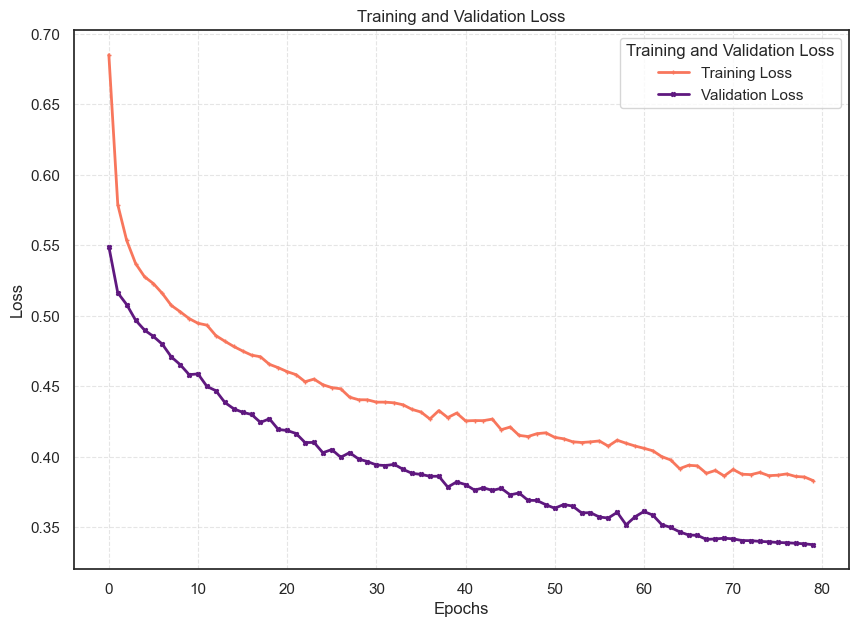

In [222]:
plot_line_matplotlib([history.history["loss"], history.history["val_loss"]],
                    labels=['Training Loss', 'Validation Loss'],
                    num_of_line=2,
                    linewidths=2,
                    markers = True,
                    markersize=3,
                    linestyles = False,
                    title='Training and Validation Loss',
                    xlabel='Epochs',
                    ylabel='Loss')

In [223]:
have_overfitting[4] = 0 # if have overfitting add -1 if have small overfitting between(1% and 4%) add 0 if no overfitting add 1

### prediction

In [224]:
y_pred = model.predict(x_test)

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [225]:
y_pred = [1 if i >=.5 else 0 for i in y_pred]

### Evaluate model

#### accuracy,recall,precision,f1 and roc_auc

Accuracy score = 0.8612
Recall score = 0.9390
Precision score = 0.8784
F1 score = 0.9077
ROC AUC score = 0.7969

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.65      0.72      1753
           1       0.88      0.94      0.91      4653

    accuracy                           0.86      6406
   macro avg       0.84      0.80      0.81      6406
weighted avg       0.86      0.86      0.86      6406




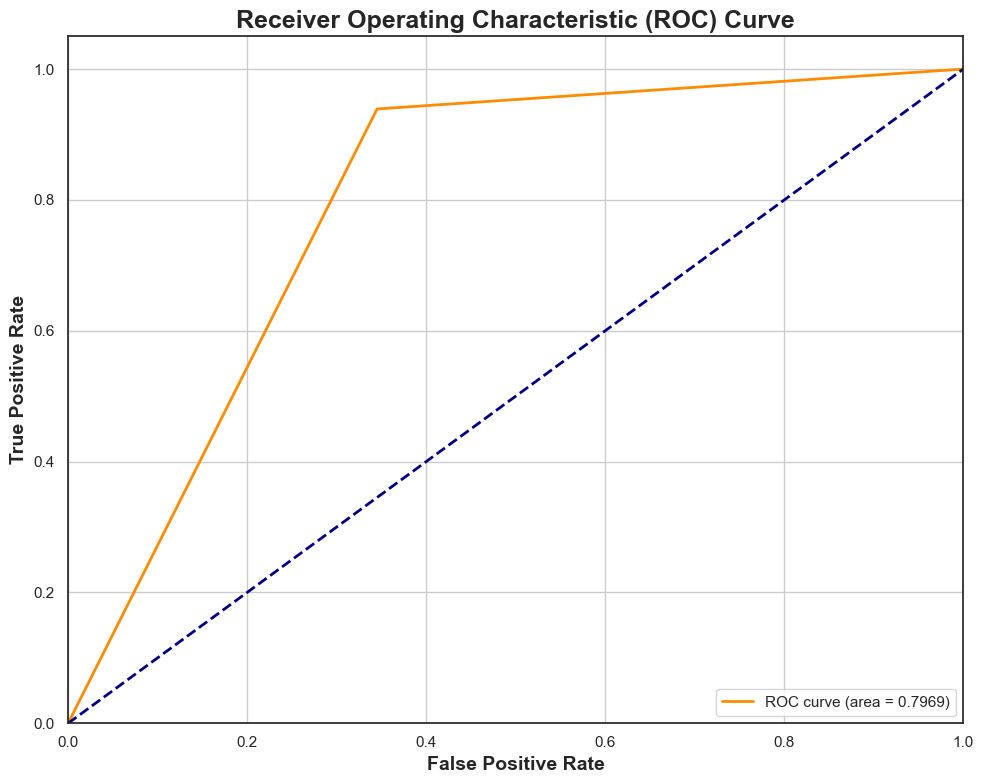

In [226]:
accuracy, recall, precision, f1, roc_auc = evaluate_model_Classification(y_test, y_pred)
models_values[4] = [accuracy, recall, precision, f1, roc_auc]

### save the model

In [227]:
model.save('my_model.keras')

# 12- Compare Between The Models

In [228]:
def plots_evaluate_models(
    models_values, 
    models_names=None, 
    evaluate_names=None,
    have_overfitting=None,
    palette='magma', # viridis, plasma, mako, rainbow, summer, autumn, bone, cool, copper, flag, gray, hot, hsv, nipy_spectral, ocean, pink, spring, winter, Set1, Set2, Set3, tab10, tab20, tab20b, tab20c
    title='Model Performance Across Different Metrics',
    xlabel='',
    ylabel='',
    width=0.75,
    edgecolor='black',
    linewidth=1.5,
    hatches=None,
    hatch=False,
    figsize=(18, 6),
    annote_num=3
):
    """
    Create an enhanced grouped bar plot of model performance metrics.
    
    Parameters:
    - models_values: 2D list of performance values 
    - models_names: List of model names
    - evaluate_names: List of metric names
    - have_overfitting: List indicating overfitting status for each model
    - Additional styling parameters with default values
    """
    # Prepare data
    num_models = len(models_values)
    num_metrics = len(models_values[0])
    
    if models_names is None:
        models_names = [f'Model {i+1}' for i in range(num_models)]
    
    if evaluate_names is None:
        evaluate_names = [f'Metric {i+1}' for i in range(num_metrics)]
    
    # Ensure have_overfitting is the correct length
    if have_overfitting is None:
        have_overfitting = [0] * num_models
    else:
        # Ensure have_overfitting is exactly as long as the number of models
        have_overfitting = list(have_overfitting)[:num_models]
        have_overfitting.extend([0] * (num_models - len(have_overfitting)))
    
    # Create DataFrame
    df = pd.DataFrame(models_values, columns=evaluate_names)
    df['Model'] = models_names
    
    # Melt the DataFrame
    df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
    
    # Set up the plot
    plt.figure(figsize=figsize)
    
    # Prepare hatches
    if hatch and not hatches:
        hatches_list = random.sample(['X', 'oo', 'O|', '/', '+', '++', '--', '-\\', 'xx', '*-', '\\\\', '|*', '\\', 'OO', 'o', '**', 'o-', '*', '//', '||', '+o', '..', '/o', 'O.', '\\|', 'x*', '|', '-', None], len(evaluate_names))
    else:
        hatches_list = hatches
    
    # Create the plot
    ax = sns.barplot(
        data=df_melted, 
        x='Model', 
        y='Value', 
        hue='Metric', 
        palette=palette, 
        errorbar=None, 
        width=width
    )
    
    # Customize bar edges
    for bar in ax.patches:
        bar.set_edgecolor(edgecolor)
        bar.set_linewidth(linewidth)
    
    # Add hatches
    if hatch and hatches_list:
        for i, bar_group in enumerate(ax.patches):
            hatch_pattern = hatches_list[i % len(hatches_list)]
            bar_group.set_hatch(hatch_pattern)
    
    # Add value labels with overfitting color coding
    for i, p in enumerate(ax.patches):
        ax.annotate(
            format(p.get_height(), f'.{annote_num}f'),
            (p.get_x() + p.get_width() / 2.1, p.get_height() - 0.012),
            ha='center', va='center', 
            xytext=(0, 10), 
            textcoords='offset points',
            fontweight='bold'
        )
    
    # Customize X-axis text colors and size
    x_labels = ax.get_xticklabels()
    for idx, label in enumerate(x_labels):
        color = 'black'  # Default color
        if have_overfitting[idx] >= 1:
            color = 'green'
        elif have_overfitting[idx] <= -1:
            color = 'red'
        label.set_color(color)
        label.set_fontsize(12)
        label.set_fontweight('bold')
    
    # Customize plot
    plt.title(title,fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontweight='bold', fontsize=16)
    plt.ylabel(ylabel, fontweight='bold', fontsize=16)
    plt.yticks(np.arange(0, 1.1, 0.1), fontweight='bold')
    plt.legend(title='Metrics', title_fontsize=16, fontsize=14, bbox_to_anchor=(1, 1), loc='best')
    plt.grid(True, linestyle='--', axis='y', linewidth=0.6, alpha=0.85)
    plt.xticks(rotation=0)
    plt.tight_layout()
    
    plt.show()


def plot_model_performance(
    models_values, 
    models_names, 
    evaluate_names, 
    have_overfitting, 
    cmap='YlGnBu',
    title='Model Performance Metrics',
    xlabel='',
    ylabel='',
    figsize=(14, 7),
    x_rotation = 45
):
    """
    Create a heatmap-style visualization of model performance metrics.
    
    Parameters:
    - models_values: 2D list of performance values 
    - models_names: List of model names
    - evaluate_names: List of metric names
    - have_overfitting: List indicating overfitting status for each model
    - Additional styling parameters for title, labels, and size.
    """
    # Convert to numpy array for easier manipulation
    values = np.array(models_values)

    # Ensure have_overfitting matches the number of models
    num_models = len(models_names)
    if len(have_overfitting) != num_models:
        have_overfitting = have_overfitting[:num_models] + [0] * (num_models - len(have_overfitting))
    
    # Create the figure and axis
    plt.figure(figsize=figsize)

    # Create heatmap
    im = plt.imshow(values, cmap=cmap, aspect='auto')

    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('Performance Score', fontweight='bold')

    # Set x and y ticks
    plt.xticks(np.arange(len(evaluate_names)), evaluate_names, rotation=x_rotation, fontweight='bold', fontsize=14) # ha='right'
    plt.yticks(np.arange(len(models_names)), models_names, fontweight='bold', fontsize=14)

    # Annotate each cell with its value
    for i in range(len(models_names)):
        for j in range(len(evaluate_names)):
            # Determine text color based on overfitting status
            if have_overfitting[i] == 0:
                text_color = 'black'
            elif have_overfitting[i] == -1:
                text_color = 'red'
            else:  # have_overfitting[i] == 1
                text_color = 'green'
            
            # Add text annotation
            plt.text(
                j, i, f'{values[i, j]:.3f}', 
                ha='center', va='center', 
                color=text_color, 
                fontweight='bold', 
                fontsize=10
            )

    # Customize plot
    plt.title(title, fontweight='bold', fontsize=18)
    plt.xlabel(xlabel, fontweight='bold', fontsize=16)
    plt.ylabel(ylabel, fontweight='bold', fontsize=16)
    plt.tight_layout()

    # Show the plot
    plt.show()



In [229]:
models_names = ['XGBoost', 'RandomForest', 'LightGBM', 'CatBoost', 'DeepLearning']
evaluate_names = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

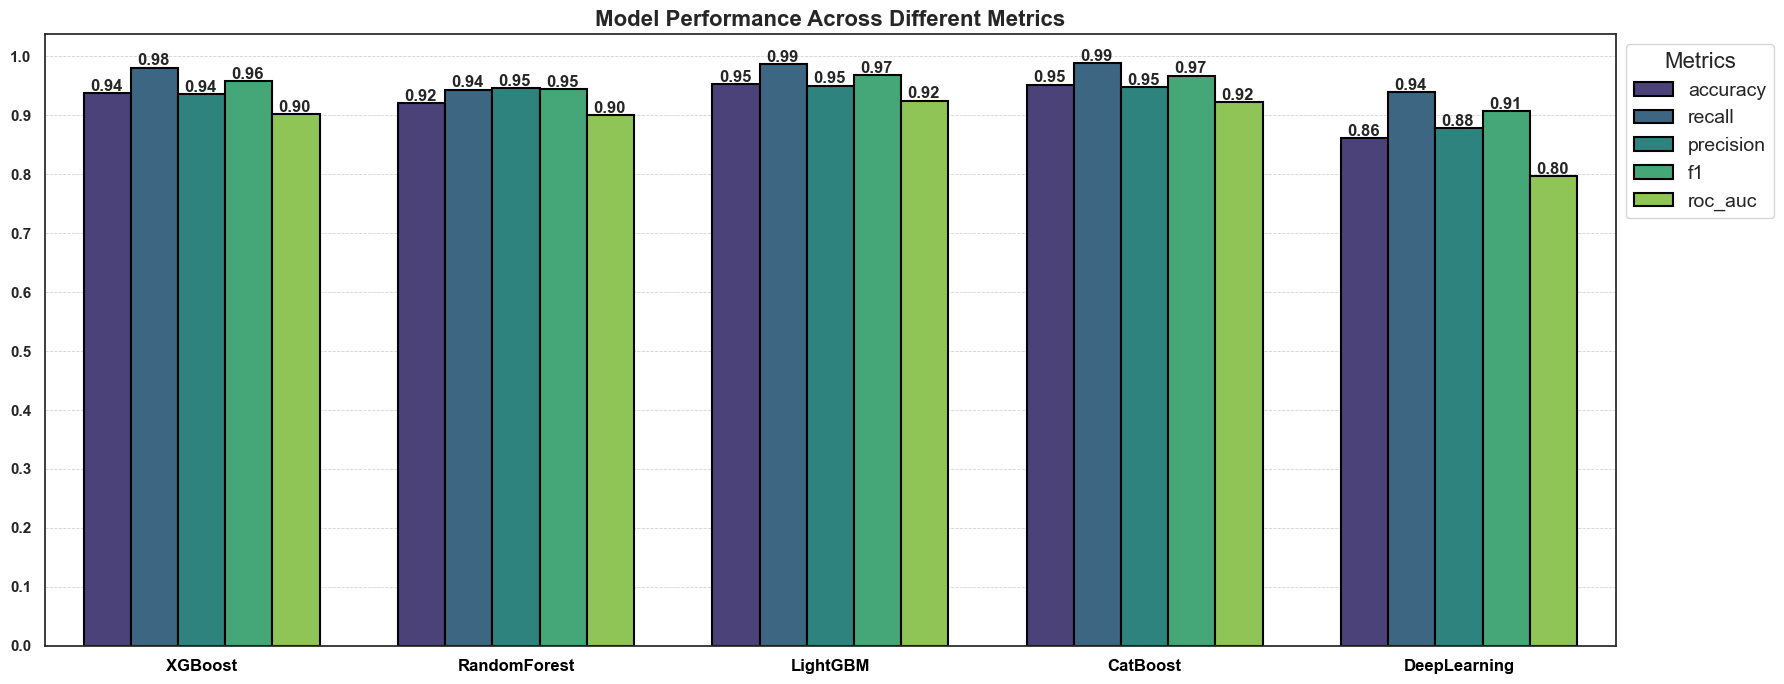

In [230]:
plots_evaluate_models(
    models_values, 
    models_names, 
    evaluate_names,
    have_overfitting,
    palette='viridis',
    title='Model Performance Across Different Metrics',
    figsize=(18, 7),
    annote_num=2
)

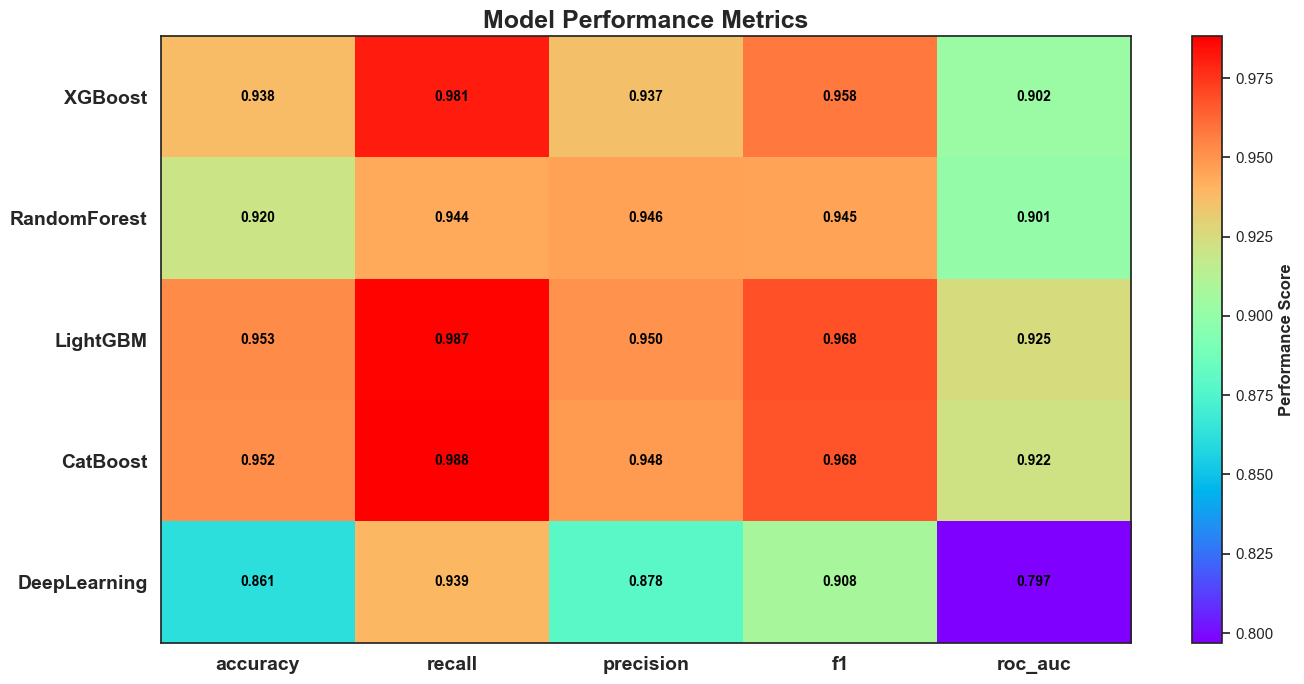

In [231]:
plot_model_performance(
    models_values, 
    models_names, 
    evaluate_names, 
    have_overfitting,
    cmap='rainbow',
    x_rotation=0)

# Get in Touch

- **LinkedIn**: [Zyad Ashraf](https://www.linkedin.com/in/zyad-ashraf-amar)
- **Email**: [zyadashrafamar@gmail.com](mailto:zyadashrafamar@gmail.com)
- **GitHub**: [Zyad-Ashraf-Abd-almalik](https://github.com/zyad-ashraf-amar)